In [ ]:
!pip install catboost --quiet --disable-pip-version-check
!pip install doubleml --quiet --disable-pip-version-check
!pip install bnlearn --quiet --disable-pip-version-check
!pip install econml --quiet --disable-pip-version-check
!pip install linearmodels --quiet --disable-pip-version-check
#!jupyter nbconvert --to html -- ml_ec_pr.ipynb

In [ ]:
import numpy as np
import pandas as pd
import scipy as scipy
from copy import deepcopy
import bnlearn
from sklearn import metrics

import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, logistic
import seaborn
import networkx as nx
from catboost import CatBoostRegressor
from econml.metalearners import TLearner, SLearner, XLearner
from linearmodels.iv import IVGMM

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,  RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer, accuracy_score
import doubleml as dml
import statsmodels.api as sm
from mlxtend.plotting import plot_confusion_matrix
from statsmodels.formula.api import probit
from statsmodels.regression.linear_model import OLS
import warnings
warnings.filterwarnings("ignore")

# Обоснование темы


***1. Придумайте непрерывную зависимую (целевую) переменную и бинарную переменную воздействия.***


**Целевая переменная** - продолжительность жизни $\text{lifespan}_{i}$ (годы).

**Переменная воздействия** - факт наличия ожирения $\text{obesity}_{i}$ (1 - есть, 0 - нет).


**Инструментальная переменная** - факт наличия ожирения хотя бы у одного из родителей $\text{parents}_{i}$ (1 - есть, 0 - нет).

**Контрольные переменные**:

*   $\text{salary}_{i}$ - заработная плата
*   $\text{educ}_{i}$ - наличие высшего образования (1 - есть высшее образование, 0 - нет высшего образования).
*   $\text{insurance}_{i}$ - наличие ДМС (1 - есть ДМС, 0 - нет ДМС).

**Ненаблюдаемые переменные, порождающие эндогенность**:

*  $\text{stress}_{i}$ - уровень стресса и моральных потрясений человека, негативно влияющих на его здоровье


**Допущения о распределении**

Все переменные и случайные ошибки предполагаются независимыми и одинаково распределенными между наблюдениями, то есть по $i\in\{1,...n\}$, где $n$ - число наблюдений.

$$\text{E}(\varepsilon^{\text{lifespan}}_{i}|\text{salary}_{i}, \text{insurance}_{i},\text{educ}_{i},\text{parents}_{i})=0$$

$$\text{E}(\varepsilon^{\text{obesity}}_{i}|\text{salary}_{i}, \text{insurance}_{i},\text{educ}_{i})=0$$

$$\text{E}(\varepsilon^{\text{parents}}_{i}|\text{salary}_{i},\text{insurance}_{i},\text{educ}_{i})=0$$

**Цель** - получить как можно более точную оценку параметра $\alpha$, отражающего влияние ожирения $\text{obesity}_{i}$ на продолжительность жизни $\text{lifespan}_{i}$.

**Интерпретация** - ожирение $\text{obesity}_{i} = 1$, при прочих равных факторах, понижает продолжительность жизни на $\text{lifespan}_{i}$ на $\alpha$.

***2. Опишите, для чего может быть полезно изучение влияния переменной воздействия на зависимую переменную. В частности, укажите, как эта информация
может быть использована бизнесом или государственными органами.***

Данное исследование имеет большое практическое значение.
* Увеличение мировой продолжительности жизни населения является целью устойчивого развития ООН до 2030 года. Такая же задача стоит не только перед мировым сообществом, но и конкретных стран, где Россия не является исключением. В указе о национальных целях развития РФ на период до 2030 года и на перспективу до 2036 года поставлена цель увеличения продолжительности жизни населения России до 81 года к 2036 году (https://rg.ru/documents/2024/05/07/prezident-ukaz309-site-dok.html). Для достижения данной цели необходимо установить причинно-следственные связи и выявить влияние конкретных факторов на здоровье человека. Одним из важнейших факторов является наличие ожирения у человека, что в свою очередь часто может быть вызвано неправильным питанием, гормональными отклонениями, малой физической активностью, что ухудшает здоровье и негативно сказывается на продолжительности жизни.

* Соответственно, выявление причинно-следственной связи между наличием ожирения у человека и его продолжительностью жизни может быть использована государством для разработки государственных программ по борьбе с ожирением и популяризации здорового образа жизни среди населения, например, корректировать питание населения с помощью акцизов. Анализ данных о влиянии ожирения на продолжительность жизни поможет оптимизировать затраты на здравоохранение и снизить риск развития хронических заболеваний, связанных с этой болезнью.

* Для бизнеса изучение данного вопроса также важно. Например, компании, занимающиеся производством или продажей продуктов питания, могут использовать данные о влиянии ожирения на продолжительность жизни для разработки здоровых и питательных продуктов. Это поможет не только улучшить имидж компании, но и привлечь больше клиентов сознательно относящихся к своему здоровью.

***3. Обоснуйте наличие причинно-следственной связи между зависимой переменной и переменной воздействия. Приведите не менее 2-х источников из научной
литературы, подкрепляющих ваши предположения.***


* Сначала необходимо отметить, что согласно стандартам, принятым Всемирной
организацией здравоохранения, у взрослого человека наблюдается ожирение при индексе массы тела более 30 кг/м^2, поэтому предполагаем, что для бинарной переменной значение будет 1 (наличие ожирения) при индексе массы тела у человека более 30 кг/м^2, 0 - при ИМТ менее 30 кг/м^2.
* ***Обоснование наличия причинно-следственной связи между продолжительностью жизни и наличием ожирения:***:
Наличие ожирения у человека увеличивает риск возникновения и развития серьезных заболеваний: диабет, сердечно-сосудистые заболевания (инфаркт, инсульт), гипертония, - которые нередко становятся причиной ухудшения здоровья человека или даже его смерти, что непосредственно отрицательно влияет на его продолжительной жизни.
* Данные выводы подтверждаются научными исследованиями.

1. В качестве обоснования для наших предположений можно привести статью Джона. Б. Диксона ["Влияние ожирения на показатели здоровья"](https://www.sciencedirect.com/science/article/abs/pii/S0303720709003645), где он пишет следующее: "Сердечно-сосудистые заболевания, сахарный диабет 2 типа, рак, связанный с ожирением, остеоартрит и психологические расстройства являются причиной значительной заболеваемости и потери лет жизни, связанных с увеличением уровня ожирения".

2. Согласно статье Сангита Бансал и Яньхун Цзинь ["Неоднородное влияние ожирения на ожидаемую продолжительность жизни: глобальная перспектива"](https://www.annualreviews.org/content/journals/10.1146/annurev-resource-022823-033521;jsessionid=Zi-Pkgk3KKrBbtOpI6NwUZyVOZTxIkiPel9js0DK.annurevlive-10-241-10-77), фактические данные свидетельствуют о негативной связи между ожирением и продолжительностью жизни, а также о повышенном риске различных заболеваний с ростом показателей ожирения, что также подтверждает нашу гипотезу о наличии причинно-следственной связи между ожирением и продолжительностью жизни.

3. В научной работе ["Влияние ожирения на качество жизни, связанное со здоровьем, в Испании"](https://pubmed.ncbi.nlm.nih.gov/29017494/) авторы приходят к выводу о том, что наличие ожирения у человека связано с худшими значениями показателя HRQoL (health-related quality of life), особенно у женщин и людей, чей возраст превышает 64 года.


***4. Кратко опишите результаты предшествовавших исследований по схожей тематике и критически оцените методологию этих работ с точки зрения гибкости
(жесткости предпосылок) использовавшихся методов эконометрического анализа.***

1-й источник: Brou Kouame Amos, Ivan Smirnov [“Determinants Factors in Predicting Life Expectancy Using Machine Learning”](https://www.vestnik-donstu.ru/jour/article/view/1948/1814)

- Методология: для определения переменных, влияющих на продолжительность жизни, авторами используются различные регрессионные модели, такие как множественная линейная регрессия, регрессии LASSO и Ridge. Затем они рассматривают критерии выбора (р -1) объясняющих переменных из k доступных объясняющих переменных: Mallows' Cp criterion, коэффициент детерминации 𝑅2, BIC, AIC.

- Результаты:
Анализ показал, что наилучшей моделью для определения переменных, влияющих на ожидаемую продолжительность жизни, оказалась множественная линейная регрессия, поскольку она получила наименьшие значения AIC (6109,07), коэффициент детерминации, равный 85% и RMSE = 3,85.
Почти все переменные значимы и оказывают влияние на таргет (продолжительность жизни). Исключение составляют алкоголь, гепатит В, корь, численность населения (Population) и худоба/стройность (Slimness).
Однако, применяя информационный критерий Акаике к модели множественной линейной регрессии, авторы выявили следующие переменные, которые наилучшим
образом объясняют ожидаемую продолжительность жизни: смертность взрослых, младенческая смертность, процент расходов, корь, случаи смерти детей в возрасте до пяти лет, полиомиелит, общие расходы, дифтерия, ВИЧ/СПИД, ВВП, худоба, структура доходов и охват школьным образованием.

- Критика:
В рассматриваемой научной работе, судя по всему, авторы делают очень жесткую предпосылку об отсутствии эндогенности. Они никак не борются с ней, что вызывает большие вопросы к их работе, так как эндогенность в исследованиях встречается крайне часто (особенно в социальных науках, где сложно определить, что является причиной, а что следствием) и может приводить к серьезным последствиям, таким как смещение оценок и их несостоятельность. Например, в анализируемом исследовании в качестве пропущенной переменной, порождающей эндогенность, может выступать уровень стресса, влияющий на пищевое поведение и образ жизни человека. Соответственно, от неучтенного в модели уровня стресса может зависеть такой рассматриваемый авторами фактор, как худоба. Соответственно, без борьбы с эндогенностью полученные оценки коэффициентов могут стать несостоятельными.

Также по всей видимости предполагается очень жесткая предпосылка об отсутствии гетероскедастичности. Жесткой она является потому, что в реальной жизни крайне редко встречаются данные с одинаковой дисперсией. В результате гетероскедастичности теряется эффективность оценок, что приводит к незначимости коэффициентов. Вероятно поэтому часть результатов вызывает вопросы: например, почему алкоголь у авторов не оказывает влияния на продолжительность жизни. Алкоголь негативно воздействует на сердечно-сосудистую систему, вызывает проблемы с психикой, является причиной проблем с печенью и ЖКТ. В исследовании [“Does Alcohol Consumption Affect Life Expectancy in OECD Countries?”](https://www.researchgate.net/publication/349822575_Does_Alcohol_Consumption_Affect_Life_Expectancy_in_OECD_Countries) авторы также говорят о том, что употребление алкоголя уменьшает ожидаемую продолжительность жизни. Проблему гетероскедастичности можно было бы быстро решить, применив робастные ошибки в форме Уайта, чтобы получить состоятельные стандартные ошибки.

2-й источник: Rohan Aanegola, Shinpei Nakamura Sakai, Navin Kumar [“Longitudinal analysis of the determinants of life expectancy and healthy life expectancy: A causal approach”](https://www.sciencedirect.com/science/article/pii/S2772442522000077)

- Методология: Авторы оценивают эффекты воздействия различных факторов здоровья (в том числе ИМТ) и социо-экономических факторов на ожидаемую продолжительность жизни. Авторами были оценены ATE (средний эффект воздействия), ATT (средний эффект воздействия на группу с воздействием) и ATC (средний эффект воздействия на группу без воздействия). В качестве методов оценки средних эффектов воздействия использовались X-learner, propensity score matching (сопоставление оценок склонности) и причинный случайный лес. Последний метод похож на случайный лес, используемый в машинном обучении. В то время как случайный лес делает сплит, основываясь на следующих критериях: ошибке классификации, энтропии, причинный случайный лес делает сплит таким образом, чтобы максимизировать разницу эффекта воздействия между ветками дерева.

- Результаты:
Авторы исследования пришли к выводу о том, что наиболее сильно на продолжительность жизни (LE) влияет доступ к базовым услугам водоснабжения (АТЕ = 3,96). Также существенное положительное воздействие на таргет оказывают Валовый национальный доход на душу населения (ATE = 2,04), уровень грамотности (ATE = 1,61) и расходы на общественное здравоохранение (ATE = 1.57). И наоборот, высокие показатели распространенности ВИЧ (ATE = -3,24) и уровня бедности резко сокращают продолжительность жизни. При этом высокие показатели распространенности ВИЧ снижают таргет в большей степени, чем любые другие переменные, по всем трем эффектам воздействия — ATE, ATC и ATT.

- Критика:
 Авторами использовалось допущение об условной независимости, однако на практике данное допущение часто нарушается из-за эндогенности, поэтому оценки ATE методами машинного обучения могут стать несостоятельными, что ставит под вопрос данное исследование.
Еще одним недостатком анализа является то, что авторы не различали нездоровый ИМТ > 25 и здоровый ИМТ от 20,4 до 24,9 и относились к ним одинаково. Кроме того, человек может иметь низкий ИМТ в результате здорового образа жизни, а не только недоедания или болезни


***5. Придумайте хотя бы 3 контрольные переменные, по крайней мере одна из которых должна быть бинарной и хотя бы одна – непрерывной. Кратко обоснуйте
выбор каждой из них.***


**Контрольные переменные**:

*   $\text{salary}_{i}$ - ежемесячная заработная плата
*   $\text{educ}_{i}$ - наличие высшего образования (1 - есть высшее образование, 0 - нет высшего образования).
*   $\text{insurance}_{i}$ - наличие ДМС (1 - есть ДМС, 0 - нет ДМС).

- Доход, предположительно, влияет на продолжительность жизни, поскольку он дает возможность получать более качественную и дорогостоящую медицинскую помощь, лучше питаться, регулярно заниматься спортом.
- Наличие высшего образования расширяет кругозор и общую насмотренность, способность воспринимать большие объемы сложной информации, что позволяет человеку более тщательно разбираться в устройстве организма и обеспечении его здоровья, что положительно сказывается на продолжительности жизни. Человека понимает важность здорового образа жизни.
- Наличие у человека ДМС дает ему возможность получать квалифицированную медицинскую помощь, проходить дорогостоящие обследования, позволяющие выявить проблемы с организмом на ранней стадии и предотвратить их, что, предположительно, может благоприятно сказаться на продолжительности жизни.


Перечисленные контрольные переменные используются учеными в научных работах, посвященных исследованию факторов, оказывающих влияние на продолжительность жизни. Так, в статье [“Does voluntary health insurance improve health and longevity? Evidence from European OECD countries”](https://pubmed.ncbi.nlm.nih.gov/35124741/) оценки авторов показывают, что ДМС является важным фактором, определяющим здоровье и долголетие. В исследовании под названием [«Взаимосвязь между доходом и продолжительностью жизни в США с 2001 по 2014 годы»](https://www.google.com/url?q=https://www.rbc.ru/finances/12/04/2016/570bf7c69a7947837f9c2dff&sa=D&source=docs&ust=1717965355775381&usg=AOvVaw0F9UwBUv1a0Q7ayP_sgibh) отмечается, что 1% самых богатых мужчин-американцев живут в среднем на 15 лет дольше, чем 1% мужчин с самым низким уровнем дохода. В работе [“The impact of increasing education levels on rising life expectancy: a decomposition analysis for Italy, Denmark, and the USA”](https://genus.springeropen.com/articles/10.1186/s41118-019-0055-0) авторы приходят к результатам, иллюстрирующим существенный вклад прогресса в области образования в увеличение ожидаемой продолжительности жизни в период с 1990 по 2010 год во всех трех странах в дополнение ко всем другим факторам, приводящим к снижению общей смертности.



***6. Придумайте бинарную инструментальную переменную и обоснуйте, почему
она удовлетворяет необходимым условиям.***

**Инструмент: наличие ожирения у родителей.**

Подобранный нами инструмент для борьбы с эндогенностью наличия ожирения у индивида релевантен, так как существует подтвержденная исследованиями связь между наличием ожирения у родителей и их детей. Так, в научной статье [“Генетика и ожирение”](https://cyberleninka.ru/article/n/genetika-i-ozhirenie/viewer) авторы делают вывод о том, что ожирение от 40 до 70 случаев обусловлено генетическими факторами.

Подобранный инструмент валиден, так как не коррелирует с ошибкой. Наличие ожирения у родителей не связан с уровнем стресса у ребенка. Интсрумент не коррелирует с ошибкой ввиду отсутствия связи с целевой переменной. Факторы образа жизни, такие как диета, физические упражнения и курение, оказывают более значительное влияние на продолжительность жизни, чем ожирение у родителя. Человек может вести здоровый образ жизни и иметь нормальный вес, даже если у его родителя было ожирение.

В [статье ученых из Оксфордского университета](https://academic.oup.com/ije/article/52/2/545/6659886) инструмент - ИМТ родителей использовался в качестве интрументальной переменной при оценки эффекта влияния наличия ожирения на смертность человека (аналог продолжительности жизни), что подтверждает корректность выбора данного инструмента.

# Генерация и предварительная обработка данных

***1. Опишите математически предполагаемый вами процесс генерации данных.***


В дальнейшем коде будут подробно описаны предположения о распределении переменных и других аспектах относительно их генерации.

***2. Кратко обоснуйте предполагаемые направления связей зависимой переменной
и переменной воздействия с контрольными переменными.***

**Обоснование предполагаемых напралений связи зависимой переменной с контрольными переменными**:

1. Чем выше доход человека, тем больше у него продолжительность жизни, поскольку он может позволить себе качественную и дорогостоящую медицинскую помощь, лучше питаться, регулярно заниматься спортом [Статья с результатами исследования Гарвардского университета](https://www.rbc.ru/finances/12/04/2016/570bf7c69a7947837f9c2dff).

2. Наличие высшего образования приводит к большему осознанию у человека необходимости и важности качественного сна, отсутствия вредных привычек, что увеличивает продолжительность жизни. Кроме того, при высоких интеллектульных нагрузках спорт является замечательным способом отдыха для мозга.

3. Предполагаем, если у человека есть ДМС, то его продолжительность жизни увеличивается, поскольку ему доступна разнообразная квалифицированная медицинская помощь, что может продлить его жизнь.

**Обоснование предполагаемых напралений связи переменной воздействия с контрольными переменными**:

1. Зависимость зарплаты и наличия ожирения могут быть представлены убывающей функцией. То есть при низкой зарплате человек, например, больше употребляет фаст-фуд, готовую еду, нет денежных средств на покупку абонемента в спортзал или дорогостоящего оборудования для занятия спортом дома. Но с увеличением зарплаты вероятность наличия ожирения падает, так как человек начинает питаться экологически чистыми, здоровыми продуктами, заниматься спортом, уделять больше внимания своему здоровью (Александрова Ю. Д., Колосницына М. Г. Проблема избыточного веса населения России: статистический анализ //Вопросы статистики. – 2018. – Т. 25. – №. 10. – С. 61-77).

2. При наличии высшего образования человек больше понимает важность ведения здорового образа жизни: занятия спортом, здорового питания, тем меньше риск ожирения. Мы можем наблюдать подтверждение этому в статье ["Exploring the Relationship Between Education and Obesity"](https://www.researchgate.net/publication/227461329_Exploring_the_Relationship_Between_Education_and_Obesity
), где авторы приходят к выводу о том, что более качественное образование связано с меньшей вероятностью ожирения, особенно среди женщин.

3. Наличие ДМС снижает вероятность наличия ожирения, поскольку человек более вероятно воспользуется медицинской помощью диетологов, сдаст дорогостоящие анализы, чтобы обнаружить первопричину возникновения данного заболевания.

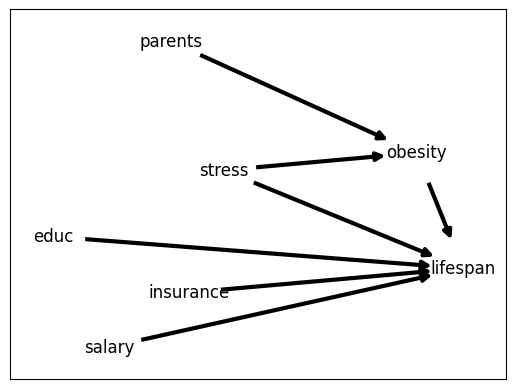

In [ ]:
# Визуализируем предполагаемые связи

# Стиль отображения графика
nx_options = {
    'node_color': 'white',
    'node_size': 2000,
    'width': 3,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}

# Связи
edges = [
    ('obesity', 'lifespan'),         # (откуда стрелочка, куда стрелочка)
    ('salary', 'lifespan'),
    ('educ', 'lifespan'),
    ('insurance', 'lifespan'),
    ('stress', 'lifespan'),
    ('stress', 'obesity'),
    ('parents', 'obesity'),

]

# Инициализируем граф
G = nx.DiGraph(directed = True)
G.add_edges_from(edges)

# Отображаем граф
np.random.seed(8)
nx.draw_networkx(G, arrows = True, **nx_options)

***3. Симулируйте данные в соответствии с предполагаемым вами процессом и приведите корреляционную матрицу, а также таблицу со следующими описательными статистиками:***

***• Для непрерывных переменных: выборочное среднее, выборочное стандартное отклонение, медиана, минимум и максимум.***

***• Для бинарных переменных: доля и количество единиц.***

***Указания:***

***• Необходимо сгенерировать не менее 1000 наблюдений.***

***• Доля единиц не должна быть меньше 0.1 ни для одной из бинарных переменных.***


In [ ]:
np.random.seed(1)
n = 10000

Будем генерировать зарплату $\text{salary}_{i}$ взяв за основу нормальное распределение $\text{N}\left(73, 20^2\right)$.

[Ежемесячная средняя зарплата по России в 2024 году, согласно председателю правительства Михаилу Мишустину](https://www.vedomosti.ru/economics/news/2024/04/03/1029715-mishustin-zayavil-chto-srednyaya-zarplata-v-rossii-73-000-rublei)

[Стандартное отклонение средних зарплат по регионам России в 2013-2021 годах находится в диапазоне 23-29 тысяч рублей](https://cyberleninka.ru/article/n/differentsiatsiya-zarabotnoy-platy-obuslovlennaya-neravenstvom-vozmozhnostey-v-rossiyskih-regionah/viewer). Для удобства дальнейших вычислений возьмем стандартное отклонение равное 20.

In [ ]:
# Предположим, что распределение зп схоже с нормальным
salary = norm.rvs(size = n, loc = 73, scale = 20, random_state = 1)

# Для красоты ограничим минимальные и максимальные значения
# salary[salary >= 60] = 60
salary[salary <= 10]  = 10

salary = np.round(salary)
print(salary[0:10])

[105.  61.  62.  52.  90.  27. 108.  58.  79.  68.]


Text(0, 0.5, 'Частотность')

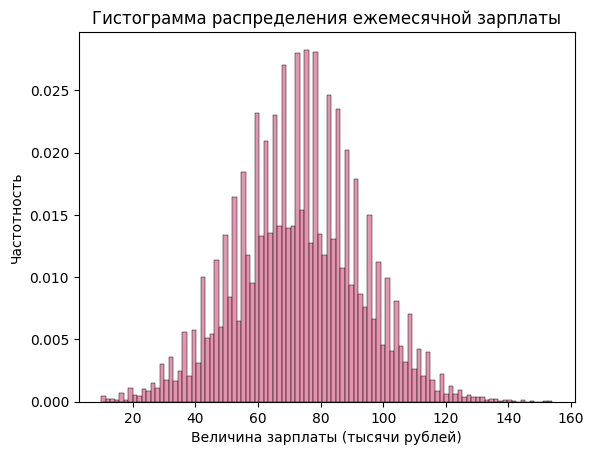

In [ ]:
seaborn.histplot(salary,                 # данные
                 stat = 'density',           # тип гистограммы
                 color = "palevioletred",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins = 100)                 # число столбиков в Гистограмме
plt.title("Гистограмма распределения ежемесячной зарплаты")
plt.xlabel("Величина зарплаты (тысячи рублей)")
plt.ylabel('Частотность')

Поскольку $\text{educ}_{i}$ является бинарной переменной, принимающей значения $0$ и $1$, то она имеет распределение Бернулли $\text{educ}_{i}\sim\text{Ber}(p)$. Предположим, что высшее образование есть у 30% населения страны, откуда $p=0.3$. [Статистика по России
](https://rg.ru/2021/06/15/kolichestvo-rossiian-s-vysshim-obrazovaniem-prevysilo-31-procent.html)

In [ ]:
np.random.seed(1)
educ = np.random.binomial(n = 1, p = 0.3, size = n)

# Посмотрим на первые несколько значение
print(np.mean(educ))

0.2951


По аналогии сгенерируем переменную на наличие ДМС, предполагая $\text{insurance}_{i}\sim\text{Ber}\left(0.17\right)$. [Статистика, подтверждающая, что только 17% российских компаний предоставляют ДМС работникам](https://www.banki.ru/news/lenta/?id=11000107#:~:text=%D0%9F%D0%BE%D0%BB%D0%B8%D1%81%D0%BE%D0%BC%20%D0%B4%D0%BE%D0%B1%D1%80%D0%BE%D0%B2%D0%BE%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%BC%D0%B5%D0%B4%D0%B8%D1%86%D0%B8%D0%BD%D1%81%D0%BA%D0%BE%D0%B3%D0%BE%20%D1%81%D1%82%D1%80%D0%B0%D1%85%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F%20(%D0%94%D0%9C%D0%A1,%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D1%8B%20%D0%B8%D1%81%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F%2C%20%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE%20%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D0%BE%D0%BC%20SuperJob.)

In [ ]:
np.random.seed(1)
insurance = np.random.binomial(n = 1, p = 0.17, size = n)
print(np.mean(insurance))

0.1669


**Генерация ненаблюдаемой переменной, порождающей эндогенность** 😸

Сгенерируем стресс  $\text{stress}_{i}$ взяв за основу распределение Стьюдента с $5$ степенями свободы.

Эта переменная будет играть ролль ненаблюдаемой, отсутствие в данных которой и приводит к проблеме эндогенности.

In [ ]:
stress = t.rvs(size = n, df = 5, random_state = 1)

# Приведем способности к более удобной шкале
stress = (stress) * 10 + 50

# Также, для удобства введем округление и возьмем модуль
stress = np.round(np.abs(stress) + 1)

# Для удобства ограничим максимальное и минимальное значения
stress[stress >= 100] = 100
stress[stress <= 1]   = 1

# Посмотрим на несколько первых значений
print(stress[0:10])

[73. 41. 42. 33. 55. 45. 47. 58. 48. 69.]


Text(0, 0.5, 'Частотность')

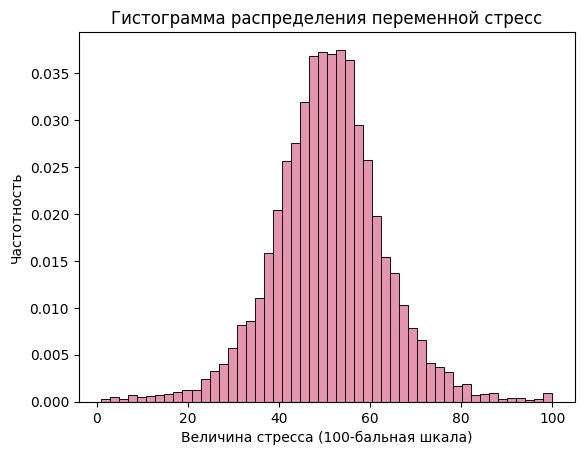

In [ ]:
seaborn.histplot(stress,                  # данные
                 stat  = 'density',          # тип гистограммы
                 color = "palevioletred",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins  = 50)
plt.title("Гистограмма распределения переменной стресс")
plt.xlabel("Величина стресса (100-бальная шкала)")
plt.ylabel('Частотность')

**Объяснение связи между стрессом (пропущенная переменная) и наличием ожирения (переменная воздействия):**

У находящегося в стрессовом состоянии человека большинство ресурсов его организма идет на борьбу с этим стрессом. Данный процесс истощает организм, требует притока быстрой энергии и снижает мотивацию заниматься спортом из-за ощущения слабости и нехватки сил. Все эти факторы повышают склонность человека к ожирению, которое создает дополнительную нагрузку на системы органов человека, ускоряя их износ и сокращая продолжительность жизни.

При этом из-за ожирения человек может подвергаться насмешкам в обществе, сталкиваться с проблемой неприятия себя и своего тела, сложностями в построении отношений с другими людьми. Также, когда у человека есть доступ к любой информации, он может начать слишком сильно переживать о том, как лишний вес влияет на его продолжительность и качество жизни, что приведет к моральному истощению и повышенной тревоге, препятствуя появлению адекватной реакции и поиску способов решения проблемы. Все эти факторы приводят к еще большему уровню стресса.

**Генерация инструментальной переменной** 😸

Для того, чтобы сгенерировать бинарную переменную как функцию от других переменных, необходимо сперва предположить форму условных вероятностей. Для этого удобно применять следующий алгоритм:

1.   Записать **индекс**, который отражает статистические связи инструментальной переменной с контрольными переменными.
2.   Сформировать условные вероятности взяв функцию распределения от этого индекса

Путем применения экономической логики предполагаем, что
1. Условная вероятность факта наличия ожирения у родителей отрицательно связана с наличием ДМС у ребенка, поскольку часто предоставляются в компаниях семейные ДМС, соответственно, как родители могут получать медицинскую помощь, будучи прикрепленными к ДМС детей, так и дети могут воспользоваться медицинскими услугами с помощью ДМС родителей.
2. Условная вероятность факта наличия ожирения у родителей отрицательно связана с наличием высшего образования у ребенка. Часто если у родителей есть высшее образование, то ребенок также его получит. Соответственно, родители с высшим образованием осознают важность ведения здорового образа жизни, отказа от вредных привычек, занятия спортом, что снижает риск наличия ожирения.
3. Условная вероятность факта наличия ожирения у родителей отрицательно связана с зарплатой ребенка, поскольку, как говорится в статье [“Ожирение: эпидемиологические и социально-экономические аспекты, профилактика”](https://endocrinology-journal.ru/ru/jarticles_endo/505.html?SSr=50013417f711ffffffff27c__07e30c170b321e-3d70), социально-экономический статус может в определенной мере ограничивать характер "продуктовой корзины", физической активности и других мероприятий по борьбе с лишней массой тела. В этом аспекте общее ожирение чаще выявляется у лиц с низким доходом или не имеющих работы. Родители с низким социально-экономическим статусом обычно не могут позволить дать ребенку хорошее образование и время на то, чтобы полноценно "встать на ноги". Поэтому дети вынуждены соглашаться на низкооплачиваемую работу, чтобы иметь возможность самостоятельно обеспечить себе хотя бы базовые потребности.


Таким образом, предполагаем, что условная вероятность факта наличия ожирения у родителей отрицательно связана с наличием ДМС, наличием высшего образования и зарплатой у ребенка:

$$\text{P}\left(\text{parents}_{i} = 1|\text{salary}_{i}, \text{educ}_{i}, \text{insurance}_{i}\right) = \Phi\left(\underbrace{\frac{-0.3 * \text{salary}_{i}}{ (6.5+\text{insurance}_{i} + \text{educ}_{i})} - \text{educ}_{i}\times\text{insurance}_{i} + 2.5}_{\text{индекс}}\right)$$

Где $\Phi()$ - функция распределения стандартного нормального распределения.

**Важно** - для удобства генерации рекомендуется предположить, что условные вероятности инструментальной переменной должны зависеть лишь от контрольных переменных.

In [ ]:
np.random.seed(1)
parents_index = -0.3* salary / (6.5 + insurance + educ) - insurance * educ + 2.5
parents_prob = norm.cdf(parents_index)

# Посмотрим на несколько первых условных вероятностей
print(parents_prob[0:10])
parents = np.random.binomial(n = 1, p = parents_prob, size = n)
print(parents[0:10])

[0.00948414 0.52392218 0.35884848 0.53982784 0.04907939 0.89505104
 0.00648457 0.42978441 0.12586575 0.26158664]
[0 0 0 1 0 1 0 0 0 0]


In [ ]:
# Дисперсия индекса должна быть +-1 (у нас все ок)
print(np.var(parents_index))

0.7976558161976106


Видим, что у трети людей родители c ожирением, что соотносится с реальностью. В исследовании ["Генетика ожирения: современное состояние проблемы"](https://www.mediasphera.ru/issues/profilakticheskaya-meditsina/2021/12/1230549482021121089
) авторы говорят о том, что около 40—70% межиндивидуальной вариабельности индекса массы тела (ИМТ) были отнесены к генетическим факторам.


In [ ]:
print(np.mean(parents))

0.283


**Генерация переменной воздействия** 😸


Удобно предположить, что условные вероятности переменной воздействия зависят от контрольных переменных, инструментальной переменной и ненаблюдаемой переменной.

Теоретические обоснования связей:
1. Чем выше уровень стресса, тем меньше человек спит, хуже качества его сна, повышается аппетит, снижается мотивация к занятию спортом, что приводит к увеличению массы тела и ожирению (Geiker N. R. W. et al. Does stress influence sleep patterns, food intake, weight gain, abdominal obesity and weight loss interventions and vice versa? //Obesity reviews. – 2018. – Т. 19. – №. 1. – С. 81-97). Поэтому переменная стресса входит с возрастающей функцией (логарифм).

2. Зависимость зарплаты и наличия ожирения могут быть представлены убывающей функцией. То есть при низкой зарплате человек, например, больше употребляет фаст-фуд, готовую еду, нет денежных средств на покупку абонемента в спортзал или дорогостоящего оборудования для занятия спортом дома. Но с увеличением зарплаты вероятность наличия ожирения падает, так как человек начинает питаться экологически чистыми, здоровыми продуктами, заниматься спортом, уделять больше внимания своему здоровью (Александрова Ю. Д., Колосницына М. Г. Проблема избыточного веса населения России: статистический анализ //Вопросы статистики. – 2018. – Т. 25. – №. 10. – С. 61-77).

3. Чем выше образование, тем больше человек понимает важность ведения здорового образа жизни: занятия спортом, здорового питания, качественного сна, отсутствия вредных привычек, тем меньше риск ожирения. Мы можем наблюдать подтверждение этому в статье ["Exploring the Relationship Between Education and Obesity"](https://www.researchgate.net/publication/227461329_Exploring_the_Relationship_Between_Education_and_Obesity
), где авторы приходят к выводу о том, что более качественное образование связано с меньшей вероятностью ожирения, особенно среди женщин. Поэтому переменная образования входит с минусом.

4. Наличие ДМС снижает вероятность наличия ожирения, поскольку человек более вероятно воспользуется медицинской помощью диетологов, сдаст дорогостоящие анализы, чтобы обнаружить первопричину возникновения данного заболевания.

5. Если у родителей человека есть ожирение, то скорее всего и у ребенка оно присутствует, поскольку предрасположенность к ожирению может передаваться генетически.

$$P(\text{obesity}_{i} = 1|\text{educ}_{i}, \text{salary}_{i}, \text{insurance}_{i}, \text{stress}_{i}, \text{parents}_{i}) = \\ = F_{\text{Logistic}}\left(4.5\times \ln\left(\text{stress}_{i} + 1\right) - \sqrt{\text{salary}_{i}} - \text{educ}_{i}\times\text{insurance}_{i} -11 + 3\times\text{parents}_{i}\right)$$

Где $F_{\text{Logistic}}$ - функция распределения стандартного логистического распределения.

Для краткости введем обозначение для условной вероятности наличия образования у индивида при конкретном образовании родителей:

$$p_{k}^{\text{parents}_{i}} = P(\text{obesity}_{i} = 1|\text{educ}_{i}, \text{salary}_{i}, \text{insurance}_{i}, \text{stress}_{i}, \text{parents}_{i} = k)\text{, где }k\in\{0,1\}$$

Для того, чтобы впоследствии анализировать локальные средние эффекты воздействия $\text{LATE}$, необходимо различать величину переменной воздействия $\text{obesity}_{i}$ в зависимости от значения инструмента $\text{parents}_{i}$. Для этого рассмотрим ни от чего не зависящую равномерную случайную величину $U_{i}\sim U(0,1)$ и введем гипотетические переменные:

$$\text{obesity}_{1i} = I(p_{1}^{\text{parents}_{i}}\geq U_{i})$$

$$\text{obesity}_{0i} = I(p_{0}^{\text{parents}_{i}}\geq U_{i})$$


$$I(\text{условие}) = \begin{cases}1\text{, если условие выполнено}\\0\text{, в противном случае}\end{cases}$$

Переменные $\text{obesity}_{1i}$ и $\text{obesity}_{0i}$ отражают потенциальные уровни образования индивида в зависимости от наличия образования у родителей.

In [ ]:
# Равномерные случайные величины
u = uniform.rvs(size = n)

# Сгенерируем часть индекса, не зависящую от образования родителей
obesity_index = 4.5* np.log(stress + 1) - np.sqrt(salary) - insurance * educ - 11

# Симулируем уровень образования индивидам в случае,
# когда у их родителей есть ожирение
parents1    = 1
obesity1_index = obesity_index + 3* parents1
obesity1_prob  = logistic.cdf(obesity1_index)
obesity1       = (obesity1_prob >= u).astype(int)

# Доля людей с ожирением в случае, когда у всех есть
# родители с ожирением
np.mean(obesity1)

0.6666

In [ ]:
# Симулируем ожирение индивидам в случае,
# когда у их родителей нет ожирения
parents0    = 0
obesity0_index = obesity_index + 3 * parents0
obesity0_prob  = logistic.cdf(obesity0_index, scale = 1)
obesity0       = (obesity0_prob >= u).astype(int)

np.mean(obesity0)

0.2013

Индивидов можно разделить на $4$ группы:


*   **Always takers** - те, у кого $\text{obesity}_{0i}=\text{obesity}_{1i}=1$: есть ожирение независимо от наличия ожирения у родителей.
*   **Never takers**- те, у кого $\text{obesity}_{0i}=\text{obesity}_{1i}=0$: нет ожирения независимо от факта наличия ожирения у родителей.
*   **Compliers** - те, у кого $\text{obesity}_{1i}=1$ и $\text{obesity}_{0i}=0$, то есть $\text{obesity}_{1i} > \text{obesity}_{0i}$: у них есть ожирение только, если оно есть у родителей
*   **Deniers** - те, у кого $\text{obesity}_{1i}=0$ и $\text{obesity}_{0i}=1$, то есть $\text{obesity}_{1i} < \text{obesity}_{0i}$: у них есть ожирение только, если у родителей его нет.

Для соблюдения предпосылок используемых методов важно отсутствие Deniers, что гарантируется используемым процессом генерации данных.

In [ ]:
# Рассмотрим различные группы индивидов
ind_type = np.empty(n, dtype = 'U25')
ind_type[(obesity1 == 1) & (obesity0 == 1)] = 'Always taker'
ind_type[(obesity1 == 0) & (obesity0 == 0)] = 'Never taker'
ind_type[obesity1 > obesity0]               = 'Complier'
ind_type[obesity1 < obesity0]               = 'Denier' #их не должно быть
compliers = obesity1 > obesity0

# Посмотрим на распределение индивидов разного типа
print(pd.value_counts(ind_type))

Complier        4653
Never taker     3334
Always taker    2013
Name: count, dtype: int64


In [ ]:
# Сравним наличие ожирения для одного и того же индивида в случаях,
# когда у его родителей нет ожирения и когда оно у них есть
print(pd.DataFrame(data    = np.array([obesity0, obesity1, ind_type]).transpose(),
                   columns = ['obesityc0', 'obesity1', 'Тип индивида']))

     obesityc0 obesity1  Тип индивида
0            0        0   Never taker
1            0        1      Complier
2            0        1      Complier
3            0        0   Never taker
4            0        1      Complier
...        ...      ...           ...
9995         1        1  Always taker
9996         0        1      Complier
9997         1        1  Always taker
9998         0        0   Never taker
9999         1        1  Always taker

[10000 rows x 3 columns]


Наблюдаемое (в данных) наличие факта ожирения у индивидов можно выразить как:

$$\text{obesity}_{i} = \begin{cases}\text{obesity}_{1i}\text{, если }\text{parents}_{i} = 1\\ \text{obesity}_{0i}\text{, если }\text{parents}_{i} = 0\end{cases} = \\ = \text{obesity}_{1i}\times\text{parents}_{i} + \text{obesity}_{0i}\times\left(1 - \text{parents}_{i}\right)$$

In [ ]:
# Факт наличия у индивида ожирения
obesity = obesity1 * parents + obesity0 * (1 - parents)

# Доли людей с ожирением
print(np.mean(obesity))

0.3301


**Важно**

*   При слабой корреляции между $\text{obesity}_{i}$ и $\text{stress}_{i}$ проблема эндогенности окажется несущественной, а при слишком большой скорректировать эндоенность окажется чрезвычайно сложно.
*   При слабой корреляции между $\text{obesity}_{i}$ и $\text{parents}_{i}$ инструмент не будет валидным и поэтому не позволит скорректировать эндогенность.

Таким образом, желательно сделать так, чтобы корреляции находились в некотором разумном диапазоне:

$$0.8\geq|\text{Corr}\left(\text{obesity}_{i}, \text{stress}_{i}\right)|\geq0.2$$

$$0.8\geq|\text{Corr}\left(\text{obesity}_{i}, \text{parents}_{i}\right)|\geq0.2$$

In [ ]:

# Рассмотрим корреляции
print(pd.DataFrame(data    = [np.corrcoef(obesity, stress)[0, 1],
                              np.corrcoef(obesity, parents)[0, 1]],
                   index   = ['Corr(obesity, stress)',
                              'Corr(obesity, parents)'],
                   columns = ['Оценка']))

                          Оценка
Corr(obesity, stress)   0.238731
Corr(obesity, parents)  0.589547


Видим, что на сгенерированных данных возникает проблема эндогенности, а инструмент релевантен, так как имеет сильную корреляцию с переменной воздействия

**Генерация целевой переменной** 😸


Сформируем представления о формировании потенциальной продолжительности жизни в зависимости от наличия ожирения.

Уравнение  продолжительность жизни при отсутствии ожирения

$$\text{lifespan}_{0i} = \underbrace{\underbrace{ -0.8\times\text{stress}_{i}}_{g_{0}^{\text{unobs}}} + \underbrace{51 + 14\times\frac{\text{salary}_{i}}{16 - \text{educ}_{i} - \text{insurance}_{i}}}_{g_{0}^{\text{obs}}}}_{g_{0}} + \varepsilon_{0i}\text{, где }\varepsilon_{0i}\sim \left(10\times t(15)\right)$$

Уравнение  продолжительность жизни при наличии ожирения:

$$\text{lifespan}_{1i} = \underbrace{\underbrace{-0.9\times\text{stress}_{i}}_{g_{1}^{\text{unobs}}} + \underbrace{51 + 13\times \frac{\text{salary}_{i}}{15 - \text{educ}_{i} - \text{insurance}_{i}}}_{g_{1}^{\text{obs}}}}_{g_{1}} + \varepsilon_{1i}\text{, где }\varepsilon_{1i}\sim \left(\text{EXP}(0.1) - 10\right)$$

Наблюдаемая продолжительность жизни

$$\text{lifespan}_{i} = \begin{cases}\text{lifespan}_{1i}\text{, если }\text{obesity}_{i}=1\\ \text{lifespan}_{0i}\text{, если }\text{obesity}_{i}=0\end{cases} = \\ =\text{lifespan}_{1i}\times\text{obesity}_{i} + \text{lifespan}_{0i}\times\left(1-\text{obesity}_{i}\right)$$

In [ ]:

error0 = t.rvs(size = n, df = 7, random_state = 10) * 10
error1 = expon.rvs(size = n, scale = 10, random_state = 10) - 10
# Функция от контрольных переменных
  # когда у индивида нет ожирения
g0_obs   = 51 + 12 * salary / (16 - insurance - educ)
g0_unobs =  -0.8 * stress
g0       = g0_obs + g0_unobs
  # когда у индивида есть ожирение
g1_obs   =  51 + 11 * salary / (15 - insurance - educ)
g1_unobs = - 0.9 * stress
g1       = g1_obs + g1_unobs
lifespan0 = g0 + error0
lifespan1 = g1 + error1

lifespan = lifespan1 * obesity + lifespan0 * (1 - obesity)

Во избежание чрезвычайно точных или крайне неточных оценок, желательно, чтобы при каждом $j\in\{0, 1\}$ дисперсии $\varepsilon_{ji}$, $g_{j}$, $g_{j}^{\text{obs}}$ и  $g_{j}^{\text{unobs}}$ различались не более, чем в $5$ раз.

In [ ]:
# Приблизительно оценим адекватность дисперсий,не отличаются дисперсии более,чем в 5 раз, все хорошо
print(pd.DataFrame(data    = [np.var(error0),   np.var(g0),
                              np.var(g0_obs),   np.var(g0_unobs),
                              np.var(error1),   np.var(g1),
                              np.var(g1_obs),   np.var(g1_unobs)],
                   index   = ['Var(eps0)',     'Var(g0)',
                              'Var(g0_obs)',   'Var(g0_unobs)',
                              'Var(eps1)',     'Var(g1)',
                              'Var(g1_obs)',   'Var(g1_unobs)'],
                   columns = ['Оценка']))

                   Оценка
Var(eps0)      136.134699
Var(g0)        349.113400
Var(g0_obs)    248.779985
Var(g0_unobs)   96.102928
Var(eps1)       99.733174
Var(g1)        366.777902
Var(g1_obs)    240.377275
Var(g1_unobs)  121.630268


**Объединение данных** 😸

In [ ]:
# Аггрегируем данные в датафрейм
df = pd.DataFrame({'lifespan': lifespan, 'obesity': obesity,
                   'salary': salary, 'educ': educ,
                   'insurance': insurance,'parents': parents})
df = df.loc[0:n, :]

# Посмотрим на симулированные данные
df.head(10).style.format(precision = 2)

,lifespan,obesity,salary,educ,insurance,parents
0,82.94,0,105.00,0,0,0
1,58.63,0,61.00,1,0,0
2,66.61,0,62.00,0,0,0
3,77.77,0,52.00,0,0,1
4,66.71,0,90.00,0,0,0
5,22.85,1,27.00,0,0,1
6,116.30,0,108.00,0,0,0
7,77.97,0,58.00,0,0,0
8,79.70,0,79.00,0,0,0
9,29.69,1,68.00,0,0,0


In [ ]:
corr_matrix = df.corr()
print("Корреляционная матрица:")
print(corr_matrix)

Корреляционная матрица:
           lifespan   obesity    salary      educ  insurance   parents
lifespan   1.000000 -0.555749  0.722420  0.120906   0.116816 -0.364163
obesity   -0.555749  1.000000 -0.506150  0.112309   0.068471  0.589547
salary     0.722420 -0.506150  1.000000  0.001598   0.002585 -0.518738
educ       0.120906  0.112309  0.001598  1.000000   0.691765  0.352823
insurance  0.116816  0.068471  0.002585  0.691765   1.000000  0.323674
parents   -0.364163  0.589547 -0.518738  0.352823   0.323674  1.000000


При генерации зависимой переменной возникают все-таки отрицательные значения, даже при большой взятой константе в $g_{0}^{\text{obs}}$. Однако у нас всего 12 отрицательных значений для lifespan при 10000 сгенерированных наблюдений, следовательно, это не должно сильно повлиять на полученные результаты

In [ ]:
df[df['lifespan'] < 0].shape

(12, 6)

In [ ]:
continuous_cols = ['lifespan',  'salary']
binary_cols = ['educ', 'insurance', 'parents', 'obesity']

continuous_stats = df[continuous_cols].describe()
print("\nОписательные статистики для непрерывных переменных:")
print(continuous_stats)

binary_stats = df[binary_cols].agg(['mean', 'sum'])
print("\nОписательные статистики для бинарных переменных:")
print(binary_stats)


Описательные статистики для непрерывных переменных:
           lifespan        salary
count  10000.000000  10000.000000
mean      64.919239     73.200400
std       23.348602     19.975479
min      -32.508402     10.000000
25%       48.769421     60.000000
50%       65.065600     73.000000
75%       80.777093     86.000000
max      152.052020    154.000000

Описательные статистики для бинарных переменных:
           educ  insurance   parents    obesity
mean     0.2951     0.1669     0.283     0.3301
sum   2951.0000  1669.0000  2830.000  3301.0000


Заметим, что доля единиц для всех бинарных переменных больше 0.1, что позволит в дальнейшем получить корректные результаты. Кроме того, среднее значение целевой переменной равно 64.9, что соотносится с реальной ситуацией в России ([Данные по средней продолжительности жизни в России](https://rshbins-life.ru/news/blog/srednyaya-prodolzhitelnost-zhizni-muzhchin-v-rossii-2022-2023-god/)). Также значния 25% и 75% квантилей (48.7 и 80.7 соответственно) адекватны, значит, сгенерированные наблюдения по целевой переменной корректны. Для заработной платы также получили адекватные значения средней ежемесячной зарплаты - 73 (тысяч рублей) ([Подтверждающая статистика](https://www.vedomosti.ru/economics/news/2024/04/03/1029715-mishustin-zayavil-chto-srednyaya-zarplata-v-rossii-73-000-rublei)).


***4. Разделите выборку на обучающую и тестовую. Тестовая выборка должна включать от 20% до 30% наблюдений.***

In [ ]:
X = df.drop('lifespan', axis = 1)
y = df['lifespan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 3. Классификация

В каждом из следующих заданий будем использовать заданий в качестве методов классификации метод ближайших соседей, случайный лес, градиентный бустинг и логистическую регрессию.

***1. Отберите признаки, которые могут быть полезны при прогнозировании переменной воздействия и кратко обоснуйте выбор каждой из них. Не включайте в
число этих признаков целевую переменную***

Переменная воздействия стала целевой переменной. В качестве объясняющих переменных будут выступать признаки: salary, educ, parents, поскольку они имеют корреляцию по модулю с obesity (переменная воздействия) больше 0.1. Кроме того, выбор данных переменных соответствует экономической логике:

1. Зависимость зарплаты и наличия ожирения есть, и она отрицательна. То есть при низкой зарплате человек, например, больше употребляет фаст-фуд, готовую еду, нет денежных средств на покупку абонемента в спортзал или дорогостоящего оборудования для занятия спортом дома. Но с увеличением зарплаты вероятность наличия ожирения падает, так как человек начинает питаться экологически чистыми, здоровыми продуктами, заниматься спортом, уделять больше внимания своему здоровью (Александрова Ю. Д., Колосницына М. Г. Проблема избыточного веса населения России: статистический анализ //Вопросы статистики. – 2018. – Т. 25. – №. 10. – С. 61-77).

2. Чем выше образование, тем больше человек понимает важность ведения здорового образа жизни: занятия спортом, здорового питания, качественного сна, отсутствия вредных привычек, тем меньше риск ожирения.

3. Если у родителей человека есть ожирение, то скорее всего и у ребенка оно присутствует, поскольку предрасположенность к ожирению может передаваться генетически. В исследовании ["Генетика ожирения: современное состояние проблемы"](https://www.mediasphera.ru/issues/profilakticheskaya-meditsina/2021/12/1230549482021121089
) авторы говорят о том, что около 40—70% межиндивидуальной вариабельности индекса массы тела (ИМТ) были отнесены к генетическим факторам.

In [ ]:
train_ob = X_train['obesity']
test_ob = X_test['obesity']
X_train_ob = X_train.drop(['obesity', 'insurance'], axis=1)
X_test_ob = X_test.drop(['obesity', 'insurance'], axis=1)
X_test_ob.head()

,salary,educ,parents
6252,87.0,0,0
4684,76.0,1,1
1731,94.0,1,0
4742,103.0,0,0
4521,58.0,0,0


In [ ]:
train_ob.value_counts()/len(train_ob)

obesity
0    0.670125
1    0.329875
Name: count, dtype: float64

In [ ]:
test_ob.value_counts()/len(test_ob)

obesity
0    0.669
1    0.331
Name: count, dtype: float64

Видим, что немного наблюдается дисбаланс классов в целевой переменной, но он не критичен.

***2.. Выберите произвольные значения гиперпараметров, а затем оцените и сравните
(между методами) точность прогнозов:
• на обучающей выборке.
• на тестовой выборке.
• с помощью кросс-валидации (используйте только обучающую выборку).***

Отметим, что единственный признак, являющийся непрерывным в данном разделе - зарплата, но ее максимальное значение 152, что не должно привести к некорректным прогнозам в силу отличия в масштабах данных. Однако на начальном этапе попробуем сравнить разницу в точности прогнозов для данных с и без нормировки. Для нормировки даннных используем MinMaxSclaler, который приведет данные к диапазону от 0 до 1 путем вычитания из конкретного значения минимального значения по переменной деленную на разницу между максимальным и минимальным значением по переменной.

In [ ]:
from sklearn import preprocessing
scal = preprocessing.MinMaxScaler()
X_train_ob_1 = scal.fit_transform(X_train_ob)
X_test_ob_1 = scal.transform(X_test_ob)

In [ ]:
X_test_ob_1

array([[0.53472222, 0.        , 0.        ],
       [0.45833333, 1.        , 1.        ],
       [0.58333333, 1.        , 0.        ],
       ...,
       [0.60416667, 0.        , 0.        ],
       [0.38888889, 0.        , 0.        ],
       [0.54166667, 0.        , 0.        ]])

In [ ]:
lr_model = LogisticRegression(C=1.0)
lr_model.fit(X_train_ob_1, train_ob)
lr_train_pred = lr_model.predict(X_train_ob_1)
lr_test_pred = lr_model.predict(X_test_ob_1)
lr_cv_scores = cross_val_score(lr_model, X_train_ob_1, train_ob, cv=4)

knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train_ob_1, train_ob)
knn_train_pred = knn_model.predict(X_train_ob_1)
knn_test_pred = knn_model.predict(X_test_ob_1)
knn_cv_scores = cross_val_score(knn_model, X_train_ob_1, train_ob, cv=4)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_model.fit(X_train_ob_1, train_ob)
rf_train_pred = rf_model.predict(X_train_ob_1)
rf_test_pred = rf_model.predict(X_test_ob_1)
rf_cv_scores = cross_val_score(rf_model, X_train_ob_1, train_ob, cv=4)

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb_model.fit(X_train_ob_1, train_ob)
gb_train_pred = gb_model.predict(X_train_ob_1)
gb_test_pred = gb_model.predict(X_test_ob_1)
gb_cv_scores = cross_val_score(gb_model, X_train_ob_1, train_ob, cv=4)

gb_train_accuracy = accuracy_score(train_ob, gb_train_pred)
gb_test_accuracy = accuracy_score(test_ob, gb_test_pred)
gb_cv_accuracy = gb_cv_scores.mean()

rf_train_accuracy = accuracy_score(train_ob, rf_train_pred)
rf_test_accuracy = accuracy_score(test_ob, rf_test_pred)
rf_cv_accuracy = rf_cv_scores.mean()

lr_train_accuracy = accuracy_score(train_ob, lr_train_pred)
lr_test_accuracy = accuracy_score(test_ob, lr_test_pred)
lr_cv_accuracy = lr_cv_scores.mean()

knn_train_accuracy = accuracy_score(train_ob, knn_train_pred)
knn_test_accuracy = accuracy_score(test_ob, knn_test_pred)
knn_cv_accuracy = knn_cv_scores.mean()

In [ ]:
print("Точность бустинга:")
print("Обучающая выборка:", gb_train_accuracy)
print("Тестовая выборка:", gb_test_accuracy)
print("Точность с помощью кросс-валидации:", gb_cv_accuracy)
print("\n")

print("Точность случайного леса:")
print("Обучающая выборка:", rf_train_accuracy)
print("Тестовая выборка:", rf_test_accuracy)
print("Точность с помощью кросс-валидации:", rf_cv_accuracy)
print("\n")

print("Точность  логрегрессии:")
print("Обучающая выборка:", lr_train_accuracy)
print("Тестовая выборка:", lr_test_accuracy)
print("Точность с помощью кросс-валидации:", lr_cv_accuracy)
print("\n")

print("Точность knn:")
print("Обучающая выборка:", knn_train_accuracy)
print("Тестовая выборка:", knn_test_accuracy)
print("Точность с помощью кросс-валидации:", knn_cv_accuracy)

Точность бустинга:
Обучающая выборка: 0.829625
Тестовая выборка: 0.826
Точность с помощью кросс-валидации: 0.823375


Точность случайного леса:
Обучающая выборка: 0.8325
Тестовая выборка: 0.8185
Точность с помощью кросс-валидации: 0.823375


Точность  логрегрессии:
Обучающая выборка: 0.827625
Тестовая выборка: 0.8265
Точность с помощью кросс-валидации: 0.82775


Точность knn:
Обучающая выборка: 0.811375
Тестовая выборка: 0.788
Точность с помощью кросс-валидации: 0.803375


In [ ]:
lr_model = LogisticRegression(C=1.0)
lr_model.fit(X_train_ob, train_ob)
lr_train_pred = lr_model.predict(X_train_ob)
lr_test_pred = lr_model.predict(X_test_ob)
lr_cv_scores = cross_val_score(lr_model, X_train_ob, train_ob, cv=4)

knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train_ob, train_ob)
knn_train_pred = knn_model.predict(X_train_ob)
knn_test_pred = knn_model.predict(X_test_ob)
knn_cv_scores = cross_val_score(knn_model, X_train_ob, train_ob, cv=4)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_model.fit(X_train_ob, train_ob)
rf_train_pred = rf_model.predict(X_train_ob)
rf_test_pred = rf_model.predict(X_test_ob)
rf_cv_scores = cross_val_score(rf_model, X_train_ob, train_ob, cv=4)

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb_model.fit(X_train_ob, train_ob)
gb_train_pred = gb_model.predict(X_train_ob)
gb_test_pred = gb_model.predict(X_test_ob)
gb_cv_scores = cross_val_score(gb_model, X_train_ob, train_ob, cv=4)

gb_train_accuracy = accuracy_score(train_ob, gb_train_pred)
gb_test_accuracy = accuracy_score(test_ob, gb_test_pred)
gb_cv_accuracy = gb_cv_scores.mean()

rf_train_accuracy = accuracy_score(train_ob, rf_train_pred)
rf_test_accuracy = accuracy_score(test_ob, rf_test_pred)
rf_cv_accuracy = rf_cv_scores.mean()

lr_train_accuracy = accuracy_score(train_ob, lr_train_pred)
lr_test_accuracy = accuracy_score(test_ob, lr_test_pred)
lr_cv_accuracy = lr_cv_scores.mean()

knn_train_accuracy = accuracy_score(train_ob, knn_train_pred)
knn_test_accuracy = accuracy_score(test_ob, knn_test_pred)
knn_cv_accuracy = knn_cv_scores.mean()

In [ ]:
print("Точность бустинга:")
print("Обучающая выборка:", gb_train_accuracy)
print("Тестовая выборка:", gb_test_accuracy)
print("Точность с помощью кросс-валидации:", gb_cv_accuracy)
print("\n")

print("Точность случайного леса:")
print("Обучающая выборка:", rf_train_accuracy)
print("Тестовая выборка:", rf_test_accuracy)
print("Точность с помощью кросс-валидации:", rf_cv_accuracy)
print("\n")

print("Точность  логрегрессии:")
print("Обучающая выборка:", lr_train_accuracy)
print("Тестовая выборка:", lr_test_accuracy)
print("Точность с помощью кросс-валидации:", lr_cv_accuracy)
print("\n")

print("Точность knn:")
print("Обучающая выборка:", knn_train_accuracy)
print("Тестовая выборка:", knn_test_accuracy)
print("Точность с помощью кросс-валидации:", knn_cv_accuracy)

Точность бустинга:
Обучающая выборка: 0.829625
Тестовая выборка: 0.826
Точность с помощью кросс-валидации: 0.8231249999999999


Точность случайного леса:
Обучающая выборка: 0.8325
Тестовая выборка: 0.8185
Точность с помощью кросс-валидации: 0.823625


Точность  логрегрессии:
Обучающая выборка: 0.827125
Тестовая выборка: 0.827
Точность с помощью кросс-валидации: 0.82775


Точность knn:
Обучающая выборка: 0.797625
Тестовая выборка: 0.787
Точность с помощью кросс-валидации: 0.808125


Сравнение точности прогнозов при произвольно подобранных гиперпараметрах:
- Во первых, видим, что практически нет отличий в точности прогнозов при использовании отмасштабированных данных и без нормирования (единственные различия наблюдаются у knn, поскольку данный метод очень чувствителен к масштабу данных, но он в то же время является наиболее простым из используемых, что дает предположение, что его прогнозы будут одними из худших) . Соответственно, нормирование данных не играет особой роли в нашем случае (так как подразумеваем, что измеряем зарплату не в рублях, а тысячах рублей), в дальнейшем будем использовать данные без нормирования.
- Во-вторых, модели не переобучены, так как значения accuracy на тестовой и обучающей выборках примерно совпадают.
- На обучающей выборке точность прогнозов при использовании метрики качества accuracy показал случайный лес (0.8325). На втором месте по точности прогнозов на обучающей выборке - градиентный бустинг (0.8296). Худший по точности прогнозы на обучающей выборке показал метод ближайших соседей (0.797).
- Наибольшую точность прогнозов на тестовой выборке при использовании метрики качества accuracy показала логистическая регрессия (0.827). На втором месте по точности - градиентный бустинг (0.826). Худший по точности прогнозы показал метод ближающих соседей (0.787).

- По кросс-валидации с 4 фолдами наибольшие средние значения accuracy у логистической регрессии, затем идут грудиентный бустинг,  случайный лес и метод ближайших соседей.

***3. Для каждого метода с помощью кросс-валидации на обучающей выборке подберите оптимальные значения гиперпараметров (тюнинг). В качестве критерия
качества используйте точность ACC.***

***Проинтерпретируйте полученные результаты и далее используйте методы с подобранными значениями гиперпараметров.
Повышенная сложность: подберите на обучающей выборке оптимальные
значения гиперпараметров случайного леса ориентируясь на значение OOB
(out-of-bag) ошибки. Сопоставьте гиперпараметры и точность на тестовой выборке для случайного леса в зависимости от того, используется кросс-валидация
или OOB ошибка. Объясните преимущество OOB ошибки по сравнению с кроссвалидацей.***

In [ ]:
param_grid_lr = {'C': [0.01, 0.1, 1.0, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring = 'accuracy', cv=4)
grid_search_lr.fit(X_train_ob, train_ob)
best_lr_params = grid_search_lr.best_params_
best_lr_cv_score = grid_search_lr.best_score_
best_lr_test_score = grid_search_lr.score(X_test_ob, test_ob)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring = 'accuracy', cv=4)
grid_search_knn.fit(X_train_ob, train_ob)
best_knn_params = grid_search_knn.best_params_
best_knn_cv_score = grid_search_knn.best_score_
best_knn_test_score = grid_search_knn.score(X_test_ob, test_ob)

param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring = 'accuracy', cv=4)
grid_search_rf.fit(X_train_ob, train_ob)
best_rf_params = grid_search_rf.best_params_
best_rf_cv_score = grid_search_rf.best_score_
best_rf_test_score = grid_search_rf.score(X_test_ob, test_ob)

param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring = 'accuracy', cv=4)
grid_search_gb.fit(X_train_ob, train_ob)
best_gb_params = grid_search_gb.best_params_
best_gb_cv_score = grid_search_gb.best_score_
best_gb_test_score = grid_search_gb.score(X_test_ob, test_ob)

In [ ]:
results = {
    'Method': ['Logistic Regression', 'KNN', 'RF', 'GBoosting'],
    'Original Hyperparameters': ['C=1.0', 'n_neighbors=4', ['n_estimators=100', 'max_depth=10'], 'n_estimators=100, learning_rate=0.1'],
    'Tuned Hyperparameters': [f'C={best_lr_params["C"]}', f'n_neighbors={best_knn_params["n_neighbors"]}', f'n_estimators={best_rf_params["n_estimators"]}, max_depth={best_rf_params["max_depth"]}', f'n_estimators={best_gb_params["n_estimators"]}, learning_rate={best_gb_params["learning_rate"]}'],
    'CV Accuracy (Original)': [lr_cv_scores.mean(), knn_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean()],
    'CV Accuracy (Tuned)': [best_lr_cv_score, best_knn_cv_score, best_rf_cv_score, best_gb_cv_score],
    'Test Accuracy (Original)': [lr_model.score(X_test_ob, test_ob), knn_model.score(X_test_ob, test_ob), rf_model.score(X_test_ob, test_ob), gb_model.score(X_test_ob, test_ob)],
    'Test Accuracy (Tuned)': [best_lr_test_score, best_knn_test_score, best_rf_test_score, best_gb_test_score]}

results_df = pd.DataFrame(results)
(results_df)

,Method,Original Hyperparameters,Tuned Hyperparameters,CV Accuracy (Original),CV Accuracy (Tuned),Test Accuracy (Original),Test Accuracy (Tuned)
0,Logistic Regression,C=1.0,C=1.0,0.827750,0.827750,0.8270,0.8270
1,KNN,n_neighbors=4,n_neighbors=7,0.808125,0.817875,0.7870,0.8090
2,RF,"[n_estimators=100, max_depth=10]","n_estimators=100, max_depth=5",0.823625,0.826625,0.8185,0.8235
3,GBoosting,"n_estimators=100, learning_rate=0.1","n_estimators=50, learning_rate=0.05",0.823125,0.825750,0.8260,0.8225


Интерпретация результатов:

1. Логистическая регрессия. В качестве гиперпараметров подбирали C - коэффициент регуляризации. Дефолтное значение оказалось наилучшим при подборе по решетке с 4 фолдами. Соответственно, точность до и после тюнинга не изменились и на тесте логистическая регрессия все еще является лучшей по метрике качества ACC.

2. Метод ближающих соседей. После тюнинга параметри количества соседей стал равен 7. Это позволило улучшить точность прогнозов как на кросс-валидации, так и на тесте. Однако knn все еще хуже других моделей делает прогнозы.

3. Случайный лес. В качестве гиперпараметров на решетке подбирали число деревьев и макисмальную глубину дерева. Число деревьев после тюнинга осталось таким же как и при произвольном подборе гиперпараметров (n_estimators = 100), максимальная глубина деревьев стала 5 после тюнинга. Подбор оптимальных гиперпараметров позволил улучшить точность прогнозов случайного леса на тестовой выборке (было 0.8185, стало 0.8235) и на кросс-валидации. И после тюнинга случайный лес обогнал по точности прогнозов на тестовой выборке градиентный бустинг.

4. Градиентный бустинг. После тюнинга гиперпараметры стали следующими: число деревьев = 50, learning_rate (шаг обучения) - 0.05. Однако на тестовой выборке это привело к снижению точности прогнозов на тестовой выборке (было ACC = 0.826, стало ACC = 0.8225). Возможно, это произошло из-за склонности градиентного бустинга к переобучению.

После тюнинга на тестовой выборке лучшая по точности прогнозов модель - логистическая регрессия, на втором - случайный лес, потом градиентный бустинг, худшая по точности прогноза - метод ближайших соседей

In [ ]:
#повышенная сложность
rf = RandomForestClassifier(oob_score=True)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [ 5, 10, 20],
    #'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=4)

grid_search.fit(X_train_ob, train_ob)

best_params = grid_search.best_params_
oob_score = grid_search.best_estimator_.oob_score_

best_rf_model = grid_search.best_estimator_
test_accuracy = best_rf_model.score(X_test_ob, test_ob)

print("Лучшие параметры случайного леса:")
print(best_params)
print("OOB оценка: ", oob_score)
print("Точность на тестовой выборке с лучшими параметрами: ", test_accuracy)


Лучшие параметры случайного леса:
{'max_depth': 5, 'n_estimators': 100}
OOB оценка:  0.823875
Точность на тестовой выборке с лучшими параметрами:  0.823


- Гиперпараметры. Видим, что гиперпараметры максимальная глубина дерева, количество деревьев совпали при тюнинге с использованием кросс-валидации и OOB ошибки. Гиперпараметр min_samples_leaf после тюнинга остался с дефолтным значением равным 2.
- Точность на тестовой выборке не изменилась при использовании OOB ошибки вместо кросс-валидации, посколько подобранные гиперпараметры совпали.

- Преимущество OOB ошибки по сравнению с кроссвалидацей.
Преимущество OOB ошибки по сравнению с кросс-валидацией заключается в его большей быстроте определения прогностических способностей ансамблей. Также при использовании OOB ошибки можем не откладывать отдельно валидационную выборку для подбора гиперпараметров.

***4. Повторите предыдущий пункт, используя любой альтернативный критерий качества модели. Обоснуйте возможные преимущества и недостатки этого альтернативного критерия.***

В качестве альтернативного критерия качества модели использовали F1-score.

Преимущества:
- По сравнению с ACC F1-score учитывает дисбаланс классов.
- Обращает внимание на точность положительных прогнозов и фактически положительных записей.
- Легкость интерпретации
- Данная метрика является средним гармоническим recall и precision, по ней можно подобрать оптимальный порог отсечения.

Минусы:
- F1-score сложно оптимизировать, потому что для этого нужно добиваться высокой полноты и точности одновременно.


In [ ]:
from sklearn.metrics import f1_score
lr_cv_scores_f = cross_val_score(lr_model, X_train_ob, train_ob, cv=4, scoring = 'f1')
knn_cv_scores_f = cross_val_score(knn_model, X_train_ob, train_ob, cv=4, scoring = 'f1')
rf_cv_scores_f = cross_val_score(rf_model, X_train_ob, train_ob, cv=4, scoring = 'f1')
gb_cv_scores_f = cross_val_score(gb_model, X_train_ob, train_ob, cv=4, scoring = 'f1')

gb_test_f = f1_score(test_ob, gb_test_pred)
rf_test_f = f1_score(test_ob, rf_test_pred)
lr_test_f = f1_score(test_ob, lr_test_pred)
knn_test_f = f1_score(test_ob, knn_test_pred)

In [ ]:
param_grid_lr = {'C': [0.01, 0.1, 1.0, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring = 'f1', cv=4)
grid_search_lr.fit(X_train_ob, train_ob)
best_lr_params = grid_search_lr.best_params_
best_lr_cv_score = grid_search_lr.best_score_
best_lr_test_score = grid_search_lr.score(X_test_ob, test_ob)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring = 'f1', cv=4)
grid_search_knn.fit(X_train_ob, train_ob)
best_knn_params = grid_search_knn.best_params_
best_knn_cv_score = grid_search_knn.best_score_
best_knn_test_score = grid_search_knn.score(X_test_ob, test_ob)

param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring = 'f1', cv=4)
grid_search_rf.fit(X_train_ob, train_ob)
best_rf_params = grid_search_rf.best_params_
best_rf_cv_score = grid_search_rf.best_score_
best_rf_test_score = grid_search_rf.score(X_test_ob, test_ob)

param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring = 'f1', cv=4)
grid_search_gb.fit(X_train_ob, train_ob)
best_gb_params = grid_search_gb.best_params_
best_gb_cv_score = grid_search_gb.best_score_
best_gb_test_score = grid_search_gb.score(X_test_ob, test_ob)

In [ ]:
results = {
    'Method': ['Logistic Regression', 'KNN', 'RF', 'GBoosting'],
    'Original Hyperparameters': ['C=1.0', 'n_neighbors=4', ['n_estimators=100', 'max_depth=10'], 'n_estimators=100, learning_rate=0.1'],
    'Tuned Hyperparameters': [f'C={best_lr_params["C"]}', f'n_neighbors={best_knn_params["n_neighbors"]}', f'n_estimators={best_rf_params["n_estimators"]}, max_depth={best_rf_params["max_depth"]}', f'n_estimators={best_gb_params["n_estimators"]}, learning_rate={best_gb_params["learning_rate"]}'],
    'CV F1 (Original)': [lr_cv_scores_f.mean(), knn_cv_scores_f.mean(), rf_cv_scores_f.mean(), gb_cv_scores_f.mean()],
    'CV F1 (Tuned)': [best_lr_cv_score, best_knn_cv_score, best_rf_cv_score, best_gb_cv_score],
    'Test F1 (Original)': [lr_test_f, knn_test_f, rf_test_f , gb_test_f ],
    'Test F1 (Tuned)': [best_lr_test_score, best_knn_test_score, best_rf_test_score, best_gb_test_score]}

results_df = pd.DataFrame(results)
(results_df)

,Method,Original Hyperparameters,Tuned Hyperparameters,CV F1 (Original),CV F1 (Tuned),Test F1 (Original),Test F1 (Tuned)
0,Logistic Regression,C=1.0,C=1.0,0.713753,0.713753,0.717781,0.717781
1,KNN,n_neighbors=4,n_neighbors=7,0.654856,0.691149,0.635897,0.686371
2,RF,"[n_estimators=100, max_depth=10]","n_estimators=150, max_depth=5",0.703620,0.705148,0.697248,0.711586
3,GBoosting,"n_estimators=100, learning_rate=0.1","n_estimators=150, learning_rate=0.05",0.703081,0.706380,0.714754,0.713700


Интерпретация результатов:

- Логистическая регрессия. В качестве гиперпараметров подбирали C - коэффициент регуляризации. Дефолтное значение оказалось наилучшим при подборе по решетке с 4 фолдами. Видим, что F1-score не поменялась, но при этом заметим, что значение f1-меры на тесте оказалось ниже, чем у ACC. Возможно, из-за плохой идентификации TP (уменьшение TP), увеличения FP или FN.

- Метод ближающих соседей. После тюнинга параметри количества соседей стал равен 7, как и при использовании метрики качества ACC. Это позволило улучшить точность прогнозов как на кросс-валидации, так и на тесте. Однако knn все еще хуже других моделей делает прогнозы.

- Случайный лес. В качестве гиперпараметров на решетке подбирали число деревьев и макисмальную глубину дерева. Число деревьев после тюнинга стало равно 150, максимальная глубина деревьев - 5 после тюнинга. Подбор оптимальных гиперпараметров позволил улучшить точность прогнозов случайного леса на тестовой выборке (было 0.698, стало 0.709) и на кросс-валидации.

- Градиентный бустинг. После тюнинга гиперпараметры стали следующими: число деревьев = 150, learning_rate (шаг обучения) - 0.05. Однако на тестовой выборке это привело к снижению точности прогнозов на тестовой выборке (было F1 = 0.71475, стало F1 = 0.7137). Возможно, это произошло из-за склонности градиентного бустинга к переобучению, такая же ситуации произошла и в прошлом пункте при использовании ACC в качестве метрики.

На тесте лучшую точность прогноза показала логистическая регрессия, на втором месте - градиентный бустинг, потом случайный лес, худшая тосность у метода ближайших соседей.

***4. Повышенная сложность: дополнительно самостоятельно запрограммируйте
4
не представленный в стандартных библиотеках критерий качества и используйте его для тюнинга гиперпараметров. Сравните результат стандартного и
вашего критериев.***

В качестве стандартного критерия используем ACC.

Первая метрика - индекс Джини. Это метрика пропорциональная ROC-AUC, которая является площадью между ROC-кривой и диагональю, соединяющей точки (0,0).

In [ ]:
def gini(y, pred_proba):
    auc = metrics.roc_auc_score(y, pred_proba)
    return (2*auc - 1)
gini_scorer = make_scorer(gini, greater_is_better = True, needs_proba = True)

In [ ]:
param_grid_lr = {'C': [0.01, 0.1, 1.0, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring = gini_scorer, cv=4)
grid_search_lr.fit(X_train_ob, train_ob)
best_lr_params = grid_search_lr.best_params_
best_lr_cv_score = grid_search_lr.best_score_
best_lr_test_score = grid_search_lr.score(X_test_ob, test_ob)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring = gini_scorer, cv=4)
grid_search_knn.fit(X_train_ob, train_ob)
best_knn_params = grid_search_knn.best_params_
best_knn_cv_score = grid_search_knn.best_score_
best_knn_test_score = grid_search_knn.score(X_test_ob, test_ob)

param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring = gini_scorer, cv=4)
grid_search_rf.fit(X_train_ob, train_ob)
best_rf_params = grid_search_rf.best_params_
best_rf_cv_score = grid_search_rf.best_score_
best_rf_test_score = grid_search_rf.score(X_test_ob, test_ob)

param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring = gini_scorer, cv=4)
grid_search_gb.fit(X_train_ob, train_ob)
best_gb_params = grid_search_gb.best_params_
best_gb_cv_score = grid_search_gb.best_score_
best_gb_test_score = grid_search_gb.score(X_test_ob, test_ob)

In [ ]:
results = {
    'Method': ['Logistic Regression', 'KNN', 'RF', 'GBoosting'],
    'Original Hyperparameters': ['C=1.0', 'n_neighbors=4', ['n_estimators=100', 'max_depth=10'], 'n_estimators=100, learning_rate=0.1'],
    'Tuned Hyperparameters': [f'C={best_lr_params["C"]}', f'n_neighbors={best_knn_params["n_neighbors"]}', f'n_estimators={best_rf_params["n_estimators"]}, max_depth={best_rf_params["max_depth"]}', f'n_estimators={best_gb_params["n_estimators"]}, learning_rate={best_gb_params["learning_rate"]}'],
    'CV ACC Index (Original)': [lr_cv_scores.mean(), knn_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean()],
    'CV Gini Index (Tuned)': [best_lr_cv_score, best_knn_cv_score, best_rf_cv_score, best_gb_cv_score],
    'Test ACC Index (Original)': [lr_model.score(X_test_ob, test_ob), knn_model.score(X_test_ob, test_ob), rf_model.score(X_test_ob, test_ob), gb_model.score(X_test_ob, test_ob)],
    'Test Gini Index (Tuned)': [best_lr_test_score, best_knn_test_score, best_rf_test_score, best_gb_test_score]}

results_df = pd.DataFrame(results)
(results_df)

,Method,Original Hyperparameters,Tuned Hyperparameters,CV ACC Index (Original),CV Gini Index (Tuned),Test ACC Index (Original),Test Gini Index (Tuned)
0,Logistic Regression,C=1.0,C=0.1,0.827750,0.724838,0.8270,0.730175
1,KNN,n_neighbors=4,n_neighbors=9,0.808125,0.654765,0.7870,0.637565
2,RF,"[n_estimators=100, max_depth=10]","n_estimators=150, max_depth=5",0.823625,0.720521,0.8185,0.721617
3,GBoosting,"n_estimators=100, learning_rate=0.1","n_estimators=50, learning_rate=0.05",0.823125,0.722968,0.8260,0.725400


Видим, что на тесте относительно всех методов значения метрики Gini ниже по сравнению с ACC.

- Логистическая регрессия. В качестве гиперпараметров подбирали C - коэффициент регуляризации. В отличие от тюнинга с использованием в качестве метрик ACC и F1, при Gini Index оптимальное значение коэффициента регуляризации при подборе по решетке с 4 фолдами оказалось равным 0.1. По сравнению со средним значением по кросс-валидации на тесте метрика Gini увеличивается, однако все еще меньше значения ACC.

- Метод ближающих соседей. После тюнинга параметр количества соседей стал равен 9. Но это не позволило увеличить точность прогнозов на кросс-валидации и тестовой выборке. Knn все еще хуже других моделей делает прогнозы.

- Случайный лес. В качестве гиперпараметров на решетке подбирали число деревьев и макисмальную глубину дерева. Число деревьев после тюнинга - 100, максимальная глубина деревьев - 5 после тюнинга. Подбор оптимальных гиперпараметров не позволил получить точность прогнозов случайного леса на тестовой выборке с использованием метрики gini приблизительно равную той при метрике ACC.

- Градиентный бустинг. После тюнинга гиперпараметры стали следующими: число деревьев = 50, learning_rate (шаг обучения) - 0.05. Значение gini на тесте намного ниже по сравнению с ACC.

На тесте лучшую точность прогноза при метрике качества Gini показала логистическая регрессия, на втором месте - градиентный бустинг, потом случайный лес, худшая точность у метода ближайших соседей.

Вторая метрика - lift. Можно интерпретировать как улучшение доли положительных объектов в определенном подмножестве относительно доли в случайно выбранном подмножестве такого же размера. [Подробнее о метрике, открывается с VPN]( https://sid-sharma1990.medium.com/lift-and-cumulative-lift-in-statistics-machine-learning-and-python-7016cc349519).

In [ ]:
def lift (y, y_pred):
  # Percentage of actual positives in the entire dataset
    base = np.mean(y)
    positive_pred_indices = np.where(y_pred == 1)
    # Percentage of actual positives in the predicted positive group
    model_success_rate = np.mean(y.values[np.ravel(positive_pred_indices)])
    return model_success_rate / base
lift_scorer = make_scorer(lift, greater_is_better = True)

In [ ]:
param_grid_lr = {'C': [0.01, 0.1, 1.0, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring = lift_scorer, cv=4)
grid_search_lr.fit(X_train_ob, train_ob)
best_lr_params = grid_search_lr.best_params_
best_lr_cv_score = grid_search_lr.best_score_
best_lr_test_score = grid_search_lr.score(X_test_ob, test_ob)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring = lift_scorer, cv=4)
grid_search_knn.fit(X_train_ob, train_ob)
best_knn_params = grid_search_knn.best_params_
best_knn_cv_score = grid_search_knn.best_score_
best_knn_test_score = grid_search_knn.score(X_test_ob, test_ob)

param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring = lift_scorer, cv=4)
grid_search_rf.fit(X_train_ob, train_ob)
best_rf_params = grid_search_rf.best_params_
best_rf_cv_score = grid_search_rf.best_score_
best_rf_test_score = grid_search_rf.score(X_test_ob, test_ob)

param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring = lift_scorer, cv=4)
grid_search_gb.fit(X_train_ob, train_ob)
best_gb_params = grid_search_gb.best_params_
best_gb_cv_score = grid_search_gb.best_score_
best_gb_test_score = grid_search_gb.score(X_test_ob, test_ob)

In [ ]:
results = {
    'Method': ['Logistic Regression', 'KNN', 'RF', 'GBoosting'],
    'Original Hyperparameters': ['C=1.0', 'n_neighbors=4', ['n_estimators=100', 'max_depth=10'], 'n_estimators=100, learning_rate=0.1'],
    'Tuned Hyperparameters': [f'C={best_lr_params["C"]}', f'n_neighbors={best_knn_params["n_neighbors"]}', f'n_estimators={best_rf_params["n_estimators"]}, max_depth={best_rf_params["max_depth"]}', f'n_estimators={best_gb_params["n_estimators"]}, learning_rate={best_gb_params["learning_rate"]}'],
    'CV ACC (Original)': [lr_cv_scores.mean(), knn_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean()],
    'CV Lift (Tuned)': [best_lr_cv_score, best_knn_cv_score, best_rf_cv_score, best_gb_cv_score],
    'Test ACC (Original)': [lr_model.score(X_test_ob, test_ob), knn_model.score(X_test_ob, test_ob), rf_model.score(X_test_ob, test_ob), gb_model.score(X_test_ob, test_ob)],
    'Test Lift (Tuned)': [best_lr_test_score, best_knn_test_score, best_rf_test_score, best_gb_test_score]}

results_df = pd.DataFrame(results)
(results_df)

,Method,Original Hyperparameters,Tuned Hyperparameters,CV ACC (Original),CV Lift (Tuned),Test ACC (Original),Test Lift (Tuned)
0,Logistic Regression,C=1.0,C=0.01,0.827750,2.407052,0.8270,2.367317
1,KNN,n_neighbors=4,n_neighbors=7,0.808125,2.378561,0.7870,2.271295
2,RF,"[n_estimators=100, max_depth=10]","n_estimators=50, max_depth=5",0.823625,2.424553,0.8185,2.346785
3,GBoosting,"n_estimators=100, learning_rate=0.1","n_estimators=50, learning_rate=0.05",0.823125,2.426819,0.8260,2.407569


- Логистическая регрессия. В качестве гиперпараметров также подбирали С - коэффициент регуляризации. В отличие от тюнинга с использованием в качестве метрик ACC и F1, при использовании Lift оптимальное значение коэффициента регуляризации при подборе по решетке с 4 фолдами оказалось равным 0.01. Также можем наблюдать снижение значения метрики на тесте по сравнению со средним значением по кросс-валидации (с 2.41 до 2.37). Схожее направление изменения можем наблюдать и для базового критерия.
- Метод ближайших соседей. После тюнинга параметр количества ближайших соседей уменьшился по сравнению с метрикой Gini, и стал равен 7. Видим, что Knn продолжает делать самые плохие прогнозы по сравнению с другими моделями.
- Случайный лес. В качестве гиперпараметров на решетке подбирали число деревьев и максимальную глубину дерева. Число деревьев после тюнинга увеличилось со 100 до 150, максимальная глубина деревьев, как и при Gini, осталась равной 5. И для стандартного, и для нового критериев видим ухудшение значений метрик на тесте по сравнению со средним значением по кросс-валидации.
- Градиентный бустинг. После тюнинга гиперпараметры стали следующими: число деревьев уменьшилось до 50, шаг обучения - до 0.05. При этом для базового критерия видим, что среднее значение по кросс-валидации меньше теста, а для Lift наблюдается обратная ситуация.
- На тесте лучшую точность прогноза по метрике Lift показал Градиентный бустинг, на втором месте видим Случайный лес, на третьем - Логистическую регрессию, на 4, как и в предыдущей метрике, оказался Метод ближайших соседей.


ACA (средняя полнота по классам). Используется при дисбалансе классов, то есть далеко не равное число 1 и 0 у целевой переменной, у нас в переменной obesity немного наблюдается дисбаланс классов.
Обозначим через recall(1) и recall(0) полноту, посчитанную для 1 и 0 соответственно. Достигнуть большой средней полноты по классам можно и в случае, когда лишь один из recall(1) или recall(0) достаточно велик, а другой – гораздо меньше. Для повышения штрафа за крайне малое значение одного из этих показателей среднюю полноту по классам часто считают с помощью гармонического среднего, мы так и будем делать:
$ACA$ =
$2*(recall(1) × recall(0))/(recall(1) + recall(0))$

In [ ]:
def aca (y, y_pred):
  TN, FP, FN, TP = metrics.confusion_matrix(y, y_pred).ravel()
  recall_1 = metrics.recall_score(y, y_pred)
  recall_0 = TN/(TN + FP)
  return 2*(recall_1*recall_0)/(recall_1 + recall_0)
aca_scorer = make_scorer(aca, greater_is_better = True)

In [ ]:
param_grid_lr = {'C': [0.01, 0.1, 1.0, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring = aca_scorer, cv=4)
grid_search_lr.fit(X_train_ob, train_ob)
best_lr_params = grid_search_lr.best_params_
best_lr_cv_score = grid_search_lr.best_score_
best_lr_test_score = grid_search_lr.score(X_test_ob, test_ob)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring = aca_scorer, cv=4)
grid_search_knn.fit(X_train_ob, train_ob)
best_knn_params = grid_search_knn.best_params_
best_knn_cv_score = grid_search_knn.best_score_
best_knn_test_score = grid_search_knn.score(X_test_ob, test_ob)

param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring = aca_scorer, cv=4)
grid_search_rf.fit(X_train_ob, train_ob)
best_rf_params = grid_search_rf.best_params_
best_rf_cv_score = grid_search_rf.best_score_
best_rf_test_score = grid_search_rf.score(X_test_ob, test_ob)

param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring = aca_scorer, cv=4)
grid_search_gb.fit(X_train_ob, train_ob)
best_gb_params = grid_search_gb.best_params_
best_gb_cv_score = grid_search_gb.best_score_
best_gb_test_score = grid_search_gb.score(X_test_ob, test_ob)

In [ ]:
results = {
    'Method': ['Logistic Regression', 'KNN', 'RF', 'GBoosting'],
    'Original Hyperparameters': ['C=1.0', 'n_neighbors=4', ['n_estimators=100', 'max_depth=10'], 'n_estimators=100, learning_rate=0.1'],
    'Tuned Hyperparameters': [f'C={best_lr_params["C"]}', f'n_neighbors={best_knn_params["n_neighbors"]}', f'n_estimators={best_rf_params["n_estimators"]}, max_depth={best_rf_params["max_depth"]}', f'n_estimators={best_gb_params["n_estimators"]}, learning_rate={best_gb_params["learning_rate"]}'],
    'CV ACA (Original)': [lr_cv_scores.mean(), knn_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean()],
    'CV ACA (Tuned)': [best_lr_cv_score, best_knn_cv_score, best_rf_cv_score, best_gb_cv_score],
    'Test ACA (Original)': [lr_model.score(X_test_ob, test_ob), knn_model.score(X_test_ob, test_ob), rf_model.score(X_test_ob, test_ob), gb_model.score(X_test_ob, test_ob)],
    'Test ACA (Tuned)': [best_lr_test_score, best_knn_test_score, best_rf_test_score, best_gb_test_score]}

results_df = pd.DataFrame(results)
(results_df)

,Method,Original Hyperparameters,Tuned Hyperparameters,CV ACA (Original),CV ACA (Tuned),Test ACA (Original),Test ACA (Tuned)
0,Logistic Regression,C=1.0,C=1.0,0.827750,0.760602,0.8270,0.767257
1,KNN,n_neighbors=4,n_neighbors=7,0.808125,0.737932,0.7870,0.741089
2,RF,"[n_estimators=100, max_depth=10]","n_estimators=100, max_depth=5",0.823625,0.748998,0.8185,0.760688
3,GBoosting,"n_estimators=100, learning_rate=0.1","n_estimators=150, learning_rate=0.05",0.823125,0.752634,0.8260,0.762728


- Логистическая регрессия. Для ACC и для ACA коэффициент регуляризации одинаков и равен 1. Для АСА значения на тесте и кросс-валидации очень близки, хотя на тестовой выборке значение метрики качества даже выше. Стандартный критерий при этом не дает похожих результатов, сохраняя более высокие значения при кросс-валидации.
- Метод ближайших соседей. Наблюдаем увеличение количества ближайших соседей по сравнению с базовым критерием до 7. KNN продолжает давать худшие прогнозы по сравнению с остальными моделями как при кросс-валидации, так и на тестовых значениях.
- Случайный лес. Число деревьев по сравнению с базовым критерием не изменилось, при этом максимальная глубина снизилась до 5. Для АСС видим, что значение при кросс-валидации выше, чем на тесте. Для АСА же наоборот, значения при кросс-валидации ниже тестовых.
- Градиентный бустинг. Шаг обучения сократился до 0.05 по сравнению со значениями, полученными с помощью АСС (0.1). При этом увеличилось число деревьев, оно стало равняться 150. И для стандартного критерия, и для АСА видим, что значения теста выше значений, полученных при кросс-валидации.
-На тесте лучшую точность прогноза по метрике АСА показала Логистическая регрессия, на 2 месте видим Градиентный бустинг, на 3 - Случайный лес, на 4, как и в двух уже рассмотренных метриках, оказался Метод ближайших соседей.


Matthews Correlation Coefficient (MCC). Данная метрика учитывает все истинно положительные, истинно отрицательные, ложноположительные и ложноотрицательные результаты. В отличие от F1, MCC не игнорирует количество TN. Она может быть использована, если размеры классов сильно различаются.

In [ ]:
def mcc (y, y_pred):
  TN, FP, FN, TP = metrics.confusion_matrix(y, y_pred).ravel()
  return (TN*TP - FP*FN)/np.sqrt((TN + FN)*(FP + TP)*(TN + FP)*(FN + TP))
mcc_scorer = make_scorer(mcc, greater_is_better = True)

In [ ]:
param_grid_lr = {'C': [0.01, 0.1, 1.0, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring = mcc_scorer, cv=4)
grid_search_lr.fit(X_train_ob, train_ob)
best_lr_params = grid_search_lr.best_params_
best_lr_cv_score = grid_search_lr.best_score_
best_lr_test_score = grid_search_lr.score(X_test_ob, test_ob)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring = mcc_scorer, cv=4)
grid_search_knn.fit(X_train_ob, train_ob)
best_knn_params = grid_search_knn.best_params_
best_knn_cv_score = grid_search_knn.best_score_
best_knn_test_score = grid_search_knn.score(X_test_ob, test_ob)

param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring = mcc_scorer, cv=4)
grid_search_rf.fit(X_train_ob, train_ob)
best_rf_params = grid_search_rf.best_params_
best_rf_cv_score = grid_search_rf.best_score_
best_rf_test_score = grid_search_rf.score(X_test_ob, test_ob)

param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring = mcc_scorer, cv=4)
grid_search_gb.fit(X_train_ob, train_ob)
best_gb_params = grid_search_gb.best_params_
best_gb_cv_score = grid_search_gb.best_score_
best_gb_test_score = grid_search_gb.score(X_test_ob, test_ob)

In [ ]:
results = {
    'Method': ['Logistic Regression', 'KNN', 'RF', 'GBoosting'],
    'Original Hyperparameters': ['C=1.0', 'n_neighbors=4', ['n_estimators=100', 'max_depth=10'], 'n_estimators=100, learning_rate=0.1'],
    'Tuned Hyperparameters': [f'C={best_lr_params["C"]}', f'n_neighbors={best_knn_params["n_neighbors"]}', f'n_estimators={best_rf_params["n_estimators"]}, max_depth={best_rf_params["max_depth"]}', f'n_estimators={best_gb_params["n_estimators"]}, learning_rate={best_gb_params["learning_rate"]}'],
    'CV MCC (Original)': [lr_cv_scores.mean(), knn_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean()],
    'CV MCC (Tuned)': [best_lr_cv_score, best_knn_cv_score, best_rf_cv_score, best_gb_cv_score],
    'Test MCC (Original)': [lr_model.score(X_test_ob, test_ob), knn_model.score(X_test_ob, test_ob), rf_model.score(X_test_ob, test_ob), gb_model.score(X_test_ob, test_ob)],
    'Test MCC (Tuned)': [best_lr_test_score, best_knn_test_score, best_rf_test_score, best_gb_test_score]}

results_df = pd.DataFrame(results)
(results_df)

,Method,Original Hyperparameters,Tuned Hyperparameters,CV MCC (Original),CV MCC (Tuned),Test MCC (Original),Test MCC (Tuned)
0,Logistic Regression,C=1.0,C=1.0,0.827750,0.597975,0.8270,0.598162
1,KNN,n_neighbors=4,n_neighbors=7,0.808125,0.572756,0.7870,0.554882
2,RF,"[n_estimators=100, max_depth=10]","n_estimators=150, max_depth=5",0.823625,0.592409,0.8185,0.590761
3,GBoosting,"n_estimators=100, learning_rate=0.1","n_estimators=50, learning_rate=0.05",0.823125,0.591972,0.8260,0.584582


- Логистическая регрессия. Видим одинаковый со стандартным критерием коэффициент регуляризации, равный 1. Видим, что у базового критерия средние значения при кросс-валидации выше значений на тесте, а у МСС наоборот.
- Метод ближайших соседей. Параметр, отвечающий за число ближайших соседей, увеличился с 4 до 7 при использовании метрики МСС для тюнинга. Так же, как и у 3 предыдущих метрик, метод ближайших соседей хуже всего делает прогнозы на тесте. Видим, что и АСС, и МСС имеют более высокие значения при кросс-валидации по сравнению с тестом.
- Случайный лес. Максимальное число деревьев снизилось по сравнению с базовым критерием до 50, а максимальная глубина - до 5. По соотношению значений при кросс-валидации и на тесте можем наблюдать схожую с рассмотренным выше методом ближайших соседей:  и АСС, и МСС имеют более высокие значения при кросс-валидации по сравнению с тестом.
- Градиентный бустинг. Число деревьев при использовании МСС равняется 50, шаг обучения снизился с 0.1 до 0.05. Видим, что при АСС значения теста выше значений при кросс-валидации. В случае с МСС наблюдается обратная ситуация.
- На тесте лучшую прогнозную точность по метрике МСС показала Логистическая регрессия, на 2 месте видим Случайный лес, на 3 - Градиентный бустинг, на 4 - Метод ближайших соседей.

Специфичность классификатора — это доля истинноотрицательных (True Negative Rate — TNR) классификаций в общем числе отрицательных классификаций

In [ ]:
def specificity (y, y_pred):
  TN, FP, FN, TP = metrics.confusion_matrix(y, y_pred).ravel()
  return TN/(TN + FP)
specificity_scorer = make_scorer(specificity, greater_is_better = True)

In [ ]:
param_grid_lr = {'C': [0.01, 0.1, 1.0, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring = specificity_scorer, cv=4)
grid_search_lr.fit(X_train_ob, train_ob)
best_lr_params = grid_search_lr.best_params_
best_lr_cv_score = grid_search_lr.best_score_
best_lr_test_score = grid_search_lr.score(X_test_ob, test_ob)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring = specificity_scorer, cv=4)
grid_search_knn.fit(X_train_ob, train_ob)
best_knn_params = grid_search_knn.best_params_
best_knn_cv_score = grid_search_knn.best_score_
best_knn_test_score = grid_search_knn.score(X_test_ob, test_ob)

param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring = specificity_scorer, cv=4)
grid_search_rf.fit(X_train_ob, train_ob)
best_rf_params = grid_search_rf.best_params_
best_rf_cv_score = grid_search_rf.best_score_
best_rf_test_score = grid_search_rf.score(X_test_ob, test_ob)

param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid_gb, scoring = specificity_scorer, cv=4)
grid_search_gb.fit(X_train_ob, train_ob)
best_gb_params = grid_search_gb.best_params_
best_gb_cv_score = grid_search_gb.best_score_
best_gb_test_score = grid_search_gb.score(X_test_ob, test_ob)

In [ ]:
results = {
    'Method': ['Logistic Regression', 'KNN', 'RF', 'GBoosting'],
    'Original Hyperparameters': ['C=1.0', 'n_neighbors=4', ['n_estimators=100', 'max_depth=10'], 'n_estimators=100, learning_rate=0.1'],
    'Tuned Hyperparameters': [f'C={best_lr_params["C"]}', f'n_neighbors={best_knn_params["n_neighbors"]}', f'n_estimators={best_rf_params["n_estimators"]}, max_depth={best_rf_params["max_depth"]}', f'n_estimators={best_gb_params["n_estimators"]}, learning_rate={best_gb_params["learning_rate"]}'],
    'CV Specificity (Original)': [lr_cv_scores.mean(), knn_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean()],
    'CV Specificity (Tuned)': [best_lr_cv_score, best_knn_cv_score, best_rf_cv_score, best_gb_cv_score],
    'Test Specificity (Original)': [lr_model.score(X_test_ob, test_ob), knn_model.score(X_test_ob, test_ob), rf_model.score(X_test_ob, test_ob), gb_model.score(X_test_ob, test_ob)],
    'Test Specificity (Tuned)': [best_lr_test_score, best_knn_test_score, best_rf_test_score, best_gb_test_score]}

results_df = pd.DataFrame(results)
(results_df)

,Method,Original Hyperparameters,Tuned Hyperparameters,CV Specificity (Original),CV Specificity (Tuned),Test Specificity (Original),Test Specificity (Tuned)
0,Logistic Regression,C=1.0,C=0.01,0.827750,0.920165,0.8270,0.913303
1,KNN,n_neighbors=4,n_neighbors=7,0.808125,0.916433,0.7870,0.896861
2,RF,"[n_estimators=100, max_depth=10]","n_estimators=100, max_depth=5",0.823625,0.922219,0.8185,0.906577
3,GBoosting,"n_estimators=100, learning_rate=0.1","n_estimators=50, learning_rate=0.05",0.823125,0.922591,0.8260,0.921525


- Логистическая регрессия. Коэффициент регуляризации снизился при тюнинге до 0.01 вместо 1. Для стандартного критерия видим, что значения при кросс-валидации выше значений на тесте. Схожие выводы можно сделать и для специфичности классификатора.
- Метод ближайших соседей. Видим увеличение параметра, отвечающего за количество ближайших соседей, с 4 до 7. Для обоих критериев наблюдаются более высокие значения при кросс-валидации по сравнению с тестовыми.
- Случайный лес. Максимальное число деревьев увеличилось по сравнению с АСС до 150, при этом максимальная глубина уменьшилась и оказалась равной 5. Для обоих критериев, как и в Методе ближайших соседей, видим, что на тесте значения ниже, чем при кросс-валидации.
- Градиентный бустинг. Видим уменьшение как числа деревьев, так и шага обучения для специфичности классификатора по сравнению со стандартным критерием качества. Для АСС в этом случае наблюдается возможное переобучение, тогда как для специфичности классификатора ситуация противоположна.

- На тесте лучшую прогнозную точность по метрике Специфичность классификатора показал Градиентный бустинг, на 2 месте видим Логистическую регрессию, на 3 - Случайный лес, на 4 - Метод ближайших соседей.

- Таким образом, в 3 из 5 подобранных критериев качества, не реализованных в стандартных библиотеках, Логистическая регрессия на наших данных является лидером по точности прогноза на тесте. При всех рассмотренных метриках Метод ближайших соседей дает худшие результаты по сравнению с другими использованными нами моделями.


***5. Постройте ROC-кривую для ваших моделей и сравните их по AUC на тестовой
выборке.***

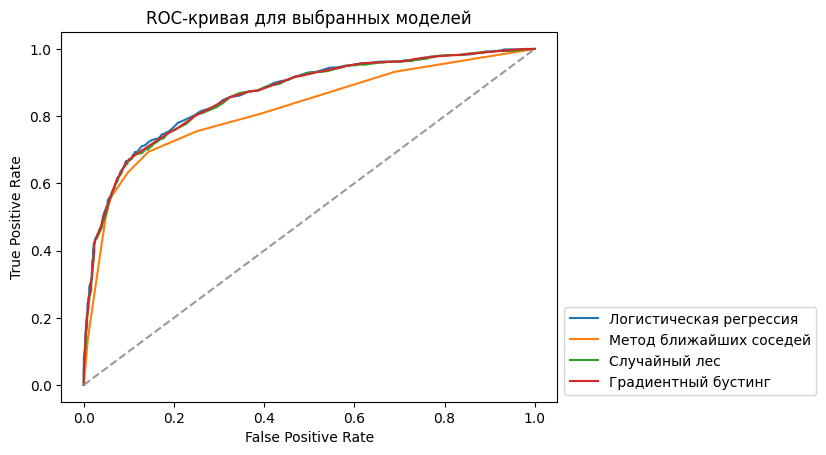

In [ ]:
log_regression = LogisticRegression(C = 0.1)
y_pred_log = log_regression.fit(X_train_ob, train_ob).predict(X_test_ob)
y_pred_proba_log = log_regression.fit(X_train_ob, train_ob).predict_proba(X_test_ob)[::,1]
fpr_log, tpr_log, _ = metrics.roc_curve(test_ob, y_pred_proba_log)

knn = KNeighborsClassifier(n_neighbors = 9)
y_pred_knn = knn.fit(X_train_ob, train_ob).predict(X_test_ob)
y_pred_proba_knn = knn.fit(X_train_ob, train_ob).predict_proba(X_test_ob)[::,1]
fpr_knn, tpr_knn, _ = metrics.roc_curve(test_ob, y_pred_proba_knn)

random_forest = RandomForestClassifier(n_estimators = 50, max_depth = 5)
y_pred_rf = random_forest.fit(X_train_ob, train_ob).predict(X_test_ob)
y_pred_proba_rf = random_forest.fit(X_train_ob, train_ob).predict_proba(X_test_ob)[::,1]
fpr_rf, tpr_rf, _ = metrics.roc_curve(test_ob, y_pred_proba_rf)

gradient_boosting = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05)
y_pred_gb = gradient_boosting.fit(X_train_ob, train_ob).predict(X_test_ob)
y_pred_proba_gb = gradient_boosting.fit(X_train_ob, train_ob).predict_proba(X_test_ob)[::,1]
fpr_gb, tpr_gb, _ = metrics.roc_curve(test_ob, y_pred_proba_gb)

plt.plot (fpr_log, tpr_log, label = "Логистическая регрессия")
plt.plot(fpr_knn, tpr_knn, label = "Метод ближайших соседей")
plt.plot(fpr_rf, tpr_rf, label = "Случайный лес")
plt.plot(fpr_gb, tpr_gb, label = "Градиентный бустинг")
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.legend(bbox_to_anchor = (1,0), loc = 'lower left')
plt.title("ROC-кривая для выбранных моделей")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
results = {
    'Method': ['Logistic Regression', 'KNN', 'RF', 'GBoosting'],
    'AUC (test)': [metrics.roc_auc_score(test_ob, y_pred_proba_log), metrics.roc_auc_score(test_ob, y_pred_proba_knn), metrics.roc_auc_score(test_ob, y_pred_proba_rf), metrics.roc_auc_score(test_ob, y_pred_proba_gb)]}
results_df = pd.DataFrame(results)
(results_df)

,Method,AUC (test)
0,Logistic Regression,0.865088
1,KNN,0.818782
2,RF,0.861189
3,GBoosting,0.862700


Видим, что наибольшее значение AUC у логистической регрессии, на втором месте по дискриптивной способности - градиентный бустинг, на третьем - случайный лес, на четвертом - метод ближайших соседей

***Повышенная сложность: дополнительно выполните это задание для Байесовской сети.***

Для данного пункта предположим, что образование все-таки влияет не только на наличие ожирения, но и зарплату.

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


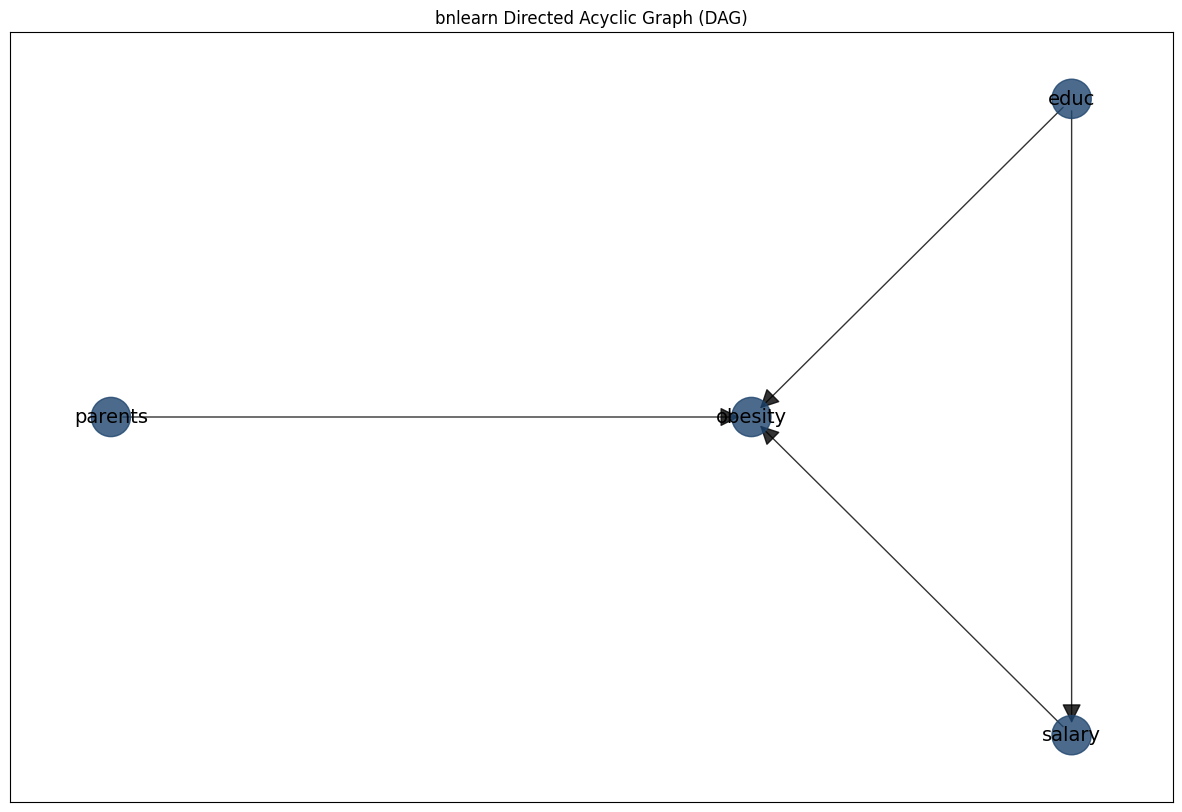

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'parents': array([-1.00000000e+00, -1.62191011e-16]),
  'obesity': array([9.98299780e-17, 2.22401526e-16]),
  'salary': array([ 0.5      , -0.8660254]),
  'educ': array([0.5      , 0.8660254])},
 'G': <networkx.classes.digraph.DiGraph at 0x78a6c5011480>,
 'node_properties': {'parents': {'node_color': '#1f456e', 'node_size': 800},
  'obesity': {'node_color': '#1f456e', 'node_size': 800},
  'salary': {'node_color': '#1f456e', 'node_size': 800},
  'educ': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('parents', 'obesity'): {'color': '#000000', 'weight': 1},
  ('salary', 'obesity'): {'color': '#000000', 'weight': 1},
  ('educ', 'obesity'): {'color': '#000000', 'weight': 1},
  ('educ', 'salary'): {'color': '#000000', 'weight': 1}}}

In [ ]:
edges_class = [("parents", "obesity"),     # (откуда стрелочка, куда стрелочка)
         ("salary", "obesity"),
         ("educ", "salary"),
         ("educ", "obesity")]
DAG = bnlearn.make_DAG(edges_class)
bnlearn.plot(DAG)

В дальнейшем при обучении Байесовской сети возникала проблема, что в обучающей выборке не встречалось значение salary = 18, поэтому на тесте Байесовская сеть не могла расчитать условные вероятности. Чтобы решить данную проблему бинаризуем непрерывный признак salary. Этот подход имеет минус, поскольку из-за разбиения непрерывной переменной на набор дискретных мы теряем часть полезной информации, но это лучше, чем убирать наблюдения. Заметим, что изначально при бинаризации у нас возникла проблема, так как при применении функций qcut() или cut() возникает особый класс, который не воспринимает bnlearn, он предсказывает не 1 или 0, а интервалы. Поэтому закодировали эти интервалы по зарплате в 1, 2, 3, 4, 5.

In [ ]:
#Наши интервалы по ежемесячной зарплате для обучающей выборке
pd.cut(X_train_ob['salary'], bins = 5).value_counts()

salary
(67.6, 96.4]      3954
(38.8, 67.6]      2763
(96.4, 125.2]      913
(9.856, 38.8]      328
(125.2, 154.0]      42
Name: count, dtype: int64

In [ ]:
salary_bin = pd.cut(X_train_ob['salary'], bins = 5, labels = [1, 2, 3, 4, 5])
X_train_b = X_train_ob.join(salary_bin.rename('salary_bin'))
X_train_b.drop('salary', axis = 1, inplace = True)
X_train_b.rename(columns = {'salary_bin':'salary'}, inplace = True)
X_train_b

,educ,parents,salary
9254,0,0,2
1561,1,0,4
1670,0,0,3
6087,0,0,3
6669,0,1,2
...,...,...,...
5734,0,0,3
5191,1,0,2
5390,0,1,2
860,0,0,2


In [ ]:
#Наши интервалы для тестовой выборки
pd.cut(X_test_ob['salary'], bins = 5).value_counts()

salary
(62.4, 88.6]      982
(36.2, 62.4]      516
(88.6, 114.8]     400
(9.869, 36.2]      67
(114.8, 141.0]     35
Name: count, dtype: int64

In [ ]:
salary_bin = pd.cut(X_test_ob['salary'], bins = 5, labels = [1, 2, 3, 4, 5])
X_test_b = X_test_ob.join(salary_bin.rename('salary_bin'))
X_test_b.drop('salary', axis = 1, inplace = True)
X_test_b.rename(columns = {'salary_bin':'salary'}, inplace = True)
X_test_b

,educ,parents,salary
6252,0,0,3
4684,1,1,3
1731,1,0,4
4742,0,0,4
4521,0,0,2
...,...,...,...
6412,0,0,3
8285,0,0,3
7853,0,0,4
1095,0,0,3


In [ ]:
# Оценим параметры модели на обучающей выборке
bn_train = bnlearn.parameter_learning.fit(DAG, X_train_b.join(train_ob), methodtype = 'ml')

[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >CPD of parents:
+------------+-------+
| parents(0) | 0.719 |
+------------+-------+
| parents(1) | 0.281 |
+------------+-------+
[bnlearn] >CPD of obesity:
+------------+------------+-----+---------------------+------------+
| educ       | educ(0)    | ... | educ(1)             | educ(1)    |
+------------+------------+-----+---------------------+------------+
| parents    | parents(0) | ... | parents(1)          | parents(1) |
+------------+------------+-----+---------------------+------------+
| salary     | salary(1)  | ... | salary(4)           | salary(5)  |
+------------+------------+-----+---------------------+------------+
| obesity(0) | 0.5        | ... | 0.7692307692307693  | 0.5        |
+------------+------------+-----+---------------------+------------+
| obesity(1) | 0.5        | ... | 0.23076923076923078 | 0.5        |
+------------+------------+-----+---------------------+------------+
[bnlearn]

In [ ]:
predict_bn_test = bnlearn.predict(bn_train, df = X_test_b.join(test_ob), variables = ["obesity"])
predict_bn_test

prediction_bn = predict_bn_test.loc[:, "obesity"]

# Достанем оценки условных вероятностей наличия ожирения
# с учетом того, что изначально мы имеем лишь вероятности
# наиболее вероятных категорий
prob_nb = np.zeros(len(predict_bn_test.loc[:, "p"]))
prob_nb[prediction_bn == 0] = 1 - predict_bn_test.loc[prediction_bn == 0, "p"]
prob_nb[prediction_bn == 1] = predict_bn_test.loc[prediction_bn == 1, "p"]

[bnlearn]> Remaining columns for inference: 3


100%|██████████| 16/16 [00:00<00:00, 623.06it/s]


In [ ]:
predict_bn_test['obesity'].value_counts()

obesity
0    1430
1     570
Name: count, dtype: int64

[datazets] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AUC по тестовой выборке для построенного нами DAG 0.8495940191203898


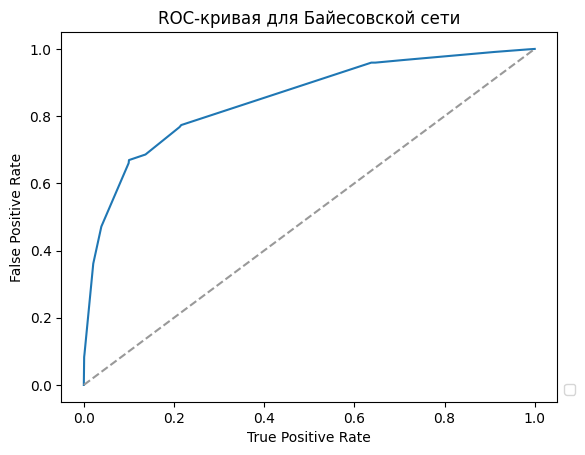

In [ ]:
print(f'AUC по тестовой выборке для построенного нами DAG {metrics.roc_auc_score(test_ob, prob_nb)}')
fpr, tpr, _ = metrics.roc_curve(test_ob, prob_nb)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.legend(bbox_to_anchor = (1,0), loc = 'lower left')
plt.title("ROC-кривая для Байесовской сети")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show()

AUC по тестовой выборке для построенного нами DAG 0.84959, что показывает достаточно хорошее качество классификации Байесовской сети

***6.Постройте матрицу путаницы и предположите цены различных видов прогнозов. Исходя из критерия максимизации прибыли на обучающей выборке подберите оптимальный порог прогнозирования для каждого из методов и сравните
прибыли на тестовой выборке при соответствующих порогах. Результат представьте в форме таблицы, в которой должны быть указаны как AUC, так и
прибыли (на тестовой выборке). Проинтерпретируйте полученный результат.
Повышенная сложность: предложите, содержательно обоснуйте и примените собственную, отличную от линейной функцию прибыли от прогнозов.***

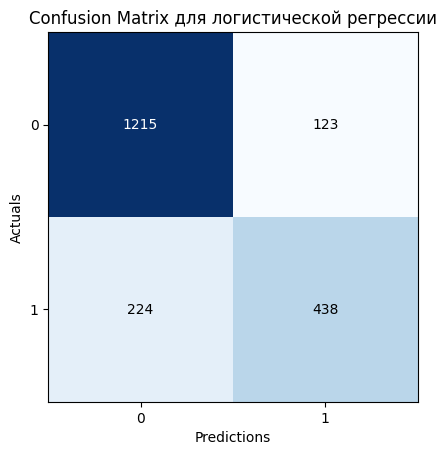

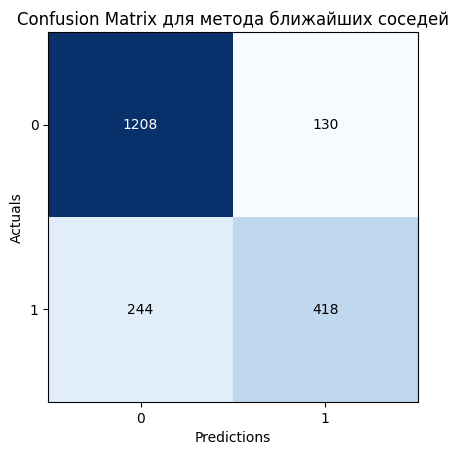

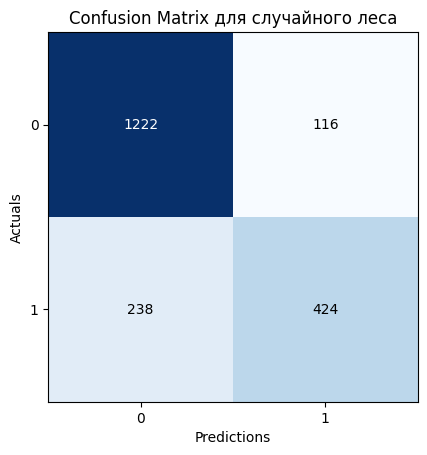

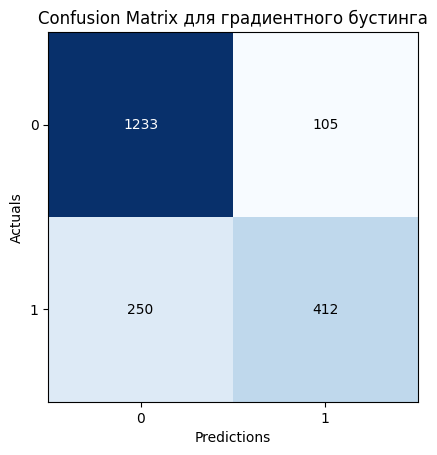

In [ ]:
cm_log = metrics.confusion_matrix(test_ob, y_pred_log)
fig, ax = plot_confusion_matrix(conf_mat = cm_log)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix для логистической регрессии')
plt.show()

cm_knn = metrics.confusion_matrix(test_ob, y_pred_knn)
fig, ax = plot_confusion_matrix(conf_mat = cm_knn)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix для метода ближайших соседей')
plt.show()

cm_rf = metrics.confusion_matrix(test_ob, y_pred_rf)
fig, ax = plot_confusion_matrix(conf_mat = cm_rf)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix для случайного леса')
plt.show()

cm_gb = metrics.confusion_matrix(test_ob, y_pred_gb)
fig, ax = plot_confusion_matrix(conf_mat = cm_gb)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix для градиентного бустинга')
plt.show()

**Предположение о различных ценах**

Предположим, что мы являемся фармацевтической компанией, которая продает бады для похудения и борьбы с ожирением. Для максимизации прибыли нам необходимо продавать как можно больше бадов и препаратов, чтобы это сделать нужно корректно предсказывать наличия ожирения у клиента.

От продажи бада для похудения, получаем $20$ денежных единиц.

Если же прогнозируем, что у человека нет ожирения, то хотим его стимулировать купить не препарат от ожирения, а бад для похудения, который тоже стоит $20$ денежных единиц, чтобы помочь человеку сбросить лищний вес перед летом. Для стимулирования дарим скидку $10\%$. По расчетам аналитического отдела, клиенты, которые по факту не страдают от ожирения, но имеют лишний вес, при предоставлении скидки в $20\%$ случаев все же купят бады.

Рассчитаем цены прогнозов:

*   $p_{TP} = 20$, поскольку фирма точно знает, что люди точно купят бады.
*   $p_{TN} = (20-20*0.1)*0.2=3.6$, благодаря скидке люди, которые не имеют ожирения, купят в $20\%$ случаев бады для похудения к лету.
*   $p_{FP} = 0$, поскольку фирма ошибочно решает, что клиент и так купил бы товар.
*   $p_{FN} = (20-20*0.1)=18$, поскольку фирма дает скидку клиенту, который и так гарантированно купил бы товар.

In [ ]:
# Цены прогнозов
prices = pd.Series([20, 3.6, 0, 18], index = ["TP", "TN", "FP", "FN"])

In [ ]:
def threshold_optim (model):
  # Оценим условные вероятности на обучающей выборке
  prob_knn2_train = model.predict_proba(X_train_ob)[:, 1]

  # Возможные значения порогов
  thresholds_knn2 = np.unique(np.sort(prob_knn2_train))

  # Число порогов
  n_threshold_knn2 = thresholds_knn2.size

  # Вектор для сохранения прибылей при различных порогах
  profits_knn2 = np.zeros(n_threshold_knn2)

  profit_knn2 = np.zeros(n_threshold_knn2)

  # Векторы различных видо прогнозов
  TP_vec = np.zeros(n_threshold_knn2)
  TN_vec = np.zeros(n_threshold_knn2)
  FP_vec = np.zeros(n_threshold_knn2)
  FN_vec = np.zeros(n_threshold_knn2)

  # Рассчитаем прибыли для различных порогов
  for i in range(0, n_threshold_knn2):
    # получаем прогнозы (на обучающей выборке) при соответствующем пороге
    prediction_knn_i = (prob_knn2_train >= thresholds_knn2[i]).astype(int)
    # считаем количество прогнозов различного вида
    TN_vec[i], FP_vec[i], FN_vec[i], TP_vec[i] = metrics.confusion_matrix(train_ob, prediction_knn_i).ravel()
    # аггрегируем результаты прогнозов
    predictions_knn_i = pd.Series([TP_vec[i], TN_vec[i], FP_vec[i], FN_vec[i]], index = ["TP", "TN", "FP", "FN"])
    # считаем прибыль
    profits_knn2[i] = np.sum(prices * predictions_knn_i)

  # Достанем оптимальный порог
  res = thresholds_knn2[np.argmax(profits_knn2)]
  return res

In [ ]:
threshold_opt_log = threshold_optim (log_regression)
print(f'Оптимальный порог для логистической регрессии {threshold_opt_log}')

Оптимальный порог для логистической регрессии 0.6114187945816437


In [ ]:
threshold_opt_knn = threshold_optim (knn)
print(f'Оптимальный порог для метода ближайших соседей {threshold_opt_knn}')

Оптимальный порог для метода ближайших соседей 0.6666666666666666


In [ ]:
threshold_opt_rf = threshold_optim (random_forest)
print(f'Оптимальный порог для случайного леса {threshold_opt_rf}')

Оптимальный порог для случайного леса 0.6683028877627543


In [ ]:
threshold_opt_gb = threshold_optim (gradient_boosting)
print(f'Оптимальный порог для градиентного бустинга {threshold_opt_gb}')

Оптимальный порог для градиентного бустинга 0.5743304462572713


In [ ]:
# Посчитаем прибыль на тестовой выборке, используя подобранный на обучающей выборке порог
def profit_test (model, threshold):
  prob_log_test = model.predict_proba(X_test_ob)[:, 1]
  prediction_log = prob_log_test >= threshold
  # посчитаем число прогнозов различного вида
  TN_log, FP_log, FN_log, TP_log = metrics.confusion_matrix(test_ob, prediction_log).ravel()
  predictions_log = pd.Series([TP_log, TN_log, FP_log, FN_log], index = ["TP", "TN", "FP", "FN"])
  auc = metrics.roc_auc_score(test_ob, prediction_log)
  # оценим прибыль на тестовой выборке
  profit_log_test = np.sum(prices * predictions_log)
  return profit_log_test, auc

In [ ]:
result_profit = pd.DataFrame({'Method': ['Logistic Regression', 'KNN', 'Random Forest', 'Gradient Boosting'], 'Threshold': [threshold_opt_log, threshold_opt_knn, threshold_opt_rf, threshold_opt_gb],
                              'Profit (test)': [profit_test(log_regression, threshold_opt_log)[0], profit_test(knn, threshold_opt_knn)[0], profit_test(random_forest, threshold_opt_rf)[0], profit_test(gradient_boosting, threshold_opt_gb)[0]],
                              'AUC': [profit_test(log_regression, threshold_opt_log)[1], profit_test(knn, threshold_opt_knn)[1], profit_test(random_forest, threshold_opt_rf)[1], profit_test(gradient_boosting, threshold_opt_gb)[1]]})
result_profit

,Method,Threshold,Profit (test),AUC
0,Logistic Regression,0.611419,17188.0,0.763585
1,KNN,0.666667,17182.8,0.748806
2,Random Forest,0.668303,17185.2,0.760556
3,Gradient Boosting,0.574330,17188.8,0.770788


Интерпретация полученных результатов: наибольшую точность классификации показал градиентный бустинг, согласно значению AUC, на втором месте - логистическая регрессия. Наибольшая же прибыль на тестовой выборке при использовании случайного леса, значение AUC у данного алгоритма на третьем месте по близости к 1 (идеальной классификации). Хуже всего как по прибыли на тестовой выборке, так и по AUC качество показывает knn.

***6. Повышенная сложность:предложите, содержательно обоснуйте и примените собственную, отличную от линейной функцию прибыли от прогнозов.***

Представим, что у нас постоянная отдача от масштаба. Тогда количество проданных бадов может быть представлено в виде функици Кобба-Дугласа. $$Q = TP^{1/2}FN^{1/4}TN^{1/4}$$


То есть при изменении TP (то есть мы предсказываем, что наш бад купят, его и покупают) на 1%, количество проданных бадов изменится на 0.5%, так как мы будем предлагать таким людям персональные акции и предложения, чтобы увеличивать их лояльность. При изменении FN (то есть мы предсказали, что наш бад не купят, а его купили) на 1%, количество проданных бадов изменится на 0.25%, поскольку мы не отправляли рассылки на почту данным клиентам о новых предложениях, так как думали, что они итак не купят, что снизило их лояльность. При изменении FN (то мы предсказали, что наш бад не купят, а его купили) на 1%, количество проданных бадов изменится на 0.25%, поскольку мы предоставляем скидку на бады не от ожирения, а для мягкого похудения к лету, которая приносит нам положительную конверсию. И наш аналитический отдел поменял оценку процента людей, которые купят все-таки бады, чтобы скинуть вес к лету после предоставлении скидки.

Соответственно, прибыль нашей фирмы можно представить как $$П = 20TP^{1/2}FN^{1/4}TN^{1/4}$$

***7.  Опишите предполагаемые связи между переменными в форме ориентированного ациклического графа (DAG). Обучите структуру Байесовской сети на обучающей выборке и сравните точность прогнозов вашего и обученного DAG на
тестовой выборке.***

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


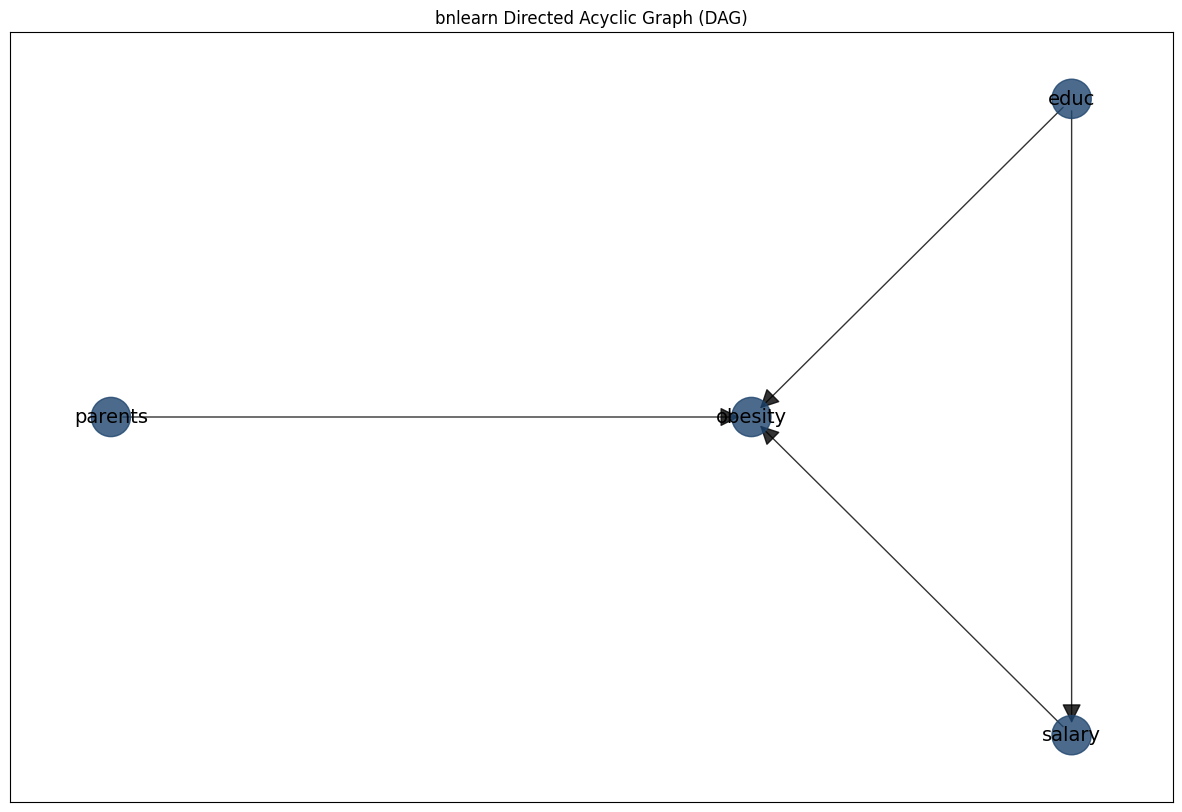

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'parents': array([-1.00000000e+00, -1.62191011e-16]),
  'obesity': array([9.98299780e-17, 2.22401526e-16]),
  'salary': array([ 0.5      , -0.8660254]),
  'educ': array([0.5      , 0.8660254])},
 'G': <networkx.classes.digraph.DiGraph at 0x78a6c5646200>,
 'node_properties': {'parents': {'node_color': '#1f456e', 'node_size': 800},
  'obesity': {'node_color': '#1f456e', 'node_size': 800},
  'salary': {'node_color': '#1f456e', 'node_size': 800},
  'educ': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('parents', 'obesity'): {'color': '#000000', 'weight': 1},
  ('salary', 'obesity'): {'color': '#000000', 'weight': 1},
  ('educ', 'obesity'): {'color': '#000000', 'weight': 1},
  ('educ', 'salary'): {'color': '#000000', 'weight': 1}}}

In [ ]:
edges_class = [("parents", "obesity"),     # (откуда стрелочка, куда стрелочка)
         ("salary", "obesity"),
         ("educ", "salary"),
         ("educ", "obesity")]
DAG = bnlearn.make_DAG(edges_class)
bnlearn.plot(DAG)

In [ ]:
# Наша байесовская сеть
bn_ours = bnlearn.parameter_learning.fit(DAG, X_train_b.join(train_ob))
predict_bn_ours = bnlearn.predict(bn_ours, X_test_b.join(test_ob),
                                  variables = ["obesity"])
prediction_bn_ours = np.array(predict_bn_ours.loc[:, "obesity"])

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of parents:
+------------+----------+
| parents(0) | 0.694667 |
+------------+----------+
| parents(1) | 0.305333 |
+------------+----------+
[bnlearn] >CPD of obesity:
+------------+------------+-----+--------------------+------------+
| educ       | educ(0)    | ... | educ(1)            | educ(1)    |
+------------+------------+-----+--------------------+------------+
| parents    | parents(0) | ... | parents(1)         | parents(1) |
+------------+------------+-----+--------------------+------------+
| salary     | salary(1)  | ... | salary(4)          | salary(5)  |
+------------+------------+-----+--------------------+------------+
| obesity(0) | 0.5        | ... | 0.5555555555555556 | 0.5        |
+------------+------------+-----+--------------------+------------+
| obesity(1) | 0.5        | ... | 0.4444444444444444 | 0.5        |
+------------+------------+-----+--------------------+------------+
[b

100%|██████████| 16/16 [00:00<00:00, 615.99it/s]


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [aic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


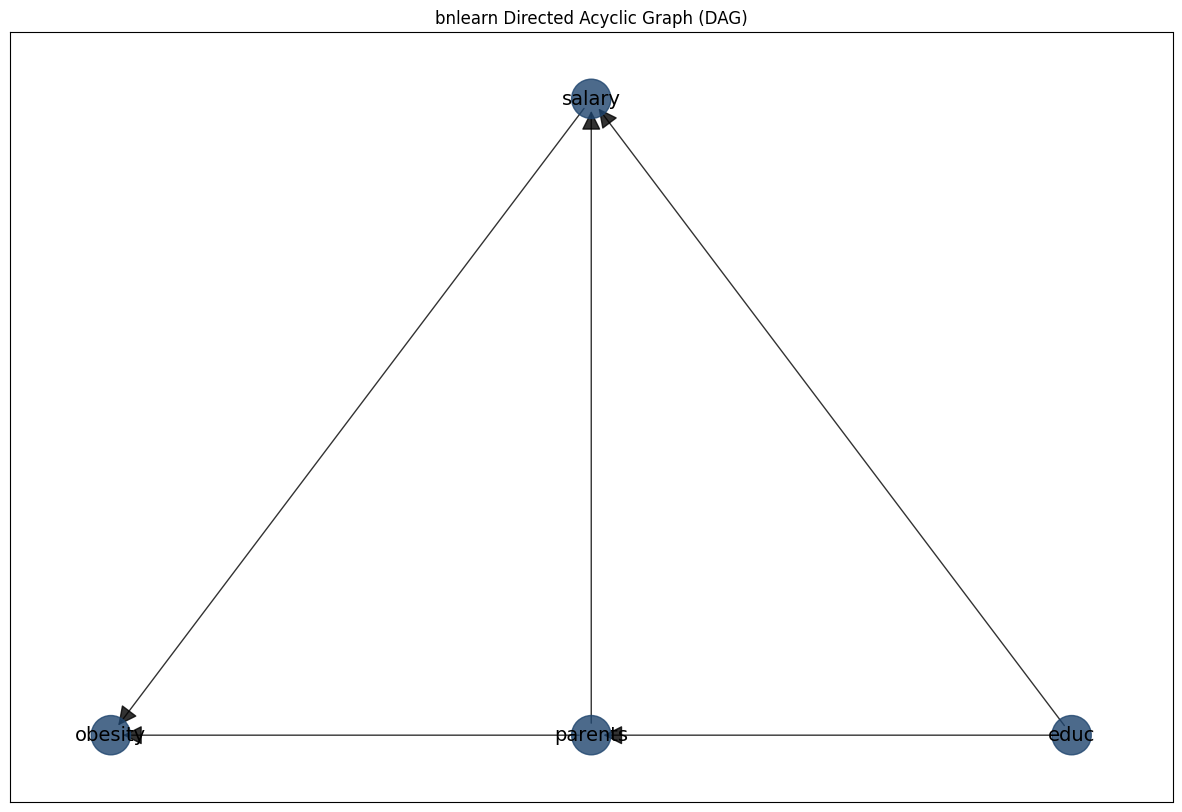

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'salary': array([4.63999782e-17, 1.00000000e+00]),
  'obesity': array([-0.81649658, -0.33333333]),
  'educ': array([ 0.81649658, -0.33333333]),
  'parents': array([-3.29921541e-17, -3.33333333e-01])},
 'G': <networkx.classes.digraph.DiGraph at 0x78a6c569c7f0>,
 'node_properties': {'salary': {'node_color': '#1f456e', 'node_size': 800},
  'educ': {'node_color': '#1f456e', 'node_size': 800},
  'parents': {'node_color': '#1f456e', 'node_size': 800},
  'obesity': {'node_color': '#1f456e', 'node_size': 800}},
 'edge_properties': {('salary', 'obesity'): {'color': '#000000', 'weight': 1},
  ('educ', 'salary'): {'color': '#000000', 'weight': 1},
  ('educ', 'parents'): {'color': '#000000', 'weight': 1},
  ('parents', 'salary'): {'color': '#000000', 'weight': 1},
  ('parents', 'obesity'): {'color': '#000000', 'weight': 1}}}

In [ ]:
# Подберем оптимальную структуру DAG на обучающей выборе
bn2_train_structure = bnlearn.structure_learning.fit(X_train_ob.join(train_ob),
                                                     methodtype = 'hc',
                                                     scoretype  = 'aic')
# Посмотрим на результат
bnlearn.plot(bn2_train_structure, interactive = False)

In [ ]:
# Сохраним найденный DAG
DAG2 = bnlearn.make_DAG(bn2_train_structure)

[bnlearn] >No changes made to existing bayes DAG.


In [ ]:
# Оценим модель с подобранным DAG
bn2_train = bnlearn.parameter_learning.fit(DAG2, X_train_b.join(train_ob),
                                           methodtype = 'ml')

[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of salary:
+-----------+---------------------+-----+----------------------+
| educ      | educ(0)             | ... | educ(1)              |
+-----------+---------------------+-----+----------------------+
| parents   | parents(0)          | ... | parents(1)           |
+-----------+---------------------+-----+----------------------+
| salary(1) | 0.0                 | ... | 0.024174053182917002 |
+-----------+---------------------+-----+----------------------+
| salary(2) | 0.2527021184608733  | ... | 0.4536663980660757   |
+-----------+---------------------+-----+----------------------+
| salary(3) | 0.6028966709900562  | ... | 0.5116841257050766   |
+-----------+---------------------+-----+----------------------+
| salary(4) | 0.1379161262429745  | ... | 0.010475423045930701 |
+--

In [ ]:
# Получим прогнозы по тестовой выборке
predict_bn2_test = bnlearn.predict(bn2_train, X_test_b.join(test_ob),
                                   variables = ["obesity"])
prediction_bn2_test = np.array(predict_bn2_test.loc[:, "obesity"])

[bnlearn]> Remaining columns for inference: 3


100%|██████████| 16/16 [00:00<00:00, 710.65it/s]


In [ ]:
# Достанем оценки условных вероятностей наличия ожирения
# с учетом того, что изначально мы имеем лишь вероятности
# наиболее вероятных категорий
prob_nb2 = np.zeros(len(predict_bn2_test.loc[:, "p"]))
prob_nb2[prediction_bn2_test == 0] = 1 - predict_bn2_test.loc[prediction_bn2_test == 0, "p"]
prob_nb2[prediction_bn2_test == 1] = predict_bn_test.loc[prediction_bn2_test == 1, "p"]

auc_bn2 = metrics.roc_auc_score(test_ob, prob_nb2)
print(f'AUC для обученной байесовской сети: {auc_bn2}')

AUC для обученной байесовской сети: 0.8466699632856001


In [ ]:
# Оценим точность прогноза по тестовой выборке
ACC_ours = np.mean(test_ob == prediction_bn_ours)
ACC_bn2_test = np.mean(test_ob == prediction_bn2_test)

# Сравним точность Байесовской сети с
# исходным и обученным DAG
print(pd.DataFrame(data    = [ACC_ours, ACC_bn2_test],
                   index   = ['Байесовская сеть с нашим DAG',
                              'Байесовская сеть с обученным DAG'],
                   columns = ['ACC-test']))

                                  ACC-test
Байесовская сеть с нашим DAG        0.8210
Байесовская сеть с обученным DAG    0.8225


Точность прогноза с обученным DAG немного улучшилась по сравнению с составленным по нашим предположениям DAG.

***8. На основании проделанного анализа выберите лучший и худший из обученных классификаторов. Обоснуйте сделанный выбор.***

Согласно точности прогнозов на тестовой выборке, видим, что по метрике accuracy лучшим классификатором оказалась логистическая регрессия (0.827), худший результат показал метод ближайших соседей (0.809). Но стоит отметить, что градиентный бустинг (accuracy = 0.8225), случайный лес (accuracy = 0.824) и байесовская сеть с обученным DAG (accuracy = 0.8225) показали результаты достаточно близкие к лучшему по метрике accuracy классификатору.
Объяснение:
1. knn показал худшие значения accuracy показал на тестовой выборке, так как этот метод склонен к переобучению, чем больше соседей, тем больше метод подстраивается под данные. Данный алгоритм очень простой, у него даже нет функции потерь, которую минимизируем, а просто считаем расстояние между объектами.
2. Логистическая регрессия показала лучший результат, возможно, из-за того, что градиентный бустинг начал переобучаться, или же не для всех возможных, а только "основынх" гиперпараметров был произведен тюнинг.
Однако метрика accuracy не учитывает возможный дисбаланс классов, который как в ячейке ниже показали, только около 30% выборки принадлежит к классу 1 (obesity = 1)

Согласно точности прогнозов по тестовой выборке относительно метрики AUC, видим, что лучшим классификатором стала также логистическая регрессия (0.865), худшим классификатором по значению AUC на тестовой выборке так же стал knn.

In [ ]:
pd.DataFrame({'доля единиц в obesity': [(df['obesity'] == 1).sum()/10000], 'доля нулей в obesity': [(df['obesity'] == 0).sum()/10000]})

,доля единиц в obesity,доля нулей в obesity
0,0.3301,0.6699


***9. Повышенная сложность: включите в анализ дополнительный метод классификации, не рассматривавшийся в курсе и не представленный в библиотеке
scikit-learn. Опишите данный метод (принцип работы, преимущества и недостатки) и осуществите тюнинг гиперпараметров. Сопоставьте его точность на
тестовой выборке с точностью лучшего из обученных вами ранее методов.***

В курсе рассказывалось об идее и общем принципе работы градиентного бустинга. Однако есть библиотеки, которые модифицируют исходный алгоритм градиентного бустинга для получения более точных прогнозов. Так, например, улучшает исходный метод повышения градиента для более быстрой реализации CatBoost. Его основным преимуществом является тот факт, что “из коробки” он уже неплохо работает и вопрос тюнинга гиперпараметров не стоит так остро.

Принцип работы как у градиентного бустинга, где каждый следующий алгоритм подбирается так, чтобы минимизировать ошибку предыдущих. Распишем чуть подробнее данный алгоритм.
Сначала Инициализация: Создаем модель с начальными значениями.

Затем итерация:
- Рассчитываем градиенты функции потерь по отношению к прогнозам модели.
- Обучаем классификатора (например, дерево решений) на антиградиентах.
- Обновляем модель, добавив слабый классификатор с небольшим весом.

Таким образом, для следующего алгоритма целевая переменная будет уже вектор ошибок предыдущего алгоритма. Так продолжием пока не выполнится критерий останова. Полученная модель представляет собой ансамбль классификаторов, взвешенных по их вкладу в уменьшение функции потерь. Разница же с обычным градиентным бустингом состоит при построении деревьев: строим бинарные и симметричные деревья по слоям, но на каждом уровне используем одинаковые предикаты. Это помогает избежать сложного разбиения на области. Мы делаем прогнозы для каждого уровня параллельно, что увеличивает скорость предсказания.


В качестве недостатков можно назвать длительность работы, особенно в обработке категориальных признаков. Мы это не заметили, так как у нас мало регрессоров и сетка гиперпараметров небольшая, но в работе стоит учитывать возможность затратить большое количество вычислительных средств

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(random_state = 1)
params_cat = {'n_estimators' : [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_cat = GridSearchCV(cat, params_cat, cv = 4, scoring = 'roc_auc')
grid_cat.fit(X_train_ob, train_ob, verbose = False)
print(f'AUC test (tuned): {grid_cat.score(X_test_ob, test_ob)}')

AUC test (tuned): 0.8621985061348723


In [ ]:
cat = CatBoostClassifier(random_state = 1)
params_cat = {'n_estimators' : [50, 100, 150], 'max_depth': [5, 10, 15]}
grid_cat = GridSearchCV(cat, params_cat, cv = 4, scoring = 'accuracy')
grid_cat.fit(X_train_ob, train_ob, verbose = False)
grid_cat.score(X_test_ob, test_ob)
print(f'ACC test (tuned): {grid_cat.score(X_test_ob, test_ob)}')

ACC test (tuned): 0.825


Видим, что CatBoost показал ниже точность прогнозов на тестовой выборке по метрике ACC, чем логистическая регрессия, но значение AUC на тесте оказалось выше, чем у логистической регрессии.

#4. Регрессия

1.Задание: ***Отберите признаки, которые могут быть полезны при прогнозировании целевой (зависимой) переменной. Не включайте в число этих признаков переменную
воздействия.***

В качестве признаков будем использовать наличие высшего образования, наличие ДМС, наличие ожирения у родителей, зарплата

In [ ]:
X_train_life = X_train.drop(['obesity'], axis=1)
X_test_life = X_test.drop(['obesity'], axis=1)
y_train

9254    58.382885
1561    83.065787
1670    73.706985
6087    60.790916
6669    30.359761
          ...    
5734    64.598438
5191    55.961722
5390    32.271557
860     49.101180
7270    45.191704
Name: lifespan, Length: 8000, dtype: float64

2. Задание: ***Выберите произвольные значения гиперпараметров, а затем оцените и сравните (между методами) точность прогнозов с помощью RMSE и MAPE.***

Выбрали случайный лес, knn и градиентный бустинг в качестве моделей.

In [ ]:
rf = RandomForestRegressor(n_estimators=100,  max_depth = 20,
                            max_features = 3, random_state=42)
knn = KNeighborsRegressor(n_neighbors=3)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

rf.fit(X_train_life, y_train)
knn.fit(X_train_life, y_train)
gb.fit(X_train_life, y_train)



GradientBoostingRegressor(random_state=42)

In [ ]:
rf_pred_train = rf.predict(X_train_life)
knn_pred_train = knn.predict(X_train_life)
gb_pred_train = gb.predict(X_train_life)

rf_pred_test = rf.predict(X_test_life)
knn_pred_test = knn.predict(X_test_life)
gb_pred_test = gb.predict(X_test_life)

rf_rmse_train = mean_squared_error(y_train, rf_pred_train, squared=False)
knn_rmse_train = mean_squared_error(y_train, knn_pred_train, squared=False)
gb_rmse_train = mean_squared_error(y_train, gb_pred_train, squared=False)

rf_rmse_test = mean_squared_error(y_test, rf_pred_test, squared=False)
knn_rmse_test = mean_squared_error(y_test, knn_pred_test, squared=False)
gb_rmse_test = mean_squared_error(y_test, gb_pred_test, squared=False)

rf_mape_train = mean_absolute_percentage_error(y_train, rf_pred_train)
knn_mape_train = mean_absolute_percentage_error(y_train, knn_pred_train)
gb_mape_train = mean_absolute_percentage_error(y_train, gb_pred_train)

rf_mape_test = mean_absolute_percentage_error(y_test, rf_pred_test)
knn_mape_test = mean_absolute_percentage_error(y_test, knn_pred_test)
gb_mape_test = mean_absolute_percentage_error(y_test, gb_pred_test)

print("Random Forest: RMSE Train:", rf_rmse_train, "RMSE Test:", rf_rmse_test)
print("Random Forest: MAPE Train:", rf_mape_train, "MAPE Test:", rf_mape_test)
print('\n')
print("KNN: RMSE Train:", knn_rmse_train, "RMSE Test:", knn_rmse_test)
print("KNN: MAPE Train:", knn_mape_train, "MAPE Test:", knn_mape_test)
print('\n')
print("Gradient Boosting: RMSE Train:", gb_rmse_train, "RMSE Test:", gb_rmse_test)
print("Gradient Boosting: MAPE Train:", gb_mape_train, "MAPE Test:", gb_mape_test)

Random Forest: RMSE Train: 15.4876010501248 RMSE Test: 16.162613758606227
Random Forest: MAPE Train: 0.2865760390895442 MAPE Test: 0.26025915686442624


KNN: RMSE Train: 17.441003161792192 RMSE Test: 18.1229328264458
KNN: MAPE Train: 0.31873635204255174 MAPE Test: 0.28989850640766784


Gradient Boosting: RMSE Train: 15.707211164967722 RMSE Test: 15.80387742753016
Gradient Boosting: MAPE Train: 0.2927562910398645 MAPE Test: 0.2540798557470951


In [ ]:
cv = KFold(n_splits=4, shuffle=True, random_state=42)
rmse_scorer = make_scorer(mean_squared_error, squared=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

rf_rmse_cv = cross_val_score(rf, X_train_life, y_train, cv=cv, scoring=rmse_scorer)
knn_rmse_cv = cross_val_score(knn, X_train_life, y_train, cv=cv, scoring=rmse_scorer)
gb_rmse_cv = cross_val_score(gb, X_train_life, y_train, cv=cv, scoring=rmse_scorer)

rf_mape_cv = cross_val_score(rf, X_train_life, y_train, cv=cv, scoring=mape_scorer)
knn_mape_cv = cross_val_score(knn, X_train_life, y_train, cv=cv, scoring=mape_scorer)
gb_mape_cv = cross_val_score(gb, X_train_life, y_train, cv=cv, scoring=mape_scorer)

print("Random Forest - Mean RMSE CV:", np.mean(rf_rmse_cv))
print("Random Forest - Mean MAPE CV:", -np.mean(rf_mape_cv))
print('\n')
print("KNN - Mean RMSE CV:", np.mean(knn_rmse_cv))
print("KNN - Mean MAPE CV:", -np.mean(knn_mape_cv))
print('\n')
print("Gradient Boosting - Mean RMSE CV:", np.mean(gb_rmse_cv))
print("Gradient Boosting - Mean MAPE CV:", -np.mean(gb_mape_cv))

Random Forest - Mean RMSE CV: 16.41446780209965
Random Forest - Mean MAPE CV: 0.30798215326668243


KNN - Mean RMSE CV: 18.036850219992434
KNN - Mean MAPE CV: 0.3326211971617859


Gradient Boosting - Mean RMSE CV: 15.949289695170954
Gradient Boosting - Mean MAPE CV: 0.29916577814091877


RMSE измеряет среднеквадратичную ошибку, что делает ее чувствительной к большим ошибкам и выбросам.
Random Forest: разница между обучающей и тестовой выборками незначительна, что указывает на хорошее общее поведение модели с небольшим переобучением. KNN имеет наибольшие RMSE как на обучающей, так и на тестовой выборках, что указывает на худшую производительность по сравнению с другими моделями. Gradient Boosting имеет самые низкие RMSE на тестовой выборке и небольшую разницу между обучающей и тестовой выборками, что указывает на хорошую обобщающую способность моделей.
MAPE измеряет средний абсолютный процент ошибки, что делает ее полезной для понимания относительных ошибок. RF: Разница между обучающей и тестовой выборками невелика, что свидетельствует о хорошем обобщении. Тестовая ошибка ниже, чем у KNN, но выше, чем у Gradient Boosting. KNN имеет наибольшие значения MAPE, что подтверждает его худшую производительность. Gradient Boosting имеет наименьший MAPE на тестовой выборке, что указывает на лучшую способность модели предсказывать значения с минимальной процентной ошибкой.
Gradient Boosting показывает наилучшую производительность на тестовой выборке по обеим метрикам (RMSE и MAPE), что указывает на его способность к хорошему обобщению без значительного переобучения.
Random Forest также демонстрирует хорошее обобщение, но его производительность немного хуже по сравнению с Gradient Boosting.
KNN показывает наихудшие результаты по обеим метрикам, что может быть связано с его чувствительностью к выбору гиперпараметров и менее эффективной работой с высокоразмерными данными или шумом.

3. Задание: ***Для каждого метода с помощью кросс-валидации на обучающей выборке подберите оптимальные значения гиперпараметров (тюнинг). В качестве критерия
качества используйте RMSE. Результат представьте в форме таблицы.***

In [ ]:
def calculate_rmse(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    rmse_train = mean_squared_error(y_train, train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, test_pred, squared=False)
    return rmse_train, rmse_test

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5, 7]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

param_grid_gb = {
    'n_estimators': [50, 100,  150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gs_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring=rmse_scorer)
gs_rf.fit(X_train_life, y_train)
best_rf = gs_rf.best_estimator_

gs_knn = GridSearchCV(knn, param_grid_knn, cv=cv, scoring=rmse_scorer)
gs_knn.fit(X_train_life, y_train)
best_knn = gs_knn.best_estimator_

gs_gb = GridSearchCV(gb, param_grid_gb, cv=cv, scoring=rmse_scorer)
gs_gb.fit(X_train_life, y_train)
best_gb = gs_gb.best_estimator_

rf_rmse_initial_train, rf_rmse_initial_test = calculate_rmse(rf, X_train_life, X_test_life, y_train, y_test)
knn_rmse_initial_train, knn_rmse_initial_test = calculate_rmse(knn, X_train_life, X_test_life, y_train, y_test)
gb_rmse_initial_train, gb_rmse_initial_test = calculate_rmse(gb, X_train_life, X_test_life, y_train, y_test)

rf_rmse_best_train, rf_rmse_best_test = calculate_rmse(best_rf, X_train_life, X_test_life, y_train, y_test)
knn_rmse_best_train, knn_rmse_best_test = calculate_rmse(best_knn, X_train_life, X_test_life, y_train, y_test)
gb_rmse_best_train, gb_rmse_best_test = calculate_rmse(best_gb, X_train_life, X_test_life, y_train, y_test)

In [ ]:
results = {
    'Model': ['Random Forest', 'KNN', 'Gradient Boosting'],
    'Initial Hyperparameters': [
        {'n_estimators': 100, 'max_depth': 20, 'max_features':3},
        {'n_neighbors': 3},
        {'n_estimators': 100, 'learning_rate': 0.1}
    ],
    'Tuned Hyperparameters': [
        str(gs_rf.best_params_),
        str(gs_knn.best_params_),
        str(gs_gb.best_params_)
    ],
    'RMSE CV Initial': [
        gs_rf.cv_results_['mean_test_score'][gs_rf.best_index_],
        gs_knn.cv_results_['mean_test_score'][gs_knn.best_index_],
        gs_gb.cv_results_['mean_test_score'][gs_gb.best_index_]
    ],
    'RMSE CV Tuned': [
        gs_rf.best_score_,
        gs_knn.best_score_,
        gs_gb.best_score_
    ],
    'RMSE Train Initial': [
        rf_rmse_initial_train,
        knn_rmse_initial_train,
        gb_rmse_initial_train
    ],
    'RMSE Test Initial': [
        rf_rmse_initial_test,
        knn_rmse_initial_test,
        gb_rmse_initial_test
    ],
    'RMSE Train Tuned': [
        rf_rmse_best_train,
        knn_rmse_best_train,
        gb_rmse_best_train
    ],
    'RMSE Test Tuned': [
        rf_rmse_best_test,
        knn_rmse_best_test,
        gb_rmse_best_test
    ]
}

results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
results_df

,Model,Initial Hyperparameters,Tuned Hyperparameters,RMSE CV Initial,RMSE CV Tuned,RMSE Train Initial,RMSE Test Initial,RMSE Train Tuned,RMSE Test Tuned
0,Random Forest,"{'n_estimators': 100, 'max_depth': 20, 'max_features': 3}","{'max_depth': 12, 'min_samples_split': 2, 'n_estimators': 50}",16.414115,16.414115,15.487601,16.162614,15.493470,16.151833
1,KNN,{'n_neighbors': 3},"{'n_neighbors': 3, 'weights': 'distance'}",18.137184,18.137184,17.441003,18.122933,17.403055,18.154257
2,Gradient Boosting,"{'n_estimators': 100, 'learning_rate': 0.1}","{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}",19.243799,19.243799,15.707211,15.803877,19.202562,19.065850


***Повышенная сложность: подберите на обучающей выборке оптимальные
значения гиперпараметров градиентного бустинга ориентируясь на значение
OOB (out-of-bag) ошибки. Сопоставьте гиперпараметры и точность на тестовой выборке для градиентного бустинга в зависимости от того, используется
кросс-валидация или OOB ошибка.***

Несмотря на обновление до последней версии scikit learn, параметр oob_score в бустинге не работает, поэтому решили сделать таким образом: так как понятие OOB применимо скорее для случайного леса, мы решили обучить случайный лес с вычислением oob ошибки, подобрав наилучшие гиперпараметры. Затем эти наилучшие гиперпараметры используются для обучения бустинга, результат сравнивается с предыдущими моделями.

In [ ]:
def calculate_rmse(model, X_train, X_test, y_train, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    rmse_train = mean_squared_error(y_train, train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, test_pred, squared=False)
    return rmse_train, rmse_test

def get_oob_error(params, X, y):
    rf_for_oob.set_params(**params)
    rf_for_oob.fit(X, y)
    return 1 - rf_for_oob.oob_score_

rf_for_oob = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=42)

best_oob_score = float('inf')
best_params_oob = None
for n_estimators in param_grid_gb['n_estimators']:
    for learning_rate in param_grid_gb['learning_rate']:
        for max_depth in param_grid_gb['max_depth']:
            params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': 2,
                'bootstrap': True
            }
            oob_error = get_oob_error(params, X_train_life, y_train)
            if oob_error < best_oob_score:
                best_oob_score = oob_error
                best_params_oob = params

best_gb_oob = GradientBoostingRegressor(
    n_estimators=best_params_oob['n_estimators'],
    learning_rate=learning_rate,
    max_depth=best_params_oob['max_depth'],
    random_state=42
)

best_gb_oob.fit(X_train_life, y_train)

gs_gb_cv = GridSearchCV(gb, param_grid_gb, cv=cv, scoring=rmse_scorer)
gs_gb_cv.fit(X_train_life, y_train)
best_gb_cv = gs_gb_cv.best_estimator_

gb_rmse_initial_train, gb_rmse_initial_test = calculate_rmse(gb, X_train_life, X_test_life, y_train, y_test)

gb_rmse_cv_train, gb_rmse_cv_test = calculate_rmse(best_gb_cv, X_train_life, X_test_life, y_train, y_test)

gb_rmse_oob_train, gb_rmse_oob_test = calculate_rmse(best_gb_oob, X_train_life, X_test_life, y_train, y_test)

results = {
    'Method': ['Initial GB', 'CV GB' , 'OOB Error GB'],
    'Hyperparameters': [
        'n_estimators=100, learning_rate=0.1',
        str(gs_gb_cv.best_params_),
        str(best_params_oob)
    ],
    'RMSE Train': [
        gb_rmse_initial_train,
        gb_rmse_cv_train,
        gb_rmse_oob_train
    ],
    'RMSE Test': [
        gb_rmse_initial_test,
        gb_rmse_cv_test,
        gb_rmse_oob_test
    ]
}

results_df = pd.DataFrame(results)

pd.set_option('display.max_colwidth', None)

(results_df)


,Method,Hyperparameters,RMSE Train,RMSE Test
0,Initial GB,"n_estimators=100, learning_rate=0.1",15.707211,15.803877
1,CV GB,"{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}",19.202562,19.065850
2,OOB Error GB,"{'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 2, 'bootstrap': True}",15.523414,15.985573


4. ***На основании проделанного анализа выберите лучший и худший из обученных регрессоров. Обоснуйте сделанный выбор.***

- Подбор гиперпараметров RF привел к незначительным изменениям RMSE на трейне и тесте, с небольшим улучшением на тестовой выборке. Это свидетельствует о том, что модель была хорошо настроена изначально и изменение гиперпараметров не привело к значительным улучшениям.
- Подбор гиперпараметров KNN практически не изменил RMSE на кросс-валидации и тестовой выборке, с небольшим улучшением на трейне. Это может свидетельствовать о том, что изначальные гиперпараметры уже были близки к оптимальным.
- Подбор гиперпараметров GB значительно ухудшил RMSE на обучающей и тестовой выборках, что может свидетельствовать о переобучении или недостаточной гибкости модели после изменения гиперпараметров. Возможно, новые гиперпараметры (низкий lr и меньшее количество деревьев) сделали модель слишком консервативной и недостаточно обобщающей для наших данных.

Ожидаемо, наилучшей моделью оказался градиентный бустинг. Результаты после подбора гиперпараметров с помощью кросс-валидации у градиентного бустинга оказались хуже, чем  с выбранными гиперпараметрами по дефолту и с учетом OOB ошибки. В дальнейшем исследовании будем использовать эту модель, так как, конечно, она намного сложнее и результативнее knn. Худшей моделью по метрике качества RMSE оказался случайный лес, что удивительно. Однако мы предполагаем, что у случайного леса мы недотюнили все гиперпараметры. Поэтому в дальнейшем в качестве худшего метода все-таки используем метод ближайших соседей, поскольку он максимально негибкий, и у него даже нет параметров.

5. ***Повышенная сложность: включите в анализ дополнительный метод регрессии, не рассматривавшийся в курсе и не представленный в библиотеке scikitlearn. Опишите данный метод (принцип работы, преимущества и недостатки)
и осуществите тюнинг гиперпараметров. Сопоставьте его точность на тестовой
выборке с точностью лучшего из обученных вами ранее методов.***

In [ ]:
cat = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, silent=True, random_state=42)

param_grid_cat = {
    'iterations': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7, 9, 11]
}

gs_cat = GridSearchCV(cat, param_grid_cat, cv=cv, scoring=rmse_scorer)
gs_cat.fit(X_train_life, y_train)
best_cat = gs_cat.best_estimator_
cat_rmse_cv_train, cat_rmse_cv_test = calculate_rmse(best_cat, X_train_life, X_test_life, y_train, y_test)

results = {
    'Method': ['CatBoost (CV)'],
    'Hyperparameters': [str(gs_cat.best_params_)],
    'RMSE Train': [cat_rmse_cv_train],
    'RMSE Test': [cat_rmse_cv_test]
}

results_df = pd.DataFrame(results)

results_df

,Method,Hyperparameters,RMSE Train,RMSE Test
0,CatBoost (CV),"{'depth': 3, 'iterations': 50, 'learning_rate': 0.01}",19.580727,19.399544


Модель катбуста (не входит в scikitlearn) - один из видов бустинга (принцип работы ранее расписывали), который предлагает ряд преимуществ, включая обработку категориальных признаков, поддержку отсутствующих значений и масштабируемость. В качестве недостатков можно назвать длительность работы, особенно в обработке категориальных признаков. Мы это не заметили, так как у нас мало регрессоров и сетка гиперпараметров небольшая, но в работе стоит учитывать возможность затратить большое количество вычислительных средств.



На кросс-валидации катбуст оказался не лучше градиентного бустинга, в качестве лучшей модели будем дальше использовать изначально заявленный метод градиентного бустинга.

#5. Эффекты воздействия

Задание: ***1. Математически запишите и содержательно проинтерпретируйте потенциальные исходы целевой переменной. Объясните, как они связаны с наблюдаемыми
значениями целевой переменной.***

Уравнение  продолжительность жизни при отсутствии ожирения

$$\text{lifespan}_{0i} = \underbrace{\underbrace{ -0.8\times\text{stress}_{i}}_{g_{0}^{\text{unobs}}} + \underbrace{51 + 14\times\frac{\text{salary}_{i}}{16 - \text{educ}_{i} - \text{insurance}_{i}}}_{g_{0}^{\text{obs}}}}_{g_{0}} + \varepsilon_{0i}\text{, где }\varepsilon_{0i}\sim \left(10\times t(15)\right)$$

Уравнение  продолжительность жизни при наличии ожирения:

$$\text{lifespan}_{1i} = \underbrace{\underbrace{-0.9\times\text{stress}_{i}}_{g_{1}^{\text{unobs}}} + \underbrace{51 + 13\times \frac{\text{salary}_{i}}{15 - \text{educ}_{i} - \text{insurance}_{i}}}_{g_{1}^{\text{obs}}}}_{g_{1}} + \varepsilon_{1i}\text{, где }\varepsilon_{1i}\sim \left(\text{EXP}(0.1) - 10\right)$$

Наблюдаемая продолжительность жизни

$$\text{lifespan}_{i} = \begin{cases}\text{lifespan}_{1i}\text{, если }\text{obesity}_{i}=1\\ \text{lifespan}_{0i}\text{, если }\text{obesity}_{i}=0\end{cases} = \\ =\text{lifespan}_{1i}\times\text{obesity}_{i} + \text{lifespan}_{0i}\times\left(1-\text{obesity}_{i}\right)$$


Эффект воздействия:

$$\text{TE}_{i} = \text{lifespan}_{1i} - \text{lifespan}_{0i}$$

Фундаментальная проблема причинно-следственного анализа – на практике мы не можем посчитать эффект воздействия TEi, поскольку не способны
одновременно наблюдать оба потенциальных исхода.
Например, мы не знаем, какова была бы продолжительность жизни человека и в случае наличия ожирения, и в случае его отсутствия, поскольку он либо получает  воздействие за счет его наличия Ti = 1, либо нет Ti = 0.

Поэтому на практике часто рассматривается средний эффект воздействия.
Представим, что $\text{lifespan}$  отражает продолжительность жизни индивида, а $\text{obesity}$  - факт наличия ожирения.
Тогда  $\text{lifespan}_{1i}$ отражает продолжительность жизни индивида в случае, когда у него есть ожирение
(экзогенно заданное), а $\text{lifespan}_{0i}$ - в случае, когда у него нет ожирения.
У каждого индивида одновременно существуют две гипотетические продолжительности жизни $\text{lifespan}_{0i}$ и $\text{lifespan}_{1i}$, но
мы наблюдаем лишь одну из них $\text{lifespan}_{i}$, в зависимости от наличия $\text{obesity}_{i}$  = 1 или отсутствия $\text{obesity}_{i}$  = 0
ожирения, поэтому мы не можем посчитать эффект воздействия $\text{TE}_{i}$.
Однако, при определенных предпосылках мы можем оценить средний эффект воздействия
ATE, который можно интерпретировать как среднюю разницу в продолжительности жизни среди
людей в состояниях, когда у них есть ожирение и в случаях, когда у них нет ожирения.


Задание: ***2. Используя симулированные вами, но недоступные в реальных данных потенциальные исходы (гипотетические значения), получите оценки среднего эффекта
воздействия, условных средних эффектов воздействия и локального среднего
эффекта воздействия. Результаты представьте в форме таблицы.***

Изначально мы сгенерировали 1000 объектов, но затем увеличили до 10000, дабы получить более точные оценки эффектов воздействия.

In [ ]:
# Настоящие эффекты воздействия (не наблюдаются в данных)
TE = lifespan1 - lifespan0
print(TE[0:10])

[-15.88854849  -6.39452326  -7.90006182 -14.52481418  -2.30829433
 -14.81652146 -36.19741914 -32.34042927 -22.11333499 -26.38308636]


Средний эффект воздействия:

$$\text{ATE} = \text{E}\left(\text{lifespan}_{1i} - \text{lifespan}_{0i}\right)$$

Если бы у нас были данные о $\text{lifespan}_{1i}$ и $\text{lifespan}_{0i}$, то мы могли бы с помощью ЗБЧ очень точно оценить $\text{ATE}$ как:

$$\widehat{\text{ATE}} = \frac{1}{n}\sum\limits_{i=1}^{n}\text{lifespan}_{1i} - \text{lifespan}_{0i}$$

In [ ]:
# Точное приближение среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
ATE = np.mean(TE)
print(ATE)

-6.414029067614506


В среднем на 6 лет меньше живут люди с ожирением

Локальный средний эффект воздействия:

$$\text{LATE} = \text{E}(\text{lifespan}_{1i} - \text{lifespan}_{0i} | \text{obesity}_{1i} > \text{obesity}_{0i})$$

In [ ]:
# Точное приближение локального среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
LATE = np.mean(TE[compliers])
print(LATE)

-6.577019488094656


Условный средний эффект воздействия:

$$\text{CATE}_{i} = \text{E}\left(\text{lifespan}_{1i}|X_{i}\right) - \text{E}\left(\text{lifespan}_{0i}|X_{i}\right) = g_{1}(X_{i}) - g_{0}(X_{i})$$

In [ ]:
# Значения локальных средних эффектов воздействия
CATE = np.array(g1 - g0)
CATE = np.mean(CATE)

print(CATE)

-6.208790219780219


Таблица с необходимыми эффектами:

In [ ]:
results = {
    'Effect': ['ATE', 'LATE', 'CATE'],
    'Estimate': [ATE, LATE, CATE]
}

results_df = pd.DataFrame(results)
results_df

,Effect,Estimate
0,ATE,-6.414029
1,LATE,-6.577019
2,CATE,-6.208790


Задание: ***3. Оцените средний эффект воздействия как разницу в средних по выборкам тех,
кто получил и не получил воздействие. Опишите недостатки соответствующего
подхода с учетом специфики рассматриваемой вами экономической проблемы.***



Наивный подход предполагает оценивание $\text{ATE}$ как средней разницы в продолжительности жизни людей с ожирением и без.

$$\widehat{\text{ATE}}_{\text{naive}} = \frac{1}{n_{1}}\sum\limits_{i:\text{obesity}_{i}=1}\text{lifespan}_{1i} - \frac{1}{n_{0}}\sum\limits_{i:\text{obesity}_{i}=0}\text{lifespan}_{0i}$$

Где $n_{1}$ и $n_{0}$ - число людей с ожирением и без соответственно.

In [ ]:
# Наивная оценка как разница в выборочных средних
ATE_naive = np.mean(lifespan[obesity == 1]) - np.mean(lifespan[obesity == 0])

# Сравнение точного приближения и наивной оценки
print(pd.DataFrame(data    = [ATE, ATE_naive],
                   index   = ['ATE', 'ATE naive'],
                   columns = ['Оценка']))

              Оценка
ATE        -6.414029
ATE naive -27.592447


Недостаток такого подхода заключается в том, что он не учитывает возможные факторы влияния, которые могут привести к смещению оценки эффекта (смешиваются эффект воздействия и эффект неслучайного отбора). Также не выполняется допущение о независимости: наличие ожирения или его отсутствие не влияют на продолжительность жизни человека. Это в реальности не соблюдается, так как факторы (наличие ДМС, наличие высшего образования, ежемесячная зарплата) связаны и с переменной воздействия (наличие ожирения), и с целевой переменной (продолжительность жизни).

**Задание:** 4. Используя оценки, полученные лучшими из обученных ранее классификационных и регрессионных моделей, оцените средний эффект воздействия с помощью:

• метода наименьших квадратов.

• условных математических ожиданий.

• взвешивания на обратные вероятности (в случае возникновения ошибок
убедитесь в отсутствии оценок вероятностей, равных 0 или 1 и при необходимости измените метод оценивания).

• метода, обладающего двойной устойчивостью.

• двойного машинного обучения.

В качестве лучшей регрессионной модели будем использовать градиентный бустинг с параметрами: GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.01, max_depth = 3). В качестве лучше классификационной модели будем использовать логистическую регрессию с параметрами LogisticRegression (C=1.0). Данные результаты были получены в предыдущих пунктах.

Оцениваем средний эффект воздействия с помощью МНК

In [ ]:
# Оценим средний эффект воздействия с помощью МНК

y0 = df.loc[obesity == 0, ['lifespan']]
x0 = df.loc[obesity == 0, df.columns.drop(['lifespan', 'parents', 'obesity'])]
x0 = sm.add_constant(x0)
ls0 = sm.OLS(y0, x0).fit()

y1 = df.loc[obesity == 1, ['lifespan']]
x1 = df.loc[obesity == 1, df.columns.drop(['lifespan', 'parents', 'obesity'])]
x1 = sm.add_constant(x1)
ls1 = sm.OLS(y1, x1).fit()

# Оценим зарплаты при наличии и отсутствия ожирения
# с помощью полученных МНК оценок
x = df.loc[:, df.columns.drop(['lifespan', 'parents', 'obesity'])]
x = sm.add_constant(x)
  # МНК оценка E(lifespan0 | X) для всех индивидов
lifespan0_ls = ls0.predict(x)
  # МНК оценка E(lifespan1 | X) для всех индивидов
lifespan1_ls = ls1.predict(x)

# Оценки CATE
CATE_ls = np.array(lifespan1_ls - lifespan0_ls)

# Оценка ATE как средняя разница в прогнозах МНК оценок
ATE_ls = np.mean(CATE_ls)

Оцениваем средний эффект воздействия с помощью условных математических ожиданий. Используем S-learner, где обучение условных математических ожиданий происходит на выборке, где вместе люди, у которых есть ожирение и у которых его нет.

In [ ]:

# Оценивание ATE и CATE с помощью S-learner

# Подготовим данные
y = df.loc[:, ['lifespan']]
x = df.loc[:, df.columns.drop(['lifespan', 'parents'])]

# Подготовка модели: единая для тех у кого есть ожирение и для тех, у кого его нет, в отличие от оценки с помощью МНК
gb_s = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.01, max_depth = 3)
gb_s.fit(x, y)

# Оценки E(lifespan | X, obesity = 0) для всех индивидов,
# в том числе для тех, у кого (obesity = 1).
x0 = deepcopy(x)
x0["obesity"] = 0
lifespan0_gb2 = gb_s.predict(x0)

# Оценки E(lifespan | X, obesity = 1) для всех индивидов,
# в том числе для тех, у кого (obesity = 0).
x1 = deepcopy(x)
x1["obesity"] = 1
lifespan1_gb2 = gb_s.predict(x1)

# Оценки CATE
CATE_S = lifespan1_gb2 - lifespan0_gb2

# Оценка ATE
ATE_S = np.mean(CATE_S)
ATE_S

-4.779856716812256

Оцениваем средний эффект воздействия с помощью взвешивания на обратные вероятности

Оценка, получаемая с помощью взвешивания на обратные вероятности $\text{IPW}$, имеет вид:

$$\widehat{\text{ATE}}^{\text{IPW}} = \frac{1}{n}\sum\limits_{i=1}^{n}\frac{\text{obesity}_{i}\times\text{lifespan}_{i}}{\hat{P}\left(\text{obesity}_{i}=1|X_{i}\right)} - \frac{\left(1 - \text{obesity}_{i}\right)\times\text{lifespan}_{i}}{1 - \hat{P}\left(\text{obesity}_{i}=1|X_{i}\right)}$$

Где условные вероятности $\hat{P}\left(\text{obesity}_{i}=1|X_{i}\right)$ оценивается с помощью методов классификации, например, градиентного бустинга или логистической регрессии.

In [ ]:

# Оценивание с помощью обратного взвешивания на вероятности IPW

# Подготовим данные
target = df.loc[:, ['obesity']]
features = df.loc[:, df.columns.drop(['lifespan', 'obesity', 'parents'])]

# Подготовим метод машинного обучения
log = LogisticRegression(C = 1.0)
log.fit(features, target)

# Оценим условные вероятности P(obesity = 1 | X)
prob_log = log.predict_proba(features)[:, 1]

# Оценим псевдоисходы
lifespan_pseudo = (lifespan * obesity) / prob_log - (lifespan * (1 - obesity)) / (1 - prob_log)

# Оценим ATE
ATE_IPW = np.mean(lifespan_pseudo)
ATE_IPW

-9.624624872011514

Оцениваем средний эффект воздействия с помощью метода, обладающего двойной устойчивостью

Методом с двойной устойчивостью средний эффект воздействия оценивается как:

$$\widehat{\text{ATE}}^{\text{DR}} = \frac{1}{n}\sum\limits_{i=1}^{n}\hat{\text{E}}\left(\text{lifespan}_{i}|X_{i}, T_{i}=1\right) - \hat{\text{E}}\left(\text{lifespan}_{i}|X_{i}, T_{i}=0\right) + \frac{\text{obesity}_{i}\times\left(\text{lifespan}_{i}-\hat{\text{E}}\left(\text{lifespan}_{i}|X_{i}, T_{i}=1\right)\right)}{\hat{P}(\text{obesity}_{i}=1|X_{i})} - \frac{\left(1-\text{obesity}_{i}\right)\times\left(\text{lifespan}_{i}-\hat{\text{E}}\left(\text{lifespan}_{i}|X_{i}, T_{i}=0\right)\right)}{1 - \hat{P}(\text{obesity}_{i}=1|X_{i})}$$

In [ ]:
# Оценим ATE с помощью DR метода с двойной устойчивостью
ATE_DR = np.mean((lifespan1_gb2 - lifespan0_gb2) + \
                 obesity * (lifespan - lifespan1_gb2) / prob_log - \
                 (1 - obesity) * (lifespan - lifespan0_gb2) / (1 - prob_log))
ATE_DR

-13.537638674327487

Оцениваем средний эффект воздействия с помощью двойного машинного обучения

In [ ]:

# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'lifespan',
                            d_cols = 'obesity',
                            x_cols = ['salary', 'educ', 'insurance'])

# Метод оценивания E(Y | X, T)
g_Y = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.01, max_depth = 3)
# Метод оценивания E(T | X)
g_T = LogisticRegression(C = 1.0)

# Подготовка объекта
dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                               n_rep = 1,
                               n_folds = 5)

# Оценим параметры
dml_standard.fit()

# Сохраним оценку
ATE_dml_standard = dml_standard.coef[0]

In [ ]:

print(dml_standard)

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: lifespan
Treatment variable(s): ['obesity']
Covariates: ['salary', 'educ', 'insurance']
Instrument variable(s): None
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(learning_rate=0.01, n_estimators=50)
Learner ml_m: LogisticRegression()
Out-of-sample Performance:
Learner ml_g0 RMSE: [[17.21940773]]
Learner ml_g1 RMSE: [[16.17271453]]
Learner ml_m RMSE: [[0.39257896]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
              coef  std err         t         P>|t|      2.5 %    97.5 %
obesity -12.127849  1.10782 -10.94749  6.831434e-28 -14.299136 -9.956561


Видим, что коэффициент при переменной наличия ожирения значим на 1%, 5%, 10% уровнях значимости, соответственно, значим средний эффект воздействия.

In [ ]:
print(pd.DataFrame(data    = [ATE,  ATE_ls, ATE_S,
                               ATE_IPW, ATE_DR, ATE_dml_standard],
                   index   = ['ATE',  'ATE ls', 'ATE S-learner',
                              'ATE IPW', 'ATE DR', 'ATE dml standard'],
                   columns = ['Оценка']))

                     Оценка
ATE               -6.414029
ATE ls           -14.226055
ATE S-learner     -4.779857
ATE IPW           -9.624625
ATE DR           -13.537639
ATE dml standard -12.127849


***Сравните результаты и назовите ключевую предпосылку этих методов. Содержательно обсудите причины, по которым она может соблюдаться или нарушаться в вашем случае. Приведите содержательную экономическую интерпретацию оценки среднего эффекта воздействия.***

Сравнение результатов:
Наиболее близкой оказалась к истинному значению (ATE = -6.4) оценка среднего эффекта воздействия с помощью S-learner. Вторым по точности оценки ATE был у IPW (оценка с помощью взвешивания на обратные вероятности). Третей по близости к истинному значению стала оценка, полученная с помощью двойного машинного обучения, хотя предполагали, что данный метод будет давать наиболее точный результат. Наибольшее различие с истинным значением у оценки среднего эффекта воздействия методом наименьших квадратов

Результаты, полученные разными способами, очень схожи.
Ключевая предпосылка этих методов - допущение об условной независимости, то есть при фиксированных зарплате, наличии ДМС, наличии высшего образования наличие у человека ожирения не влияет на его ожидаемую продолжительность жизни:

$$\text{E}(\text{lifespan}_{1i}|\text{obesity}_{i}=1,X_{i}) = \text{E}(\text{lifespan}_{1i}|X_{i})\qquad \text{E}(\text{lifespan}_{0i}|\text{obesity}_{i}=0,X_{i}) = \text{E}(\text{lifespan}_{0i}|X_{i})$$

Содержательная экономическая интерпретация оценки среднего эффекта воздействия при предпосылке об условной независимости:
- МНК: в среднем люди, у которых есть ожирение, живут меньше на 14 лет, чем индивиды без ожирения
- S-learner: в среднем люди, у которых есть ожирение, живут меньше на 5 лет, чем индивиды без ожирения
- IPW: в среднем люди, у которых есть ожирение, живут меньше на 10 лет, чем индивиды без ожирения
- DR: в среднем люди, у которых есть ожирение, живут меньше на 14 лет, чем индивиды без ожирения
- Двойное машинное обучение: в среднем люди, у которых есть ожирение, живут меньше на 12 лет, чем индивиды без ожирения

***Повышенная сложность: включите дополнительный метод, не рассматривавшийся в курсе, и опишите его принцип работы, а также преимущества и
недостатки по сравнению с другими методами.***

In [ ]:
from statsmodels.sandbox.regression.gmm import IV2SLS

X = df[['obesity', 'salary', 'insurance', 'educ']]
X = sm.add_constant(X)
y = df['lifespan']
Z = df[['parents', 'salary', 'insurance', 'educ']]  # инструментальная переменная и экзогенные переменные
Z = sm.add_constant(Z)

iv_model = IV2SLS(y, X, instrument=Z).fit()
print(iv_model.summary())

ATE_iv = iv_model.params['obesity']
print("ATE (IV):", ATE_iv)


                          IV2SLS Regression Results                           
Dep. Variable:               lifespan   R-squared:                       0.578
Model:                         IV2SLS   Adj. R-squared:                  0.578
Method:                     Two Stage   F-statistic:                     3201.
                        Least Squares   Prob (F-statistic):               0.00
Date:                Sun, 09 Jun 2024                                         
Time:                        19:27:28                                         
No. Observations:               10000                                         
Df Residuals:                    9995                                         
Df Model:                           4                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7099      1.164      7.481      0.0

- В качестве дополнительного метода оценки среднего эффекта воздействия будем использовать 2МНК модель с инструментом parents.

- Этот метод используется для получения оценок в регрессионных моделях с эндогенностью. Стоит отметить, что для получения состоятельных, что наиболее важно, оценок с помощью 2МНК необходимо быть увереным, что инструмент релевантный и валидный. Это мы проделали ранее.
Процесс включает два шага:

- Первый шаг: Регрессируем эндогенную переменную на инструментальные переменные и другие экзогенные переменные. Получаем для каждой эндогенной переменной предсказанные значения. Полученные предсказанные значения являются очищенными от эндогенности.

- Второй шаг: Используем предсказанные значения эндогенной переменной из первого шага в качестве объясняющей переменной в основной регрессии для оценки влияния на зависимую переменную.

- Преимуществами метода является то, что он на больших выборках хорошо работают асимптотические свойства 2МНК-оценок. Однако на конечных выборках оценки коэффициентов могут быть смещены. Также достаточно сложно подобрать инструменты, которые удволетворяют условиям релевантности и валидности.Результаты модели могут быть трудно интерпретируемыми, особенно если инструменты слабо коррелируют с эндогенным регрессором. Кроме того, оценки методом 2МНК часто являются неэффективными.

**Задание:** 5. Оцените локальный условный эффект воздействия с помощью:

• двойного машинного обучения без инструментальной переменной.

• двойного машинного обучения с инструментальной переменной.

Сопоставьте результаты и объясните, в чем в вашем случае будет заключаться
различие между средним эффектом воздействия и локальным средним эффектом воздействия. Приведите содержательную экономическую интерпретацию
оценки локального среднего эффекта воздействия.


In [ ]:
# Данные в формате, необходимом для применения DML пока без инструмента
#Закомментировали apply_cross_fitting, поскольку выдается ошибка и в документации, приведенной на семинаре нет такого параметра
dml_standard2_data = dml.DoubleMLData(
                             data = df,
                             y_col = 'lifespan',
                             d_cols = 'obesity',
                             x_cols = ['educ', 'insurance','salary'])

# Подготовка объекта
dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g = g_Y, ml_m = g_T,
                                #apply_cross_fitting = True,
                                n_rep = 1,
                                n_folds = 5)

# Оценим параметры
dml_standard2.fit()

# Посмотрим на результат
print(dml_standard2)

# Сохраним оценку
LATE_dml_standard2 = dml_standard2.coef[0]

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: lifespan
Treatment variable(s): ['obesity']
Covariates: ['educ', 'insurance', 'salary']
Instrument variable(s): None
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(learning_rate=0.01, n_estimators=50)
Learner ml_m: LogisticRegression()
Out-of-sample Performance:
Learner ml_g0 RMSE: [[17.21697959]]
Learner ml_g1 RMSE: [[16.16742434]]
Learner ml_m RMSE: [[0.39260559]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
             coef   std err          t         P>|t|      2.5 %    97.5 %
obesity -12.01555  1.115616 -10.770327  4.753125e-27 -14.202117 -9.828983


Теперь воспользуемся ДМО методом оценивания $\text{LATE}$ с помощью инструментальной переменной.

In [ ]:
# Данные в формате, необходимом для применения DML
dml_iv_data = dml.DoubleMLData(data = df,
                               y_col = 'lifespan',
                               d_cols = 'obesity',
                               z_cols = 'parents',
                               x_cols = ['salary', 'educ','insurance'])

# Метод оценивания E(Z | X), инструмент бинарная переменная - используем классификатор GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05), который был одним из лучших в предыдущих пунктах
g_Z = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05, min_samples_split = 2)

# Подготовка объекта
dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g = g_Y, ml_m = g_Z, ml_r = g_T,
                          # apply_cross_fitting = True,
                          n_rep = 1,
                          n_folds = 5)

# Оценим параметры
dml_iv.fit()

# Посмотрим на результат
print(dml_iv)

# Сохраним оценку
LATE_dml_iv = dml_iv.coef[0]

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: lifespan
Treatment variable(s): ['obesity']
Covariates: ['salary', 'educ', 'insurance']
Instrument variable(s): ['parents']
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(learning_rate=0.01, n_estimators=50)
Learner ml_m: GradientBoostingClassifier(learning_rate=0.05, n_estimators=50)
Learner ml_r: LogisticRegression()
Out-of-sample Performance:
Learner ml_g0 RMSE: [[18.47285511]]
Learner ml_g1 RMSE: [[18.35982265]]
Learner ml_m RMSE: [[0.2499036]]
Learner ml_r0 RMSE: [[0.34863639]]
Learner ml_r1 RMSE: [[0.38327177]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
              coef   std err       

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, LATE, LATE_dml_standard2, LATE_dml_iv],
                   index   = ['ATE', 'LATE', 'LATE dml standard2', 'LATE dml iv',],
                   columns = ['Оценка']))

                       Оценка
ATE                 -6.414029
LATE                -6.577019
LATE dml standard2 -12.015550
LATE dml iv        -21.168462


Сопоставьте результаты и объясните, в чем в вашем случае будет заключаться различие между средним эффектом воздействия и локальным средним эффектом воздействия. Приведите содержательную экономическую интерпретацию оценки локального среднего эффекта воздействия.

Видим, что значения истинные ATE и LATE достаточно близки друг к другу.
Оценка LATE методом двойного машинного обучения без инструментальной переменной далека от истинного значения LATE, то есть наличие ожирения у человека в реальности не так сильно влияет на его ожидаемую продолжительность жизни, как это нам показывает метод двойного машинного обучения без инструмента.

Однако неожиданно, что оценка LATE методом двойного машинного обучения с инструментальной переменной дала результат еще более далекий от истинного, что неожиданно. Возможно, это связано с изначальной не очень сильной эндогенностью, корреляция между стрессом и наличием ожирения была около 0.2. Хотя в примерах на семинарах при похожих входных параметрах метод двойного машинного обучения с инструментом показал лучше результат для оценки LATE. Возможно, это также связано с недостаточным тюнингом, так как для подбора большого количества гиперпараметров по кросс-валидации необходимо много времени, поэтому ограничились подбором основных. Кроме того, это может быть связано с тем, что параметр кросс-фиттинг не был включен в подгруженную библиотеку для использования двойного машинного обучения, что снизило точность оценок.

**Различие между средним эффектом воздействия и локальным средним эффектом воздействия:**

- При наличии эндогенности с помощью инструментальных переменных мы можем корректно оценить лишь $\text{LATE}$, а не $\text{ATE}$.

- Так как без использования дополнительных наблюдаемых признаков Xi оценка LATE может иметь достаточно большую дисперсию. Кроме того, инструмент Zi может коррелировать с некоторыми признаками Xi, что часто приводит к нарушению допущения об экзогенности. Решением этой проблемы является использование двойного машинного обучения, позволяющего использовать инструментальную
переменую Zi вместе с признаками X.

- Преимущество 1 – благодаря использованию инструментальных переменных решается проблема эндогенности, которая является серьезным препятствием к состоятельному оцениванию эффектов воздействия с использованием обсуждавшихся ранее методов.

- Преимущество 2 – в отличие от классического линейного метода инструментальных переменных не опирается на допущения о линейной связи между переменными.

- Экономическая интерпретация оценки локального среднего эффекта воздействия: LATE в нашем контексте измеряет, насколько в среднем меняется продолжительность жизни для людей, которые имеют ожирение, когда у их родителей есть ожирение.

 - Для оценки LATE двойным машинным обучением без инструментальной переменной: в среднем продолжительность жизни уменьшается на 12 лет для людей, которые имеют ожирение, и чьи родители так же страдают ожирением.

 - Для оценки LATE двойным машинным обучением с инструментальной переменной: в среднем продолжительность жизни уменьшается на 21 год для людей, которые имеют ожирение, и чьи родители так же страдают ожирением.

 - Данные результаты вполне сходятся с реальностью, так как если ожирение передается по наследству в генах, то намного вероятнее, что продолжительность жизни человека будет снижается и достаточно существенно.

- Стоит отметить, что LATE оценивает эффект воздействия для конкретной группы, что может дать более точные результаты в сравнении с ATE, когда воздействие неоднородно.


***Повышенная сложность: воспользуйтесь также параметрической моделью,
например, с помощью пакета switchSelection. Обсудите преимущества и недостатки такого подхода по сравненинию с двойным машинным обучением.***

In [ ]:
from statsmodels.sandbox.regression.gmm import IV2SLS
X = df[['obesity', 'salary', 'insurance', 'educ']]
X = sm.add_constant(X)
y = df['lifespan']
Z = df[['parents', 'salary', 'insurance', 'educ']]
Z = sm.add_constant(Z)

# Оценка модели IV с помощью 2SLS
iv_model = IV2SLS(y, X, instrument=Z).fit()
print(iv_model.summary())

# Оценка LATE
LATE_iv = iv_model.params['obesity']
print("LATE (IV):", LATE_iv)

                          IV2SLS Regression Results                           
Dep. Variable:               lifespan   R-squared:                       0.578
Model:                         IV2SLS   Adj. R-squared:                  0.578
Method:                     Two Stage   F-statistic:                     3201.
                        Least Squares   Prob (F-statistic):               0.00
Date:                Sun, 09 Jun 2024                                         
Time:                        19:27:44                                         
No. Observations:               10000                                         
Df Residuals:                    9995                                         
Df Model:                           4                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7099      1.164      7.481      0.0

- К сожалению, у нас абсолютно не захотел подгружаться switchSelection ни в каком виде.

- Воспользуемся дополнительно 2МНК моделью с инструментом (наличие ожирения у родителей). Получили, что оценка LATE получилась близка к истинному значению.

- Преимущества 2МНК:

1. Можно использовать эконометрический аппарат, если в этом есть необходимость. Двойное машинное обучение представляет "черный ящик", что не позволяет с такой же легкостью интерпретировать коэффициенты.
2. Оценивание множественной регрессии методом 2SLS требует меньше вычислительных ресурсов по сравнению с методами машинного обучения.

- Недостатки 2МНК:

DML может работать с нелинейными зависимостями и высокоразмерными данными и более устойчив к ошибкам спецификации моделей, а 2SLS ограничена предположениями о линейности.

**Задание:** 6. Оцените условные средние эффекты воздействия с помощью:

• метода наименьших квадратов.

• S-learner.

• T-learner.

• метода трансформации классов.

• X-learner.



In [ ]:
# Оценки CATE ls (код выше)
CATE_ls = np.array(lifespan1_ls - lifespan0_ls)

Оценка $\text{S-learner}$ метода будет иметь вид:

$$\widehat{\text{CATE}}^{\text{S-learner}}_{i} = \frac{1}{n}\sum\limits_{i=1}^{n} \hat{\text{E}}\left(\text{lifespan}_{i}|X_{i},\text{obesity}_{i}=1\right) - \hat{\text{E}}\left(\text{lifespan}_{i}|X_{i},\text{obesity}_{i}=0\right)$$

Однако, методы оценивания самих условных математических ожиданий различаются:

*   $\hat{\text{E}}\left(\text{lifespan}_{i}|X_{i},\text{obesity}_{i}=1\right)$ - оценка, полученная с использованием метода машинного обучения по всей выборке.
*   $\hat{\text{E}}\left(\text{lifespan}_{i}|X_{i},\text{obesity}_{i}=0\right)$ - оценка, полученная с использованием метода машинного обучения по всей выборке.

In [ ]:
# Оценки CATE s_learer(код выше)
CATE_S = lifespan1_gb2 - lifespan0_gb2

Применим подход $\text{T-learner}$. При этом оценим не только $\text{ATE}$, но и условные эффекты воздействия $\text{CATE}_{i}$, определяемые как:

$$\text{CATE}_{i}=\text{E}\left(\text{lifespan}_{1i}|X_{i}\right) - \text{E}\left(\text{lifespan}_{0i}|X_{i}\right)$$

При этом средний эффект воздействия можно оценить как среднее оценок условных эффектов воздействия:

$$\widehat{\text{ATE}} = \frac{1}{n}\sum\limits_{i=1}^{n}\widehat{\text{CATE}}_{i}$$

В случае с T-learner эту оценку можно записать как:

$$\widehat{\text{ATE}}^{\text{T-learner}} = \frac{1}{n}\sum\limits_{i=1}^{n} \hat{\text{E}}\left(\text{lifespan}_{i}|X_{i},\text{obesity}_{i}=1\right) - \hat{\text{E}}\left(\text{lifespan}_{i}|X_{i},\text{obesity}_{i}=0\right)$$

Где:

*   $\hat{\text{E}}\left(\text{lifespan}_{i}|X_{i},\text{obesity}_{i}=1\right)$ - оценка, полученная с использованием метода машинного обучения по выборке из индивидов с  ожирением $\text{Educ}_{i} = 1$.
*   $\hat{\text{E}}\left(\text{lifespan}_{i}|X_{i},\text{obesity}_{i}=0\right)$ - оценка, полученная с использованием метода машинного обучения по выборке из индивидов без ожирения $\text{Educ}_{i} = 0$.


In [ ]:
#люди без ожирения
y0 = df.loc[obesity == 0, ['lifespan']]
x0 = df.loc[obesity == 0, df.columns.drop(['lifespan', 'parents', 'obesity'])]
x0 = sm.add_constant(x0)
#люди с ожирением
y1 = df.loc[obesity == 1, ['lifespan']]
x1 = df.loc[obesity == 1, df.columns.drop(['lifespan', 'parents', 'obesity'])]
x1 = sm.add_constant(x1)
y = df.loc[:, ['lifespan']]
x = df.loc[:, df.columns.drop(['lifespan', 'parents', 'obesity'])]
x = sm.add_constant(x)

In [ ]:
# Оценивание ATE и CATE с помощью T-learner

# Подготовка модели: может быть и разной для тех кто с ожирением и без ожирения
gb_t = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.01, max_depth = 3)

# Оцениваем E(wage | X, educ = 0)
gb_t.fit(x0, y0)

# Оценки E(wage | X, educ = 0) для всех индивидов,
# в том числе для тех, у кого (educ = 1).
lifespan0_t = gb_t.predict(x)

# Оцениваем E(wage | X, educ = 1)
gb_t.fit(x1, y1)

# Оценки E(wage | X, educ = 1) для всех индивидов,
# в том числе для тех, у кого (educ = 0).
lifespan1_t = gb_t.predict(x)

# Оценки CATE
CATE_T = lifespan1_t - lifespan0_t

# Оценка ATE
ATE_T = np.mean(CATE_T)

**Оценивание CATE с использованием метода трансформации классов** 🐱

Методом трансформации классов условные эффекты воздействия оцениваются как:
$$\widehat{\text{CATE}}_{i}^{\text{IPW}}=\hat{\text{E}}(\widehat{\text{lifespan}}_{i}^{*}|X_{i})$$

Где $\hat{\text{E}}(\widehat{\text{lifespan}}_{i}^{*}|X_{i})$ это оценка условного математического ожидания оценки псевдоисхода, определяемой как:

$$\widehat{\text{lifespan}}_{i}^{*} = \frac{\text{obesity}_{i}\times\text{lifespan}_{i}}{\hat{P}\left(\text{obesity}_{i}=1|X_{i}\right)} - \frac{\left(1 - \text{obesity}_{i}\right)\times\text{lifespan}_{i}}{1 - \hat{P}\left(\text{obesity}_{i}=1|X_{i}\right)}$$

In [ ]:
# Метод прогнозирования условных математических ожиданий оценок псевдоисходов
gb3 = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.01, max_depth = 3)
gb3.fit(features, lifespan_pseudo)

# Оценки CATE (метод трансформации классов)
CATE_CT = gb3.predict(features)

**Оценивание CATE  с помощью X-learner**

In [ ]:
x = df.drop(['lifespan', 'parents', 'obesity'], axis=1)
y = df['lifespan']
treatment = df['obesity']

x_learner = XLearner(models=[GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.01, max_depth = 3) for _ in range(2)], propensity_model = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05, min_samples_split = 2))
x_learner.fit(Y=y, T=treatment, X=x)
CATE_X = x_learner.effect(x)
(CATE_X.mean())

-20.516378000482533

In [ ]:
#Ручной вариант, дает результат похожий с коробочным решенем, даже для большинства индивидов лучшую оценку, используем ручной вариант
df_treated = df[df['obesity']==1]
features_treated = df_treated.drop(['lifespan', 'parents', 'obesity'], axis=1)
y_treated = df_treated['lifespan']

df_control= df[df['obesity']==0]
features_control = df_control.drop(['lifespan', 'parents', 'obesity'], axis=1)
y_control = df_control['lifespan']

features = df.drop(['lifespan', 'parents', 'obesity'], axis=1)
#Шаг 1. По аналогии с T-learner оцениваем условные математические ожидания
# Подготовка модели: используем разные для тех, кто с ожирением и без ожирения
gb_t_0 = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.01, min_samples_split = 3)
gb_t_1 = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.01,  min_samples_split = 3)

gb_t_0.fit(features_control, y_control)
# Оценки E(lifespan | X, obesity = 0) для индивидов без ожирения
lifespan0_x = gb_t_0.predict(features_treated)

gb_t_1.fit(features_treated, y_treated)
# Оценки E(lifespan | X, obesity = 1) для индивидов с ожирением
lifespan1_x = gb_t_1.predict(features_control)
df_treated['predicted_outcome'] = lifespan0_x
df_control['predicted_outcome'] = lifespan1_x
#Шаг 2.
#Вспомогательная переменная для людей без ожирения
df_control['ite'] = df_control.apply(lambda x: x['predicted_outcome'] - x['lifespan'], axis = 1)

#Вспомогательная переменная для людей с ожирением
df_treated['ite'] = df_treated.apply(lambda x: x['lifespan'] -  x['predicted_outcome'], axis = 1)


#Шаг 3. Обучаем модели, чтобы они предсказывали вспомогательную переменную при условии x
ite_predict_0 = gb_t_0.fit(features_control, df_control['ite']).predict(features)
ite_predict_1 = gb_t_1.fit(features_treated, df_treated['ite']).predict(features)

#Шаг 4. Оцениваем условные вероятности попадания в группу воздействия
gb_p = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05, min_samples_split = 2).fit(features, df['obesity'])
gb_predict_proba = gb_p.predict_proba(features)[:, 1]

cate_x = (1 - gb_predict_proba) * ite_predict_1 + gb_predict_proba * ite_predict_0
cate_x.mean()

-17.65347114679483

In [ ]:
#data_cate = {
    #'Метод': ['Истинное', 'МНК', 'S-Learner', 'T-Learner', 'X-Learner', 'трансформатор классов'],
    #'CATE': [np.array(g1 - g0).mean(), CATE_ls.mean(), CATE_S.mean(), CATE_T.mean(), cate_x.mean(), CATE_CT.mean()]
#}

#df_cate = pd.DataFrame(data_cate)
#df_cate

In [ ]:
df_cate = pd.DataFrame({'Истинное': np.array(g1 - g0), 'МНК': CATE_ls, 'S-Learner': CATE_S, 'T-Learner': CATE_T, 'X-Learner': cate_x, 'Трансформатор классов': CATE_CT})
df_cate

,Истинное,МНК,S-Learner,T-Learner,X-Learner,Трансформатор классов
0,-9.050000,-15.876573,0.000000,-24.072423,-15.602108,-9.076769
1,-4.971429,-12.330235,-5.594128,-22.986765,-17.461923,-13.356524
2,-5.233333,-13.296462,-4.963729,-23.972017,-19.729370,-12.250104
3,-4.166667,-12.696436,-5.045362,-22.586332,-16.749196,-12.250104
4,-7.000000,-14.976534,-4.723607,-21.981259,-17.333392,-9.076769
...,...,...,...,...,...,...
9995,-7.033333,-14.016493,-5.317249,-22.171798,-20.000790,-12.169650
9996,-6.183333,-14.556516,-5.631436,-23.829443,-18.677955,-12.169650
9997,-7.483333,-12.756439,-4.222613,-22.030034,-16.818116,-12.250104
9998,-5.000000,-13.896488,-5.798364,-24.516423,-19.996794,-12.169650


***Сравните результаты и обсудите, насколько в вашем случае мотивированы применение метода X-learner. Опишите, как можно было бы использовать полученные вами оценки в бизнесе или при реализации государственных программ.***


Сравнение результатов:
- Например, истинное значение для 0 индивида показывает, что в среднем на 9 лет уменьшается продолжительность жизни для людей с ожирением, у которых такие же зарплата, факт наличия высшего образования, наличия ДМС, как и у нулевого индивида.

* МНК (OLS) показывает значения далекие от истинного CATE, что может свидетельствовать о недостаточной гибкости в моделировании сложных зависимостей.
* S-Learner дает оценки условного среднего эффекта воздействия наиболее близкие к истинному.
* T-Learner очень близок к S-Learner по идеи. Однако T-learner отдельно по выборке тех, у кого есть ожирение, оцениваем условное математическое ожидание и отдельно оцениваем условное математическое ожидание для тех, у кого нет ожирения. И после можем использовать разные модели для прогнозирования матожидания для индивидов с и без ожирения. T-learner учитывает различия между группами, он менее подвержен ошибкам, которые могут возникнуть из-за неравномерного распределения факторов в разных группах.
Но в нашем случае оценки T-learner более далеки от истинного.

*  Оценки X-learner оказались более точными, ближе к истинному CATE, чем T-learner, но уступают S-learner.

* Трансформатор классов, для которого конструируем псевдоисход, может захватывать сложные нелинейные зависимости. Оценки CATE для некоторых индивидов оказались наиболее точными, однако для других другие методы, например, S-learner показывает лучше результат.

- Применение X-Learner мотивировано следующими факторами: если число людей с ожирением меньше людей без ожирения, что мы и наблюдали ранее, так как доля единиц в переменной obesity была примерно 0.4, но все равно X-learner предполагает еще меньшее количество наблюдений в группе воздействия, допустим, если бы мы рассматривали тольок людей с ожирением третьей степени. Небольшое количество наблюдений в группе воздействия может привести к неточности оценивания условного матожидания с помощью T-Learner и S-Learner. А X-learner решает данную проблему путем использования вспомогательной переменной.

- В здравоохранении оценки CATE могут быть использованы для назначения персонализированных планов лечения для конкретных групп людей, страдающих от ожирения. Это может помочь медицинским работникам лучше адаптировать лечение под нужды конкретных пациентов, учитывая их индивидуальные характеристики и прогнозируемые эффекты от лечения.

- В маркетинге компании, например, как наша, продающая бады, могут использовать оценки CATE для определения наиболее эффективных стратегий рекламных кампаний для различных сегментов клиентов. Например, посмотреть как в среднем влияет предоставление скидок на конкретную группу людей с/без ожирения при условии определенных признаков, что может увеличить их продажи и эффективность рекламы.

- В рамках государственных программ оценки CATE могут помочь в распределении ресурсов более эффективно. Например, определить, какие группы населения наиболее выиграют от программы по борьбе с ожирением.

***Повышенная сложность: включите дополнительный метод, не рассматривавшийся в курсе и опишите его принцип работы, а также преимущества и
недостатки по сравнению с другими методами.***

**Оценивание CATE с помощью GMM**

In [ ]:
x = df.drop(['lifespan', 'parents', 'obesity'], axis=1)
y = df['lifespan']
treatment = df['obesity']
instrument = df['parents']

gmm_model = IVGMM(dependent=y, exog=x, endog=treatment, instruments=instrument)
gmm_result = gmm_model.fit()

CATE_GMM = gmm_result.params['obesity']

CATE_GMM

-2.0571132662509797

- Основная идея GMM заключается в том, чтобы найти такие параметры модели, которые минимизируют разницу между выборочными моментами, вычисленными из данных, и теоретическими моментами, полученными с использованием модели.

- Преимущества метода GMM заключается в том, что он позволяет учитывать эндогенность переменных, используя инструментальные переменные для получения состоятельных оценок параметров, и  не требует строгих предположений о распределении ошибок, что делает его более гибким для различных типов данных.
А при правильном выборе инструментов GMM может дать более эффективные оценки параметров, чем другие методы. Однако опять возникают трудности подбора релевантных и валидных инструментов и интерпретации результатов.

- В сравнении с другими методами, такими как S-learner, T-learner, X-learner и метод трансформации классов, GMM обладает уникальными преимуществами и недостатками. В отличие от этих методов, GMM является более общим методом, который может быть более эффективным при условии правильного выбора инструментов и модели. Однако он может быть более требователен к спецификации модели.

**Оценивание CATE с помощью Domain Adaptation Learner**

Принцип работы:
Сначала аналогично X-learner строим две отдельные модели для людей с и без ожирения. Однако здесь мы используем propensity score, который показывает вероятность принадлежности объекта к выборке с воздействием, то есть с ожирением, при условии определенных X, для расчета весов каждой группы. При построении модели по группе с воздействием будем отдавать больший вес тем объектам, которые наиболее вероятно при определенных x, были бы в контрольной группе. Аналогично наоборот с при построении модели на контрольной группе.

Затем так же как и в X-learner считаем разность между значениями зависимой переменной при наличии ожирения и без ожирения. После этого строим модель прогноза эффекта по x отдельно по каждой группе.

Преимущество: данный метод учитывает ковариатный сдвиг (систематическая ошибка отбора) среди групп воздействия. Ковариатный сдвиг — это тип причинного (x вызывает y) сдвига распределения, который предполагает, что распределение входных данных может меняться со временем, а P (y|x) остается такой же. Это называется «ковариатным сдвигом», потому что проблема возникает из-за сдвиг распределения признаков (ковариат).

Недостаток: Domain Adaptation Learner дает оценки CATE близкие к истинному значению в основном на выборках с большим количеством наблюдений, что может быть проблематично.

In [ ]:
from econml.metalearners import DomainAdaptationLearner

x = df.drop(['lifespan', 'parents', 'obesity'], axis=1)
y = df['lifespan']
treatment = df['obesity']

d_learner = DomainAdaptationLearner(models=GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.01, max_depth = 3), final_models = GradientBoostingRegressor(n_estimators = 50, learning_rate = 0.01, max_depth = 3), propensity_model = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.05, min_samples_split = 2))
d_learner.fit(Y=y, T=treatment, X=x)
CATE_d = d_learner.effect(x)
print(CATE_d.mean())
pd.DataFrame({'Истинное': np.array(g1 - g0), 'Domain Adaptation Learner':CATE_d})

-16.725751044596166


,Истинное,Domain Adaptation Learner
0,-9.050000,-19.701078
1,-4.971429,-15.200274
2,-5.233333,-15.200274
3,-4.166667,-15.200274
4,-7.000000,-16.962978
...,...,...
9995,-7.033333,-15.200274
9996,-6.183333,-16.962978
9997,-7.483333,-15.200274
9998,-5.000000,-15.200274


**Задание**: 7. Выберите лучшую модель оценивания условных средних эффектов воздействия,
используя:

• истинные значения условных средних эффектов воздействия.

• прогнозную точность моделей.

• псевдоисходы.

Проинтерпретируйте различия в результатах различных подходов

**Сравнение точности оценок CATE** 🐱


Сравним точность оценок по среднеквадратической ошибке (недоступно на реальных данных):

$$\text{MSE}_{0} = \frac{1}{n}\sum\limits_{i=1}^{n}\left(\text{CATE}_{i}-\widehat{\text{CATE}}_{i}\right)^2$$

In [ ]:
# Сравнение оценок CATE на основании истинных значений
CATE_MSE0 = pd.DataFrame(data    = [np.mean((CATE_ls  - CATE) ** 2),
                                    np.mean((CATE_T   - CATE) ** 2),
                                    np.mean((CATE_S   - CATE) ** 2),
                                    np.mean((CATE_CT  - CATE) ** 2),
                                    np.mean((cate_x  - CATE) ** 2)],
                   index          = ['LS', 'T-learner', 'S-learner', 'CT', 'X'],
                   columns        = ['MSE0'])
print(CATE_MSE0)

                 MSE0
LS          66.594437
T-learner  286.776769
S-learner    7.466391
CT         360.299763
X          133.855156


Видим, что наиболее точным оказался S-learner, наименее точными - метод трансформации классов и T-learner.

In [ ]:
rf = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.01)
x_subset = df.loc[:, df.columns.drop(['lifespan', 'parents', 'obesity'])]

mse_ls = cross_val_score(rf, x_subset, CATE_ls, scoring='neg_mean_squared_error', cv=4)
mse_T = cross_val_score(rf, x_subset, CATE_T, scoring='neg_mean_squared_error', cv=4)
mse_S = cross_val_score(rf, x_subset, CATE_S, scoring='neg_mean_squared_error', cv=4)
mse_CT = cross_val_score(rf, x_subset, CATE_CT, scoring='neg_mean_squared_error', cv=4)
mse_X = cross_val_score(rf, x_subset, cate_x, scoring='neg_mean_squared_error', cv=4)

mse_ls_mean = -mse_ls.mean()
mse_T_mean = -mse_T.mean()
mse_S_mean = -mse_S.mean()
mse_CT_mean = -mse_CT.mean()
mse_X_mean = -mse_X.mean()

CATE_mse = pd.DataFrame(data={
    'LS': mse_ls_mean,
    'T-learner': mse_T_mean,
    'S-learner': mse_S_mean,
    'CT': mse_CT_mean,
    'X': mse_X_mean
}, index=['MSE'])

CATE_mse

,LS,T-learner,S-learner,CT,X
MSE,0.458681,1.324724,0.810635,104.548302,0.701738


Наиболее точными оказываются МНК, X-learner и S-learner

Сравним точность оценок с помощью псевдоисходов:

$$\text{MSE}^{*} = \frac{1}{n}\sum\limits_{i=1}^{n}\left(\text{lifespan}_{i}^{*}-\widehat{\text{CATE}}_{i}\right)^2$$

In [ ]:
# Сравнение CATE на основании псевдоисходов
CATE_MSE1 = pd.DataFrame(data    = [np.mean((lifespan_pseudo - CATE_ls) ** 2),
                                    np.mean((lifespan_pseudo - CATE_T) ** 2),
                                    np.mean((lifespan_pseudo - CATE_S) ** 2),
                                    np.mean((lifespan_pseudo - CATE_CT) ** 2),
                                    np.mean((lifespan_pseudo  - CATE_X) ** 2)],
                   index          = ['LS', 'T-learner', 'S-learner', 'CT','X'],
                   columns        = ['MSE1'])
print(CATE_MSE1)

                    MSE1
LS         102958.209810
T-learner  103090.031630
S-learner  102844.075647
CT         100555.891731
X          102973.509336


Видим, что при использовании псевдоисходов метод трансформации классов показл даже лучший результат. Однако данная метрика не совсем является корректной, так как низкое значение MSE для метода трансформации классов может быть объяснено тем, что он уже учился предсказывать псевдоисходы.

**Проблема** - метод трансформации классов оценивает условные математические ожидания с использованием псевдоисходов, поэтому его точность на обучающей выборке может быть завышена.

In [ ]:
# Разобьем выборку на обучающую и тестовую
features_train, features_test, obesity_train, obesity_test, lifespan_train, lifespan_test = train_test_split(
    features, df['obesity'], df['lifespan'], test_size = 0.2, random_state = 42)
gb = GradientBoostingClassifier(loss = 'log_loss',
                                n_estimators = 100,
                                learning_rate = 0.1)
# Оценим условные вероятности P(educ = 1 | X)
gb.fit(features_train, obesity_train)
prob_gb_train = gb.predict_proba(features_train)[:, 1]
prob_gb_test  = gb.predict_proba(features_test)[:, 1]

# Оценим псевдоисходы
lifespan_pseudo_train = (lifespan_train * obesity_train) / prob_gb_train - \
                    (lifespan_train * (1 - obesity_train)) / (1 - prob_gb_train)
lifespan_pseudo_test  = (lifespan_test * obesity_test) / prob_gb_test - \
                    (lifespan_test * (1 - obesity_test)) / (1 - prob_gb_test)

# Оценки CATE метод S-learner
gb_s.fit(features_train, lifespan_pseudo_train)
CATE_S_test = gb_s.predict(features_test)

# Оценки CATE методом трансформации классов
gb3.fit(features_train, lifespan_pseudo_train)
CATE_CT_test = gb3.predict(features_test)

# Сравнение CATE на основании псевдоисходов на тестовой выборке
CATE_MSE1_test = pd.DataFrame(data     = [np.mean((lifespan_pseudo_test - CATE_S_test) ** 2),
                                          np.mean((lifespan_pseudo_test - CATE_CT_test) ** 2)],
                              index    = ['S-learner', 'CT'],
                              columns  = ['MSE1'])
print(CATE_MSE1_test)

                   MSE1
S-learner  54362.657837
CT         54362.657837


 К сожалению, для нас недоступны на практике значение истинных значений CATE, что является проблемой для сравнения точности оценок по среднеквадратической ошибке. Псевдоисходы имеют свойство показывать более хорошие результаты на трейне, поэтому надо выбирать лучший способ подсчета CATE между парами моделей. Самый удобный способ: оценивать по прогнозной точности на тесте или средней по кросс-валидации. Можем заметить, что результаты по реальным данным и на оценивании прогнозной точности выделяют МНК, S-learner и X-learner как лучшие способы оценки CATE.

**Задание**: 8. Оцените средние эффекты воздействия и локальные средние эффекты воздействия используя худшие из обученных классификационных и регрессионных
моделей. Сопоставьте результаты с теми, что были получены с помощью лучших моделей. Сдеайте вывод об устойчивости результатов к качеству используемых методов машинного обучения.

В обоих задания худшей моделью оказался KNN, поэтому будем проверять его.

Сначала ATE:

In [ ]:
# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'lifespan',
                            d_cols = 'obesity',
                            x_cols = ['salary', 'educ', 'insurance'])

# Метод оценивания E(Y | X, T)
g_Y = KNeighborsRegressor(n_neighbors=3)

# Метод оценивания E(T | X)
g_T = KNeighborsClassifier(n_neighbors=5)

# Подготовка объекта
dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                              #  apply_cross_fitting = True,
                               n_rep = 1,
                               n_folds = 5)

# Оценим параметры
dml_standard.fit()

# Сохраним оценку
ATE_dml_standard_8 = dml_standard.coef[0]
print(ATE_dml_standard_8)

-18.100648685310787


In [ ]:
# Оценивание ATE  с помощью S-learner. Используем данный метод, поскольку его оценки оказались наиболее близкие к истинному ATE

# Подготовим данные
y = df.loc[:, ['lifespan']]
x = df.loc[:, df.columns.drop(['lifespan', 'parents'])]

# Подготовка модели: единая для тех у кого есть
# ожирение и для тех, у кого его нет
rf2 =  KNeighborsRegressor(n_neighbors=3)
rf2.fit(x, y)

# Оценки E(lifespan | X, obesity = 0) для всех индивидов,
# в том числе для тех, у кого (obesity = 1).
x0 = deepcopy(x)
x0["obesity"] = 0
lifespan0_rf2 = rf2.predict(x0)

# Оценки E(lifespan | X, obesity = 1) для всех индивидов,
# в том числе для тех, у кого (obesity = 0).
x1 = deepcopy(x)
x1["obesity"] = 1
lifespan1_rf2 = rf2.predict(x1)

# Оценки CATE
CATE_S_8 = lifespan1_rf2 - lifespan0_rf2

# Оценка ATE
ATE_S_8 = np.mean(CATE_S_8)
ATE_S_8

-13.2831984295894

In [ ]:
# Оценивание с помощью обратного взвешивания на вероятности IPW

# Подготовим данные
target = df.loc[:, ['obesity']]
features = df.loc[:, df.columns.drop(['lifespan', 'obesity', 'parents'])]

# Подготовим метод машинного обучения
k = KNeighborsClassifier(n_neighbors=5)
k.fit(features, target)

# Оценим условные вероятности P(obesity = 1 | X)
prob_k = k.predict_proba(features)[:, 1]
prob_k = np.where(prob_k == 1, 0.9, prob_k) #у нас есть 1 вероятности, что в дальнейшем не дает корректно оценить ATE
prob_k = np.where(prob_k == 0, 0.1, prob_k)#у нас есть 0 вероятности, что в дальнейшем не дает корректно оценить ATE
# Оценим псевдоисходы
lifespan_pseudo_k = (lifespan * obesity) / prob_k - (lifespan * (1 - obesity)) / (1 - prob_k)

# Оценим ATE
ATE_IPW_k = np.mean(lifespan_pseudo_k)
ATE_IPW_k

-29.855541178675526

Прибегли к такой хитрости, чтобы все-таки получить оценку ATE с помощью обратного взвешивания на вероятности. Но все-таки лучше применить другую модель, например, логистическую регрессию, как мы делали это раньше

In [ ]:
# Оценим ATE с помощью DR метода с двойной устойчивостью, помним про нашу "хитрость" при IPW
ATE_DR_8 = np.mean((lifespan1_rf2 - lifespan0_rf2) + \
                 obesity * (lifespan - lifespan1_rf2) / prob_k - \
                 (1 - obesity) * (lifespan - lifespan0_rf2) / (1 - prob_k))
ATE_DR_8

-19.612552611892603

In [ ]:
print('С использование худших моделей')
print(pd.DataFrame(data    = [ATE,  ATE_S_8,
                               ATE_IPW_k, ATE_DR_8, ATE_dml_standard_8],
                   index   = ['ATE',  'ATE S-learner',
                              'ATE IPW', 'ATE DR', 'ATE dml standard'],
                   columns = ['Оценка']))

С использование худших моделей
                     Оценка
ATE               -6.414029
ATE S-learner    -13.283198
ATE IPW          -29.855541
ATE DR           -19.612553
ATE dml standard -18.100649


In [ ]:
print('С использование лучших моделей')
print(pd.DataFrame(data    = [ATE,  ATE_S,
                               ATE_IPW, ATE_DR, ATE_dml_standard],
                   index   = ['ATE',  'ATE S-learner',
                              'ATE IPW', 'ATE DR', 'ATE dml standard'],
                   columns = ['Оценка']))

С использование лучших моделей
                     Оценка
ATE               -6.414029
ATE S-learner     -4.779857
ATE IPW           -9.624625
ATE DR           -13.537639
ATE dml standard -12.127849


Заметно, что при использовании метода ближайших соседей качество оценок ATE всеми методами заметно ухудшилось и стало дальше от истинного значения.

Теперь воспользуемся ДМО методом оценивания $\text{LATE}$ с помощью инструментальных переменных.

In [ ]:
# Данные в формате, необходимом для применения DML
dml_iv_data = dml.DoubleMLData(data = df,
                               y_col = 'lifespan',
                               d_cols = 'obesity',
                               z_cols = 'parents',
                               x_cols = ['salary', 'educ','insurance'])

# Метод оценивания E(Z | X)
g_Z = KNeighborsClassifier(n_neighbors=5	)

# Подготовка объекта
dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g = g_Y, ml_m = g_Z, ml_r = g_T,
                          # apply_cross_fitting = True,
                          n_rep = 1,
                          n_folds = 5)

# Оценим параметры
dml_iv.fit()

# Посмотрим на результат
print(dml_iv)

# Сохраним оценку
LATE_dml_iv_8 = dml_iv.coef[0]
LATE_dml_iv_8

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: lifespan
Treatment variable(s): ['obesity']
Covariates: ['salary', 'educ', 'insurance']
Instrument variable(s): ['parents']
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: KNeighborsRegressor(n_neighbors=3)
Learner ml_m: KNeighborsClassifier()
Learner ml_r: KNeighborsClassifier()
Out-of-sample Performance:
Learner ml_g0 RMSE: [[18.37672048]]
Learner ml_g1 RMSE: [[17.87687565]]
Learner ml_m RMSE: [[0.2320008]]
Learner ml_r0 RMSE: [[0.38312377]]
Learner ml_r1 RMSE: [[0.41194188]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
             coef   std err         t     P>|t|     2.5 %     97.5 %
obesity  8.471562  6.489107  1.30

8.471561773544439

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [LATE, LATE_dml_iv, LATE_dml_iv_8],
                   index   = ['LATE', 'LATE dml iv с использованием градиентного бустинга', 'LATE dml iv с использованием knn'],
                   columns = ['Оценка']))

                                                       Оценка
LATE                                                -6.577019
LATE dml iv с использованием градиентного бустинга -21.168462
LATE dml iv с использованием knn                     8.471562


In [ ]:
#                        Оценка лучшей моделью
# ATE dml standard -4.779857
# ATE S-learner    -15.244363
# LATE dml iv         -0.366177

Сравнение результатов по методам, где использовалось машинное обучение.

* LATE, полученный с использованием KNN, отличается значительно и даже имеет противоположный знак. Положительное значение LATE, полученное с помощью KNN, указывает на возможную нестабильность KNN в оценке LATE по сравнению с градентным бустингом.

Видим, что устойчивость результатов во многом зависит от использованных методов машинного обучения и подобранных гиперпараметров модели. Результаты, полученные с использованием градиентного бустинга, показывают большую стабильность и надежность по сравнению с KNN, так как он справляется с улавливанием сложных зависимостей в данных, что приводит к более устойчивым  результатам и точным оценкам. Модели, такие как KNN, могут быть полезны для простых задач, но могут не справляться с более сложными задачами оценивания причинно-следственных эффектов.
